# Performing basic uni- and multivariate statistical analsysis of untargeted metabolomics data

<div class="alert alert-block alert-info">

**Updated on:** 2023-01-21 11:42:47 CET

In this Jupyter Notebook we perform basic explorative uni- and multivariate statistical analyses of an untargeted metabolomics data set, including data cleaning steps, normalization and batch correction.

**Authors**: Abzer Kelminal (abzer.shah@uni-tuebingen.de), Francesco Russo (russof85@gmail.com), Filip Ottosson (faot@ssi.dk), Jan Stanstrup (jst@nexs.ku.dk), Madeleine Ernst (maet@ssi.dk) <br>
**Input file format**: .csv files or .txt files <br>
**Outputs**: .csv files, .pdf & .svg images  <br>
**Dependencies**: tidyverse, vegan, IRdisplay, svglite, factoextra, ggrepel, ggsci, matrixStats, ComplexHeatmap, dendextend, NbClust 

The session info at the end of this notebook gives info about the versions of all the packages used here.
</div>

A guide on how to run R within a Jupyter Notebook can be found here: [Installing via Anaconda](https://github.com/Functional-Metabolomics-Lab/Jupyter-Notebook-Installation/blob/main/Anaconda%20with%20R%20kernel%20installation.pdf), [Installation of R Jupyter Notebook through command terminal](https://developers.refinitiv.com/en/article-catalog/article/setup-jupyter-notebook-r)

<div class="alert alert-block alert-warning">
<b><font size=3> SPECIAL NOTE: Please read the comments before proceeding with the code and let us know if you run into any errors and if you think it could be commented better. We would highly appreciate your suggestions and comments!!</font> </b> </div>

# <font color ='blue'> 1. Introduction </font>
<a id='intro'></a>

## <font color ='darkblue'> 1.1 About the Data </font>
<a id='about_data'></a>

<p style='text-align: justify;'> The files used in this tutorial are part of a study published by <a href="https://doi.org/10.1016/j.chemosphere.2020.129450">Petras and coworkers (2021)</a>. Here, the authors investigated the coastal environments in northern San Diego, USA, after a major rainfall event in winter 2017/2018 to observe the seawater chemotype. The dataset contains surface seawater samples collected (−10 cm) at 30 sites spaced approximately 300 meters apart and 50–100 meters offshore along the San Diego coastline from Torrey Pines State Beach to Mission Bay (Torrey Pines, La Jolla Shores, La Jolla Reefs, Pacific and Mission Beach) at 3 different time points: </p>

- December 2017
- January 2018 – After a major rainfall -> resulting in decreased salinity of water
- October 2018 <br>

<p style='text-align: justify;'> As a result of the study, a huge shift was observed in the seawater's organic matter chemotype after the rainfall. Seawater samples collected at the same sites during October 2018, were not published in the original article, but are added to this tutorial to have increased sample size. The datasets used here can be found in the MassIVE repository: <a href="https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=8a81">MSV000082312</a> and <a href="https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=c8411b76f30a4f4ca5d3e42ec13998dc">MSV000085786</a>. The .mzml files
were preprocessed using <a href="http://mzmine.github.io/">MZmine3</a> and the <a href="https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=cf6e14abf5604f47b28b467a513d3532">feature-based molecular networking workflow in GNPS</a>.</p>

---

## <font color ='darkblue'> 1.2 About the different sections in the Notebook </font>
<a id='about_nb'></a>

<p style='text-align: justify;'> It involves cleaning the feature table, which contains all the features (metabolites, in our case) with their corresponding intensities. The data cleanup steps involved are: 1) Batch Correction 2) Blank removal 3) Imputation 4) Normalisation 5) Scaling. Once the data is cleaned, we can then use it for further statistical analyses. Here, we have shown how one can analyse their untargeted metabolomics dataset with some commonly used statistical analyses. </p>

<p style='text-align: justify;'> We can use univariate statistical methods, such as <b>ANOVA</b>, to investigate whether there are differences in the levels of individual features between different sampling sites. Using <b>Tukey's post hoc test</b>, we can further explore all possible pair-wise comparisons between any 2 sites as well as any 2 features. We can also test for the linear relationship between the metabolites and the different sites using regression analysis. Then we use t-tests to compare the before- and after- effects of rainfall on the metabolites. All these analyses give us an idea of what features (or metabolites) are significant in driving the difference among the different sites. </p>

<p style='text-align: justify;'> In multivariate statistical analysis, we will explore some unsupervised and supervised methods. In an unsupervised learning method, no labels (information such as no-treatment or treatment) are given to the learning algorithm, but it still tries to find patterns/structures in the input data on its own. One common method to explore such patterns in the data is using <b>PCoA</b>. We will then assess the statistical significance of these patterns and dispersion of different sample types using PERMANOVA. <b> Clustering </b> can also be used to look for patterns in the data. Through clustering, we can also discover subgroups of samples or features that share a certain level of similarity. Some types of cluster analyses (e.g. <b> hierarchical clustering </b>) are often associated with heatmaps. Heatmaps are a visual representation of the data where columns are usually samples and rows are features (in our case, different metabolic features). </p> 

<p style='text-align: justify;'> Finally, we will perform a supervised analysis using <b>XGBoost </b>. During supervised learning, we split the dataset into test and train datasets, and then train the algorithm with the 'train set' providing the labels for classification (such as the different sites). Then, we test the algorithm on the test set and see if it can classify them based on different sites. We can also obtain the contribution of each feature for the model (algorithm) prediction. <br>
All the above mentioned steps are discussed in detail in the respective sections. </p>

---

# <font color ='blue'> 2. Preliminary setup for the notebook </font>
<a id='Section-2'>

## <font color ='darkblue'> 2.1 Package installation </font>
<a id = 'pkg_install'></a>
Before we start, we need to install all packages, which we need for our analyses. You only need to install the packages once, thereafter you can directly proceed with loading the libraries. 

<b> Packages for data-cleanup & multivariate statistics:</b><br>
- tidyverse - used for data science. The eight core packages inside this library are: ggplot2 (data visualisation), dplyr (data manipulation), tidyr, readr, purrr, tibble, stringr, and forcats
- factoextra - for extracting and visualizing outputs of multivariate analyses such as PCA, k-means
- vegan - popular library for analysing ecological diversity and for multivariate analysis of community data. Here, we use it for PCoA
- IRdisplay - better display of output cells in Jupyter Notebooks running iwth IRKernel. Library not needed when running the script in RStudio
- KODAMA - to use the normalisation function
- svglite - to save plots in .svg format: although 'ggsave' function is provided in ggplot2 to save as .svg, for plots that are not ggplots, such as heatmaps, 'ggsave' will not work. Hence, we use svglite

In [ ]:
install.packages(c("tidyverse","factoextra","vegan","IRdisplay","KODAMA","svglite"),Ncpus = 6) #for data-cleanup and multivariate stats; Ncpus = 6 does parallel computing for faster installation

<b> Packages for univariate statistics:</b><br>
- ggsci - provides color palettes for ggplot2 that can be used for scientific journals
- FSA - for dunn test
- matrixStats - contains highly optimized functions to perform statistics on matrix data
- cowplot - efficient functions to arrange several plots

In [ ]:
install.packages(c("ggsci","matrixStats","cowplot","FSA"),Ncpus = 6) #univariate stats

<b> Packages for clustering & heatmaps:</b><br>
- ComplexHeatmap- for visualising heatmaps
- dendextend - for getting dendograms
- NbClust - for finding the optimum no.of clusters to be used for a clustering method

In [ ]:
install.packages("BiocManager") # clustering & heatmaps
BiocManager::install("ComplexHeatmap",Ncpus = 6)
install.packages(c("dendextend","NbClust"),Ncpus = 6)

<b> Packages for supervised analysis:</b><br>
- xgboost - for supervised learning
- caret - for tuning parameters during supervised learning and for performance evaluation
- pROC - for performing multi-class AUC
- doParallel - for performing parallel computation during supervised learning

In [ ]:
install.packages(c("xgboost","caret","pROC","doParallel"),Ncpus = 6) # supervised analysis

**Load libraries**

In [405]:
#calling all libraries
lib_list <- c("tidyverse","data.table", "KODAMA","ggrepel","vegan","IRdisplay","svglite","factoextra","ggsci","FSA",
              "matrixStats","cowplot","ComplexHeatmap","dendextend","NbClust","xgboost","caret","pROC","doParallel")
lapply(lib_list, require, character.only = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

We also set some global options to adjust plot size throughout the notebook

In [354]:
#Global settings for plot size in the output cell:
options(repr.plot.width=8, repr.plot.height=8,res=600) # the parameters: width, height & resolution can be changed

In [227]:
# register eight cores on the same machine for parallel computing
n_threads <- 8 # this parameter is used by XGBoost
cl <- makePSOCKcluster(n_threads)
registerDoParallel(cl)

## <font color ='darkblue'> 2.2 Setting a local working directory </font>
<a id = "set_dir"></a>

<p style='text-align: justify;'> When we set a folder (or directory) as the working directory, we can access the files within the folder just by its names without mentioning the entire file path everytime we use it. Also, all the output files will be saved under the working directory. So, before proceeding with the script further, if you are trying to use your own files for the notebook, then please make sure to include all the necessary input files in one local folder and set it as your working directory. </p>

<div class="alert alert-block alert-warning">
<p style='text-align: justify;'> <b>NOTE:</b><br> When you run the next cell, it will display an output box where you can simply enter the path of the folder containing all your input files in your local computer. 
<b> For ex: D:\User\Project\Test_Data.</b> It will be set as your working directory and you can access all the files within it. <b> Whenever you see an output box asking for user input, please note, the script will not proceed further without your input. Hence, make sure to run the notebook cell-by-cell instead of running all cells in the notebook simultaneously. </b> </p>
</div>

In [228]:
Directory <- normalizePath(readline("Enter the path of the folder with input files: "),"/",mustWork=FALSE)
setwd(Directory)

Enter the path of the folder with input files:  C:\Users\abzer\OneDrive\Documents\GitHub\Statistical-analysis-of-non-targeted-LC-MSMS-data\data


## <font color ='darkblue'> 2.3 Loading in and exploring the input files </font>
<a id='load_ip'></a>

1) <b>Feature table:</b> A typical output file of an LC-MS/MS metabolomics experiment, containing all mass spectral features (or peaks) with their corresponding relative intensities across samples. The feature table we use in this tutorial was obtained from MZmine3. (Filetype: .csv file) <br> 

2) <b>Metadata:</b> An Excel file saved in .txt format that is created by the user, providing additional information about the samples (e.g. sample type, tissue type, species, timepoint of collection etc.) In this tutorial we are using the [metadata format recognized by GNPS workflows](https://ccms-ucsd.github.io/GNPSDocumentation/metadata/). The first column should be named 'filename' and all remaining column headers should be prefixed with ATTRIBUTE_: e.g. ATTRIBUTE_SampleType, ATTRIBUTE_timepoint etc. (Filetype: .txt file) <br>

Feature table and metadata used in this tutorial can be accessed at:
https://github.com/Functional-Metabolomics-Lab/Statistical-analysis-of-non-targeted-LC-MSMS-data/tree/main/data

In addition to that, if available, provide the files for molecular annotations such as SIRIUS, CANOPUS and GNPS annotation files. 

### 2.3.1 Loading the data 
We can load the data files into the script either from the local working directory or from the web using url.

<b> a. Loading files from the local folder: </b>

In [229]:
file_names <- list.files('.') #list all the files in the working directory (mentioned by 'dot symbol')
print(file_names)

[1] "20221102_SD_BeachSurvey_batchFile.xml"                
[2] "20221125_Metadata_SD_Beaches_with_injection_order.txt"
[3] "DB_analog_result_FBMN.tsv"                            
[4] "SD_BeachSurvey_GapFilled_quant.csv"                   


In [230]:
ft <- read.csv(file_names[4], header = T, check.names = F)
md <- read.csv(file_names[2], header = T, check.names = F, sep = '\t') 

<b> b. Loading files using URL: </b> <br>
<p style='text-align: justify;'>Here, we are directly pulling the data files from our Functional Metabolomics GitHub page and load them into R. Since we also have the GNPS annotations as a result of feature-based molecular networking (FBMN), we are reading the file as well. In Google Colab, after you load the input files into the Colab space, you can right click on the file, copy its file path and paste the url on the next cell. </p>

In [231]:
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Statistical-analysis-of-non-targeted-LC-MSMS-data/main/data/SD_BeachSurvey_GapFilled_quant.csv'
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Statistical-analysis-of-non-targeted-LC-MSMS-data/main/data/20221125_Metadata_SD_Beaches_with_injection_order.txt'
an_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Statistical-analysis-of-non-targeted-LC-MSMS-data/main/data/DB_analog_result_FBMN.tsv'

<b> c. Loading files directly from GNPS: </b> <br>

<font color="red">To be edited: If you have the task ID from the jobs uploaded in Proteomics2 platform (Beta version), we can pull our files directly from there as well</font>

In [ ]:
taskID <- "5877234d0a22497eb5ecff7fd53faea5" #provide the task ID here

In [ ]:
ft_url <- paste0('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task=',taskID,'&file=quantification_table_reformatted/&block=main')
an_url <- paste0('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task=',taskID,'&file=DB_analogresult/&block=main')
md_url <- paste0('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task=',taskID,'&file=metadata_merged/&block=main')

In [232]:
ft <- read.csv(ft_url, header = T, check.names = F)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')
an <- read.csv(an_url, header = T, check.names = F, sep = '\t')

Lets check how the data looks, the below lines of code show the first 6 rows of the feature and metadata tables as well as their dimensions (numbers of rows and columns)

In [233]:
head(ft) #returns the first 6 rows as default
dim(ft) 

,row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,⋯,SD_12-2017_15_b.mzXML Peak area,SD_12-2017_15_a.mzXML Peak area,SD_12-2017_27_a.mzXML Peak area,SD_12-2017_29_b.mzXML Peak area,SD_12-2017_21_a.mzXML Peak area,SD_12-2017_30_a.mzXML Peak area,SD_12-2017_28_b.mzXML Peak area,SD_12-2017_29_a.mzXML Peak area,SD_12-2017_28_a.mzXML Peak area,
,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<chr>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,92572,151.0351,13.3636720,NA,NA,NA,NA,NA,,NA,⋯,0,0,21385.48,1138.271,1144.812,12139.16,5394.689,5270.766,1007.839,NA
2,2513,151.0351,1.1299012,NA,NA,NA,NA,NA,,NA,⋯,0,0,27123.89,0.000,0.000,0.00,0.000,0.000,0.000,NA
3,42,151.0351,0.5507245,NA,NA,NA,212,NA,,NA,⋯,1150350,1103478,2638109.20,1446266.600,595216.500,1225695.20,1424855.000,1557217.400,1797692.500,NA
4,1870,151.0352,0.8867797,NA,NA,NA,NA,NA,,NA,⋯,0,0,314371.84,0.000,0.000,0.00,0.000,0.000,0.000,NA
5,2127,151.0964,0.9860167,NA,NA,NA,NA,NA,,NA,⋯,0,0,0.00,0.000,0.000,0.00,0.000,0.000,0.000,NA
6,86368,151.0976,11.0962260,NA,NA,NA,NA,NA,,NA,⋯,0,0,0.00,0.000,0.000,0.00,0.000,0.000,0.000,NA


[1] 11217   200

In [234]:
head(md, n=2) #returns the first 2 rows of md
dim(md)

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,SD_10_2018_10_a.mzXML,Sample,3,Oct,2018,10,a,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:19,145
2,SD_10_2018_10_b.mzXML,Sample,3,Oct,2018,10,b,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:35,146


[1] 186  14

In [235]:
head(an, n=2) #returns the first 2 rows of an
dim(an)

,SpectrumID,Compound_Name,Ion_Source,Instrument,Compound_Source,PI,Data_Collector,Adduct,Precursor_MZ,ExactMass,⋯,MoleculeExplorerDatasets,MoleculeExplorerFiles,InChIKey,InChIKey-Planar,superclass,class,subclass,npclassifier_superclass,npclassifier_class,npclassifier_pathway
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CCMSLIB00005466086,Irgarol,LC-ESI,Orbitrap,Commercial,Daniel Petras,Daniel Petras,M+H,254.143,254.143,⋯,0,0,HDHLIWCXDDZUFH-UHFFFAOYSA-N,HDHLIWCXDDZUFH,Organoheterocyclic compounds,Triazines,"1,3,5-triazines",,,Alkaloids
2,CCMSLIB00003136915,Spectral Match to N-Lauroylsarcosine from NIST14,ESI,QqQ,Isolated,Data from Nediljko Budisa,Data deposited by daniel,M+H,272.222,0.000,⋯,60,3116,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


[1] 1982   46

### 2.3.2 Exploring our metadata
<a id='explore_md'></a>

<p style='text-align: justify;'> Before starting with our analysis, we have a look at our metadata. For this purpose we define a function. A function is a collection of commands, which takes one or multiple input variables and creates a corresponding output. By creating functions, we avoid having to write big code chunks multiple times. Instead, we can call a sequence of code lines by their function name. <font color="red"> The following lines will not produce any outputs. </font> The outputs will only be produced when we call the function further downstream and give it an input variable. </p>

<p style='text-align: justify;'> To explore our metadata we define a function called InsideLevels. This function creates a summary table of our metadata, including data types and levels contained in each column.  <font color ="blue"> The input is a metadata table and the output consists of a summary dataframe. </font></p>

In [236]:
 InsideLevels <- function(metatable){
    LEVELS <- c()
    typ <-c()
    COUNT <- c()
    for(i in 1:ncol(metatable)){
      temp <- as.data.frame(table(metatable[,i]))
      x <- temp$Var1 #getting the name of each level in every column
      if(is.double(metatable[,i])==T){x=round(as.double(x),2)}
      LEVELS <- rbind(LEVELS,toString(x))
      COUNT <- rbind(COUNT,toString(temp$Freq)) # getting the frequency of each level in every column
      typ <- rbind(typ,class(metatable[,i])) # getting the class of each column
    }
    out <- data.frame(INDEX=c(1:ncol(metatable)),ATTRIBUTES=colnames(metatable),LEVELS,COUNT,'ATTRIBUTE_CLASS'=typ,row.names=NULL)
    return(out)
  }

Let's have a look at our metadata, with the above defined function InsideLevels. 

In [237]:
InsideLevels(md[,2:12]) #excluding columns: filename, timerun, injection order

INDEX,ATTRIBUTES,LEVELS,COUNT,ATTRIBUTE_CLASS
<int>,<chr>,<chr>,<chr>,<chr>
1,ATTRIBUTE_Sample.Type,"Blank, Sample","6, 180",character
2,ATTRIBUTE_Batch,"1, 2, 3","62, 62, 62",integer
3,ATTRIBUTE_Month,"Dec, Jan, Oct","62, 62, 62",character
4,ATTRIBUTE_Year,"2017, 2018","62, 124",integer
5,ATTRIBUTE_Sample_Location,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",integer
6,ATTRIBUTE_Replicate,"a, b","93, 93",character
7,ATTRIBUTE_Spot,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",integer
8,ATTRIBUTE_Latitude,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",numeric
9,ATTRIBUTE_Longitude,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",numeric


<p style='text-align: justify;'> The above table is a summary of our metadata tabel. For example, the 1st row says that there are 2 different types of samples under 'ATTRIBUTE_Sample-Type', namely "Blank" and "Sample". The number of files corresponding to each of these categories is given in the COUNT column. For example, we have 6 files belonging to the "Blank" sample type and 180 files to the "Sample" sample type. </p>

## <font color ='darkblue'> 2.4 Arranging metadata and feature table in the same order</font>
<a id="arr_input_files"></a>

<p style='text-align: justify;'> In the next cells, we bring feature table and metadata in the correct format such that <font color ="green"> the rownames of the metadata and column names of the feature table are the same. </font> Filenames and order need to correspond in both tables, as we will match metadata attributes to the feature table. In that way, both metadata and feature table, can easily be filtered. </p>

In [238]:
new_ft <- ft #storing the files under different names to preserve the original files
new_md <- md

In [239]:
colnames(new_ft) <- gsub(' Peak area','',colnames(new_ft)) #removing Peak area extensions from the column names of ft

new_ft <- new_ft[,colSums(is.na(new_ft))<nrow(new_ft)] #removing if any NA columns present in the ft file
new_md <- new_md[,colSums(is.na(new_md))<nrow(new_md)] #removing if any NA columns present in the md file

head(new_ft,2) 
head(new_md,2) 

,row ID,row m/z,row retention time,correlation group ID,annotation network number,best ion,identified by n=,partners,neutral M mass,SD_01-2018_5_b.mzXML,⋯,SD_12-2017_23_b.mzXML,SD_12-2017_15_b.mzXML,SD_12-2017_15_a.mzXML,SD_12-2017_27_a.mzXML,SD_12-2017_29_b.mzXML,SD_12-2017_21_a.mzXML,SD_12-2017_30_a.mzXML,SD_12-2017_28_b.mzXML,SD_12-2017_29_a.mzXML,SD_12-2017_28_a.mzXML
,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,92572,151.0351,13.363672,NA,NA,,NA,,NA,0.00,⋯,0,0,0,21385.48,1138.271,1144.812,12139.16,5394.689,5270.766,1007.839
2,2513,151.0351,1.129901,NA,NA,,NA,,NA,14900.48,⋯,0,0,0,27123.89,0.000,0.000,0.00,0.000,0.000,0.000


,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,SD_10_2018_10_a.mzXML,Sample,3,Oct,2018,10,a,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:19,145
2,SD_10_2018_10_b.mzXML,Sample,3,Oct,2018,10,b,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:35,146


Before we go on to change or combine the column names of our feature table, we can merge the GNPS annotations with our feature table and store in under a new variable to not disturb the downstream processing. We can use this annotated ft later when needed. The 'Row ID' column of ft is given in '#Scan#' column of GNPS analog file. So, we are merging both ft and an based on these columns. You can use the same method to merge SIRIUS, CANOPUS annotations to your feature table as well. <b> Before merging two dataframes based on certain columns, make sure that the class types of both columns are the same </b>.

In [240]:
identical(class(ft$`row ID`),class(an$`#Scan#`))

[1] TRUE

<font color="blue">TIP: \\$ operator is used to call a column of a data frame. When the column names contain spaces or symbols, 
the \\$ operator cannot recognise them as variables or columns, hence we use back-ticks ( `` ).

In [241]:
ft_an <- merge(ft, an, by.x="row ID", by.y="#Scan#", all.x= TRUE)
head(ft_an, 2)
dim(ft_an)

,row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,⋯,MoleculeExplorerDatasets,MoleculeExplorerFiles,InChIKey,InChIKey-Planar,superclass,class,subclass,npclassifier_superclass,npclassifier_class,npclassifier_pathway
,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<chr>,<lgl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,391.2838,0.2997976,NA,NA,NA,NA,NA,,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,2,161.0959,0.2352146,NA,NA,NA,NA,NA,,NA,⋯,0,0,HSHNITRMYYLLCV-UHFFFAOYSA-N,HSHNITRMYYLLCV,Phenylpropanoids and polyketides,Coumarins and derivatives,Hydroxycoumarins,Coumarins,Simple coumarins,Shikimates and Phenylpropanoids


[1] 11217   245

Now, we can proceed to arrange our md and ft:

In [242]:
#remove the (front & tail) spaces, if any present, from the filenames of md:
new_md$filename <- trimws(new_md$filename, which = c("both")) 
#Changing the row names of the files into the combined name as "ID_mz_RT":
rownames(new_ft) <- paste(new_ft$`row ID`,
                          round(new_ft$`row m/z`,digits = 3),
                          round(new_ft$`row retention time`,digits = 3), 
                          sep = '_') 

In [243]:
new_ft <- new_ft[,grep('.mzXML',colnames(new_ft))] #Picking only the files with column names containing 'mzXML'

In [244]:
# Checking the files again to see if the above changes have been made
head(new_ft,2)
head(new_md,2)

,SD_01-2018_5_b.mzXML,SD_01-2018_7_b.mzXML,SD_01-2018_7_a.mzXML,SD_01-2018_3_b.mzXML,SD_01-2018_6_a.mzXML,SD_01-2018_8_a.mzXML,SD_01-2018_1_a.mzXML,SD_01-2018_2_b.mzXML,SD_01-2018_4_b.mzXML,SD_01-2018_2_a.mzXML,⋯,SD_12-2017_23_b.mzXML,SD_12-2017_15_b.mzXML,SD_12-2017_15_a.mzXML,SD_12-2017_27_a.mzXML,SD_12-2017_29_b.mzXML,SD_12-2017_21_a.mzXML,SD_12-2017_30_a.mzXML,SD_12-2017_28_b.mzXML,SD_12-2017_29_a.mzXML,SD_12-2017_28_a.mzXML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
92572_151.035_13.364,0.00,0.000,0,0,0,0,0,0,0,0,⋯,0,0,0,21385.48,1138.271,1144.812,12139.16,5394.689,5270.766,1007.839
2513_151.035_1.13,14900.48,4685.837,0,0,0,0,0,0,0,0,⋯,0,0,0,27123.89,0.000,0.000,0.00,0.000,0.000,0.000


,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,SD_10_2018_10_a.mzXML,Sample,3,Oct,2018,10,a,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:19,145
2,SD_10_2018_10_b.mzXML,Sample,3,Oct,2018,10,b,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:35,146


In [245]:
new_ft <- new_ft[,order(colnames(new_ft)),drop=F] #ordering the ft by its column names
new_md <- new_md[order(new_md$filename),,drop=F] #ordering the md by the 1st column filename

In [246]:
# how many files in the metadata are also present in the feature table
table(new_md$filename %in% colnames(new_ft))


TRUE 
 186 

In [247]:
identical(new_md$filename, colnames(new_ft))

[1] TRUE

The output says that all 186 files are present in both new_md & new_ft. Furthermore metadata filenames and feature table column names are identical, indicating that they are in the same order. If the above line returns FALSE, it means some files are missing. To check names of the files that are missing we can run the next cell. If everything went well, the next cell should return no output. 

In [248]:
# which file names in the metadata are not in the feature table?
setdiff(new_md$filename,colnames(new_ft))

character(0)

In [249]:
#checking the dimensions of our new ft and md:
cat("The number of rows and columns in our original ft is:",dim(ft),"\n")
cat("The number of rows and columns in our new ft is:",dim(new_ft),"\n")
cat("The number of rows and columns in our new md is:",dim(new_md))

The number of rows and columns in our original ft is: 11217 200 
The number of rows and columns in our new ft is: 11217 186 
The number of rows and columns in our new md is: 186 14

Notice that the number of columns of the feature table is the same as the number of rows in our metadata. Now, we have both our feature table and metadata in the same order.

# <font color ='blue'> 3. Data-cleanup </font>
<a id ="data_cleanup"></a>

As a first step of our analysis, prior to data cleanup let's have a look at the data using a simple Principal Coordinate analysis (PCoA). You can also using Principal component analysis (PCA). [PCoA](#pcoa) is commonly used for environmental samples. In order to perform PCoA, we first transpose the feature table, [scale](#scaling) it and then calculate the distances using Bray-Curtis metric. All the explanation is provided in the respective sections. Hence, we will just proceed with the following cells for performing PCoA.

In [250]:
#Transposing the ft
ft_t <- as.data.frame(t(new_ft)) 
ft_t <- ft_t %>% mutate_all(as.numeric)  #converting all values to numeric
colnames(ft_t) <- paste0('X',colnames(ft_t)) # since our colnames are numbers, it is better to have a character suffix
head(ft_t, n=3)
identical(new_md$filename,rownames(ft_t)) #should return TRUE now

,X92572_151.035_13.364,X2513_151.035_1.13,X42_151.035_0.551,X1870_151.035_0.887,X2127_151.096_0.986,X86368_151.098_11.096,X90458_151.098_12.344,X88889_151.098_11.826,X87841_151.098_11.55,X1653_152.057_0.847,⋯,X88116_1444.398_11.482,X89487_1444.398_12.017,X86967_1444.398_11.216,X90591_1444.399_12.387,X91218_1444.399_12.614,X92162_1444.399_12.973,X88518_1444.399_11.718,X88057_1445.398_11.541,X89348_1445.398_11.988,X91876_1445.399_12.863
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,0,0,2827136,64247.68,0.000,0,0,0,0,0.000,⋯,22355.824,81129.42,9451.771,57114.74,33504.23,0.000,20393.60,12523.67,21131.930,4865.259
SD_01-2018_1_b.mzXML,0,0,3066569,67403.99,5057.914,0,0,0,0,0.000,⋯,5870.526,24207.17,0.000,29632.88,28452.48,5834.431,13967.27,11848.81,8412.412,3065.691
SD_01-2018_10_a.mzXML,0,0,2863941,201483.19,4317.684,0,0,0,0,5206.803,⋯,317439.000,1123902.40,74504.555,134384.03,762986.30,0.000,157763.02,130236.70,124595.060,138897.280


[1] TRUE

In [251]:
raw_fts<- scale(ft_t, scale = T, center = F) #scaling ft_t
raw_pcoa <- cmdscale(vegdist(raw_fts,  method = "bray"), k = 2, eig = T, add = T) #computing multi-dimensional scaling on distance matrix
pcoa_pts <- as.data.frame(raw_pcoa$points) #getting the principal coordinates
var <- round(raw_pcoa$eig*100/sum(raw_pcoa$eig),1) # getting the variance explained by each principal coordinates
names(pcoa_pts)[1:2] <- c('PCoA1', 'PCoA2')
head(pcoa_pts,3)

identical(rownames(pcoa_pts),new_md$filename)

,PCoA1,PCoA2
,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,0.08545102,-0.2520290
SD_01-2018_1_b.mzXML,0.09418605,-0.2526582
SD_01-2018_10_a.mzXML,0.12445813,-0.1471664


[1] TRUE

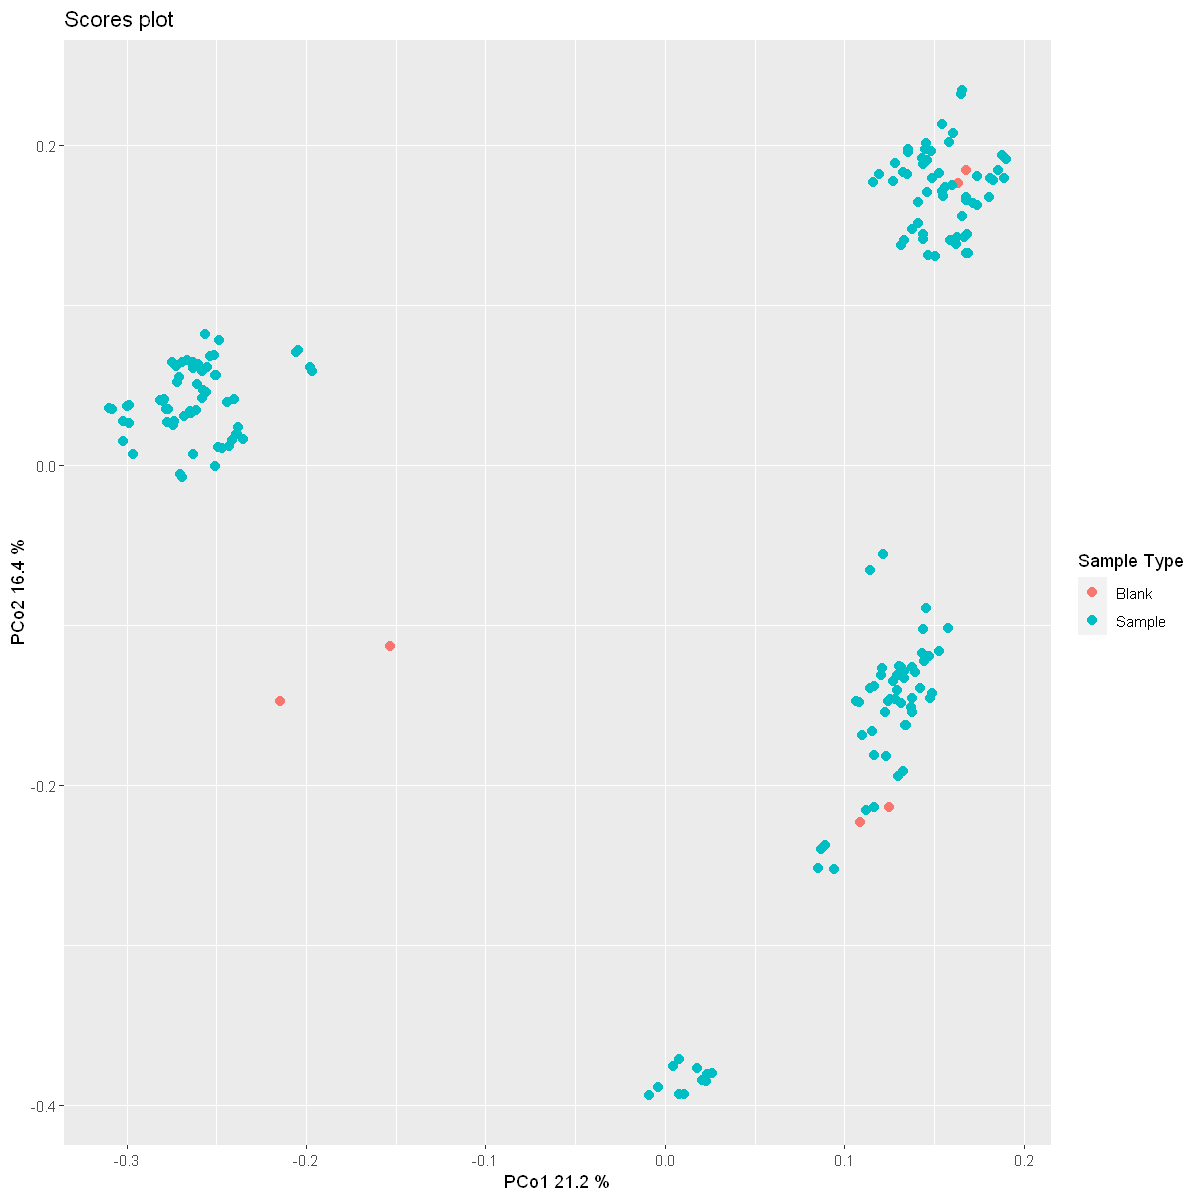

In [252]:
# visualising the first 2 principal coordinates labelled with sample type
ggplot(pcoa_pts, aes(x = PCoA1, y = PCoA2,color = md$`ATTRIBUTE_Sample.Type`))+
geom_point(size=2.5) + labs(color ="Sample Type") + 
ggtitle("Scores plot")+ xlab(paste('PCo1',var[1],'%', sep = ' ')) + ylab(paste('PCo2',var[2],'%', sep = ' '))

Now, we can continue with the data-cleanup steps. We can use the PCoA plots to visualise the before & after-effects of applying our data cleanup steps.

First, lets merge the metadata and feature table together.

In [253]:
#merging metadata (new_md) and transposed feature table based on the sample names
ft_merged <- merge(new_md,ft_t, by.x= "filename", by.y=0,all.x=TRUE) #by.y =0 indicates the rownames of ft_t
head(ft_merged, 3)

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,⋯,X88116_1444.398_11.482,X89487_1444.398_12.017,X86967_1444.398_11.216,X90591_1444.399_12.387,X91218_1444.399_12.614,X92162_1444.399_12.973,X88518_1444.399_11.718,X88057_1445.398_11.541,X89348_1445.398_11.988,X91876_1445.399_12.863
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,-117.2648,⋯,22355.824,81129.42,9451.771,57114.74,33504.23,0.000,20393.60,12523.67,21131.930,4865.259
2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,-117.2648,⋯,5870.526,24207.17,0.000,29632.88,28452.48,5834.431,13967.27,11848.81,8412.412,3065.691
3,SD_01-2018_10_a.mzXML,Sample,2,Jan,2018,10,a,10,32.86261,-117.2604,⋯,317439.000,1123902.40,74504.555,134384.03,762986.30,0.000,157763.02,130236.70,124595.060,138897.280


## <font color ='darkblue'> 3.1. Batch Correction (Optional) </font>
<a id="batch_corr"></a>
<p style='text-align: justify;'> A 'Batch' is a group of samples processed and analyzed by the same experimental & instrumental conditions. In general, if we have more samples than the tray size, we might measure them as multiple batches or groups. When arranging samples in a batch for measurement, in order to ensure biological diversity within a batch, in addition to our samples of interest, it advised to QCs, blanks, and controls (Wehrens et al., 2016). To merge data from these different batches, we must look for batch-effects, both, between the batches and within each batch and correct these effects. <br> <b>But, prior to batch correction on a dataset, we should evaluate the severity of the batch effect and when it is small, it is best to not perform batch correction as this may result in an incorrect estimation of the biological variance in the data. Instead, we should treat the statistical results with caution (Nygaard et al., 2016). For more details, please read the manuscript </b>.</p>

### a. Inter-batch correction:
<a id="inter_batch"></a>
<p style='text-align: justify;'> Here, in this tutorial, we have used the dataset from a study conducted by Petras et al., where the team assessed the chemical impacts of a major rain event in northern San Diego, California (USA) in Winter 2017/2018. Although the metadata has a column "ATTRIBUTE_Batch" mentioning the presence of 3 batches, these 3 groups are not considered as batches because they have differenet conditions altogether. By looking at the metadata column, "ATTRIBUTE_time_run", we understand that these 3 groups of seawater samples were measured at different times i.e, following their respective sample collection during Dec 2017, Jan 2018 (after rainfall), Oct 2018. Looking for inter-batch effects would make sense if they were all measured during the same time. In our case, it is not useful as these are 3 individual groups. </p>

But, in the case of having different batches, one can perform inter-batch correction based on the following steps:
    
1. Calculate the <b>overall mean</b> of each feature 
2. Calculate the mean of each feature for each batch referred as &rarr; <b>Batchwise feature-mean</b>
3. The feature intensities in each batch are then divided by the <b>batchwise feature-mean</b> and multiplied by the <b>overall mean</b>.

We can make use of the tidyverse package here and run a sequence of operations using pipes (%>%). This makes our codes easier to read as well as run faster.

In [254]:
# selecting only the filename & batch info column along with all feature intensity columns
ft_merged2 <- ft_merged %>% select(`filename`,`ATTRIBUTE_Batch`,starts_with("X")) 
head(ft_merged2,n=2)

,filename,ATTRIBUTE_Batch,X92572_151.035_13.364,X2513_151.035_1.13,X42_151.035_0.551,X1870_151.035_0.887,X2127_151.096_0.986,X86368_151.098_11.096,X90458_151.098_12.344,X88889_151.098_11.826,⋯,X88116_1444.398_11.482,X89487_1444.398_12.017,X86967_1444.398_11.216,X90591_1444.399_12.387,X91218_1444.399_12.614,X92162_1444.399_12.973,X88518_1444.399_11.718,X88057_1445.398_11.541,X89348_1445.398_11.988,X91876_1445.399_12.863
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SD_01-2018_1_a.mzXML,2,0,0,2827136,64247.68,0.000,0,0,0,⋯,22355.824,81129.42,9451.771,57114.74,33504.23,0.000,20393.60,12523.67,21131.930,4865.259
2,SD_01-2018_1_b.mzXML,2,0,0,3066569,67403.99,5057.914,0,0,0,⋯,5870.526,24207.17,0.000,29632.88,28452.48,5834.431,13967.27,11848.81,8412.412,3065.691


Now, we can continue with the batch correction steps. <br>

<b> Step 1: Calculate the overall mean of each feature: </b>

In [255]:
fm <- as.data.frame(rbind(colMeans(ft_merged2[,-(1:2)]))) #getting the columnwise mean for ft_merged2 except its 1st 2 columns
head(fm)

,X92572_151.035_13.364,X2513_151.035_1.13,X42_151.035_0.551,X1870_151.035_0.887,X2127_151.096_0.986,X86368_151.098_11.096,X90458_151.098_12.344,X88889_151.098_11.826,X87841_151.098_11.55,X1653_152.057_0.847,⋯,X88116_1444.398_11.482,X89487_1444.398_12.017,X86967_1444.398_11.216,X90591_1444.399_12.387,X91218_1444.399_12.614,X92162_1444.399_12.973,X88518_1444.399_11.718,X88057_1445.398_11.541,X89348_1445.398_11.988,X91876_1445.399_12.863
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,681.2794,6513.615,2427590,68230.42,7711.766,2015.666,12980.36,13262.71,6087.477,27408.76,⋯,46291.09,99376.37,22163.68,56797.82,81607.36,21294.59,32694.38,13250.36,32339,21588.38


<b>Step 2: Getting batchwise feature-mean</b>

In [256]:
bm <- ft_merged2[,-1] %>%  #excluding filename column as we are geting only batchwise mean value
group_by(`ATTRIBUTE_Batch`) %>%  # grouping them by Batch
summarise_all(mean) %>% # getting column-wise mean
column_to_rownames('ATTRIBUTE_Batch') %>%
as.data.frame() # storing it as dataframe

bm

,X92572_151.035_13.364,X2513_151.035_1.13,X42_151.035_0.551,X1870_151.035_0.887,X2127_151.096_0.986,X86368_151.098_11.096,X90458_151.098_12.344,X88889_151.098_11.826,X87841_151.098_11.55,X1653_152.057_0.847,⋯,X88116_1444.398_11.482,X89487_1444.398_12.017,X86967_1444.398_11.216,X90591_1444.399_12.387,X91218_1444.399_12.614,X92162_1444.399_12.973,X88518_1444.399_11.718,X88057_1445.398_11.541,X89348_1445.398_11.988,X91876_1445.399_12.863
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2043.838,3106.192,1480403,41142.11,0.00,0.000,0.00,0.00,0.00,8467.186,⋯,0.0,0.0,0.00,0.0000,0.0,0.00,0.00,0.00,0,0.00
2,0.000,13760.362,2670818,93043.35,12705.83,0.000,0.00,0.00,0.00,5056.063,⋯,138873.3,298129.1,66491.04,170198.5710,244822.1,63883.77,98083.13,39751.08,97017,64765.14
3,0.000,2674.290,3131548,70505.79,10429.47,6046.999,38941.09,39788.13,18262.43,68703.025,⋯,0.0,0.0,0.00,194.8854,0.0,0.00,0.00,0.00,0,0.00


We can also get the 'ft_merged2' dataframe split into batchwise dataframes using 'group_split' function. It returns a list with each element as a batch-specific dataframe.

In [257]:
batch_df <- ft_merged2 %>%
group_split(`ATTRIBUTE_Batch`) %>% #group_split splits & stores the batchwise info as individual dataframes inside a list
lapply(., function(x) { # lapply applies the below function to each element within the list created by the previous step 
    x <- column_to_rownames(x,'filename') # then, we make "filename" as the rownames of each dataframe within the list
}) 

sapply(batch_df, dim) # gives the dimension of each list element columnwise. 

62,62,62
11218,11218,11218


The above output shows that there are 3 dataframes inside 'batch_df' list, each with dimension of 62 rows and 11218 columns. Lets look at the 1st dataframe inside batch_df. It contains the 'Batch 1' data.

In [258]:
head(batch_df[[1]],n=2) 

,ATTRIBUTE_Batch,X92572_151.035_13.364,X2513_151.035_1.13,X42_151.035_0.551,X1870_151.035_0.887,X2127_151.096_0.986,X86368_151.098_11.096,X90458_151.098_12.344,X88889_151.098_11.826,X87841_151.098_11.55,⋯,X88116_1444.398_11.482,X89487_1444.398_12.017,X86967_1444.398_11.216,X90591_1444.399_12.387,X91218_1444.399_12.614,X92162_1444.399_12.973,X88518_1444.399_11.718,X88057_1445.398_11.541,X89348_1445.398_11.988,X91876_1445.399_12.863
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_12-2017_1_a.mzXML,1,0,0,1495509,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
SD_12-2017_1_b.mzXML,1,0,0,1424564,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


<b>Step 3: Correcting for inter-batch effect:</b> <br>
Here, the feature intensities in each batch within the batch list are then divided by the <b>batchwise feature-mean</b> and multiplied by the <b>overall mean

In [259]:
ib <- list() # creating an empty list for storing inter-batch corrected data

for (i in 1:length(batch_df)){
    ib[[i]] <- sweep((batch_df[[i]][,-1]), 2, as.numeric(bm[i,]+1), "/") #dividing each batch dataframe by batchwise feature-mean
    ib[[i]] <- sweep(ib[[i]], 2, as.numeric(fm+1), "*") # multiplying by overall mean
}

ib <- bind_rows(ib) #binding all the list elements together

In [260]:
head(ib,n=2)
dim(ib)

,X92572_151.035_13.364,X2513_151.035_1.13,X42_151.035_0.551,X1870_151.035_0.887,X2127_151.096_0.986,X86368_151.098_11.096,X90458_151.098_12.344,X88889_151.098_11.826,X87841_151.098_11.55,X1653_152.057_0.847,⋯,X88116_1444.398_11.482,X89487_1444.398_12.017,X86967_1444.398_11.216,X90591_1444.399_12.387,X91218_1444.399_12.614,X92162_1444.399_12.973,X88518_1444.399_11.718,X88057_1445.398_11.541,X89348_1445.398_11.988,X91876_1445.399_12.863
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_12-2017_1_a.mzXML,0,0,2452360,0,0,0,0,0,0,38280.59,⋯,0,0,0,0,0,0,0,0,0,0
SD_12-2017_1_b.mzXML,0,0,2336023,0,0,0,0,0,0,31585.74,⋯,0,0,0,0,0,0,0,0,0,0


[1]   186 11217

### b. Intra-batch correction:
<a id="intra_batch"></a>
<p style='text-align: justify;'> It is important to have pooled QC samples or some Internal Standards to correct for intra-batch effects. In case of not having pooled QCs, one can still look for intra-batch effect by visualizing the housekeeping features across the injection order or run time. For the test data used here, some components typically found in the DOM samples as mentioned in the study by <a href="https://doi.org/10.1016/j.chemosphere.2020.129450">Petras et al</a> are: Dibutyl phthalate, pheophorbide A and tryptophan. We will look at the feature 'tryptophan' to see if there is any intensity drift observed along the run time or injection order. However, we cannot correct the effect with housekeeping features, this can only be done with QCs. In such cases, it is better to not correct the effect and treat the data cautiously during statistical analyses. However, normalizing the data, in general, accounts for batch-correction to a certain extent.<font color=red> {insert ref} </font> </p>

- <font color = "red"> Say how you can perform intra-batch usually with QCs?</font>

<b> Visualizing within-batch effect using housekeeping features:</b> <br>
To plot this, we can make use of both dataframes created earlier:'ft_an' (ft table merged with annotations) and 'ft_merged' (ft merged with md)

Let's check if the annotated feature table contains the string 'tryptophan' in the column 'Compound_Name':

In [261]:
grep("tryptophan",ft_an$`Compound_Name`,ignore.case=TRUE,value=TRUE)

[1] "Spectral Match to L-Tryptophan from NIST14"                   
[2] "Spectral Match to L-Tryptophan from NIST14"                   
[3] "Tryptophan conjugated cholic acid"                            
[4] "B13A01 Faulkner library maybe Tryptophan needs ot be verified"
[5] "TRYPTOPHAN"

Now, we can subset the corresponding rows with annotations matching to 'tryptophan'. We also define the mz range for tryptophan. 

In [262]:
trp <- ft_an[grep("tryptophan",ft_an$`Compound_Name`,ignore.case=TRUE),,drop=F] #subsetting the rows that has been annotated as 'tryptophan'
trp <- trp %>% filter (`row m/z` > 200, `row m/z` < 250) #filtering with matching mz range
trp

row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,⋯,MoleculeExplorerDatasets,MoleculeExplorerFiles,InChIKey,InChIKey-Planar,superclass,class,subclass,npclassifier_superclass,npclassifier_class,npclassifier_pathway
<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<chr>,<lgl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
5234,205.0970,2.301127,NA,NA,NA,NA,NA,,NA,⋯,216,30170,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
7683,205.0970,2.569383,NA,NA,NA,548,20,[M+NH4]+,NA,⋯,216,30170,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
92649,226.9513,14.812855,NA,NA,NA,NA,NA,,NA,⋯,0,0,QIVBCDIJIAJPQS-VIFPVBQESA-N,QIVBCDIJIAJPQS,Organoheterocyclic compounds,Indoles and derivatives,Indolyl carboxylic acids and derivatives,Small peptides,Aminoacids,Amino acids and Peptides|Shikimates and Phenylpropanoids


The molecular weight of tryptophan is 204.22 g/mol. Here, we see tryptophan peaks (~205 m/z) with 2 different RTs. We will choose the feature with higher retention time (row ID 7683) to plot against the injection order.

Since, 'ft_merged' dataframe has the ft and md information combined, we can use it to plot the intensity vs Injection order plot.

In [263]:
head(ft_merged, n=2)

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,⋯,X88116_1444.398_11.482,X89487_1444.398_12.017,X86967_1444.398_11.216,X90591_1444.399_12.387,X91218_1444.399_12.614,X92162_1444.399_12.973,X88518_1444.399_11.718,X88057_1445.398_11.541,X89348_1445.398_11.988,X91876_1445.399_12.863
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,-117.2648,⋯,22355.824,81129.42,9451.771,57114.74,33504.23,0.000,20393.60,12523.67,21131.930,4865.259
2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,-117.2648,⋯,5870.526,24207.17,0.000,29632.88,28452.48,5834.431,13967.27,11848.81,8412.412,3065.691


Since the column name of ft_merged has the combined name of 'row ID', 'row mz' and 'row RT', we need to get the column name of our interest to be plotted.

In [264]:
grep('X7683',colnames(ft_merged),value = TRUE) # gets the column name of tryptophan

[1] "X7683_205.097_2.569"

`geom_smooth()` using formula = 'y ~ x'


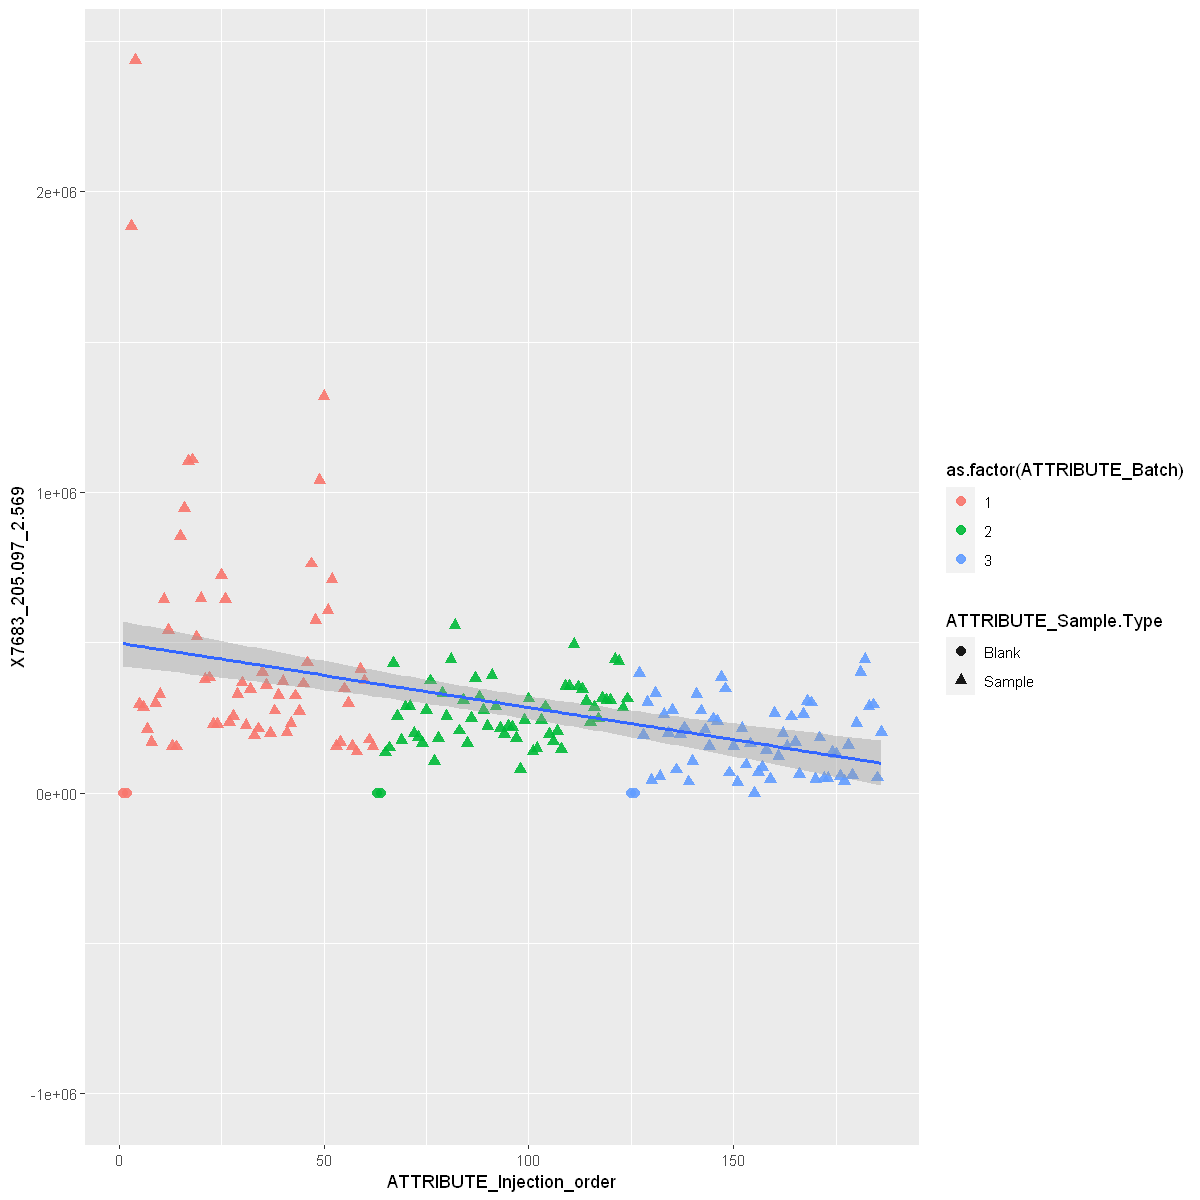

In [265]:
ggplot(ft_merged, 
       aes(x=`ATTRIBUTE_Injection_order`, 
           y=`X7683_205.097_2.569`)) + #paste the y axis name from the previous cell output
geom_point(size=2.5, alpha=0.9, 
           aes(color=as.factor(`ATTRIBUTE_Batch`), 
               shape = `ATTRIBUTE_Sample.Type`)) +
geom_smooth(method = 'lm',na.rm = T) +  # to add a trend line
scale_y_continuous(labels = scales::scientific,
                   limits=c(-1e6,max(ft_merged$`X7683_205.097_2.569`)))

Since,we do not observe a big drift in the intensity, we do not need to correct for intra-batch effect. But when one has QCs, and observe an intensity drift, you can perform within-batch correction:

<font color ="red"> Acceptable range for intensity drift?  </font>

## <font color ='darkblue'> 3.2 Blank removal </font>  
<a id="blank_rem"></a>

<p style='text-align: justify;'> Blank samples are samples, which contain no analytes of interest and consist for example of the solvent, matrix, tissue or growth media that was used to prepare or dissolve the samples and analytes of interest. Such as the analytes, the mass spectral features deriving from blank samples are also detected by the LC-MS/MS instrument. Our goal here is to remove these features from our samples and analytes of interest, which we will use for further downstream analysis. </p>

**How do we remove these blank features?** </br> 

<p style='text-align: justify;'> At first we split the feature table into blanks and samples, and then compare blanks to the samples to identify the background features coming from blanks. A common filtering method is to use a cutoff to remove features that are not present sufficient enough in our biological samples. </p>

The steps followed in the next few cells are:
1. We find an average for all the feature intensities in your blank set and sample set. Therefore, we average each feature intensity across all samples and blanks.
2. Next, we get a ratio of this average_feature_blanks vs average_feature_sample. This ratio blank/sample tells us how much of that particular feature of a sample gets its contribution from blanks. If it is more than 30% (or cutoff as 0.3), we consider the feature as noise. 
3. The resulting information (if ratio > cutoff) is stored in a bin such that 1 = noise or background signal and 0 = analyte signal.
4. We count the number of features in the bin that satisfies the condition: <b>ratio > cutoff </b>, and consider those features as <b>'noise or background features'</b> and remove them.

### 3.2.1 Splitting data into blanks and samples using metadata
<a id="blank_split"></a>

In order to remove blank features from our samples, we first split our feature table into blanks and samples using the metadata and our InsideLevels function created in [Section 2.3.2](#explore_md).

In [266]:
InsideLevels(new_md[2:10])

INDEX,ATTRIBUTES,LEVELS,COUNT,ATTRIBUTE_CLASS
<int>,<chr>,<chr>,<chr>,<chr>
1,ATTRIBUTE_Sample.Type,"Blank, Sample","6, 180",character
2,ATTRIBUTE_Batch,"1, 2, 3","62, 62, 62",integer
3,ATTRIBUTE_Month,"Dec, Jan, Oct","62, 62, 62",character
4,ATTRIBUTE_Year,"2017, 2018","62, 124",integer
5,ATTRIBUTE_Sample_Location,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",integer
6,ATTRIBUTE_Replicate,"a, b","93, 93",character
7,ATTRIBUTE_Spot,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",integer
8,ATTRIBUTE_Latitude,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",numeric
9,ATTRIBUTE_Longitude,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",numeric


In [267]:
#Getting the blank based on the metadata
md_Blank <- new_md %>% filter(`ATTRIBUTE_Sample.Type` == "Blank") #filtering the rows from metadata with the condition = blank
Blank <- ft_t[which(rownames(ft_t) %in% (md_Blank$`filename`)),,drop=F] #getting the corresponding rows from ft_t

head(Blank,n=2)
dim(Blank) 

,X92572_151.035_13.364,X2513_151.035_1.13,X42_151.035_0.551,X1870_151.035_0.887,X2127_151.096_0.986,X86368_151.098_11.096,X90458_151.098_12.344,X88889_151.098_11.826,X87841_151.098_11.55,X1653_152.057_0.847,⋯,X88116_1444.398_11.482,X89487_1444.398_12.017,X86967_1444.398_11.216,X90591_1444.399_12.387,X91218_1444.399_12.614,X92162_1444.399_12.973,X88518_1444.399_11.718,X88057_1445.398_11.541,X89348_1445.398_11.988,X91876_1445.399_12.863
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_PPL_Bl_1.mzXML,0,0,80114.62,0,23387.72,0,0,0,0,0,⋯,97086.41,150529.2,105396.63,64037.15,112919.62,26315.72,52188.0,39243.56,61705.28,28096.68
SD_01-2018_PPL_Bl_2.mzXML,0,0,21310.25,0,21032.02,0,0,0,0,0,⋯,39701.70,107531.1,82760.02,78997.61,97719.95,24918.46,208566.6,0.00,0.00,20651.02


[1]     6 11217

In [268]:
#Getting the samples based on the metadata 
md_Samples <- new_md %>% filter(`ATTRIBUTE_Sample.Type` == "Sample") #filtering the rows from metadata with the condition = sample
Samples <- ft_t[which(rownames(ft_t) %in% (md_Samples$`filename`)),,drop=F] #getting the corresponding rows from ft_t

head(Samples, n=2)
dim(Samples)

,X92572_151.035_13.364,X2513_151.035_1.13,X42_151.035_0.551,X1870_151.035_0.887,X2127_151.096_0.986,X86368_151.098_11.096,X90458_151.098_12.344,X88889_151.098_11.826,X87841_151.098_11.55,X1653_152.057_0.847,⋯,X88116_1444.398_11.482,X89487_1444.398_12.017,X86967_1444.398_11.216,X90591_1444.399_12.387,X91218_1444.399_12.614,X92162_1444.399_12.973,X88518_1444.399_11.718,X88057_1445.398_11.541,X89348_1445.398_11.988,X91876_1445.399_12.863
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,0,0,2827136,64247.68,0.000,0,0,0,0,0,⋯,22355.824,81129.42,9451.771,57114.74,33504.23,0.000,20393.60,12523.67,21131.930,4865.259
SD_01-2018_1_b.mzXML,0,0,3066569,67403.99,5057.914,0,0,0,0,0,⋯,5870.526,24207.17,0.000,29632.88,28452.48,5834.431,13967.27,11848.81,8412.412,3065.691


[1]   180 11217

### 3.2.2 Removing blanks
<a id = "removing_blanks"></a>

Now that we have our feature table split into blanks and samples, we can start removing blank features.

**<font color='red'> We use a cutoff of 0.3 </font>**, meaning that in order for a feature to be considered of interest, it needs to have a ratio of average_feature_blanks vs average_feature_sample <30%. <b>In the below cell you can interactively change the threshold to any value between 0.1 and 1. </b>

In [270]:
#When cutoff is low, more noise (or background) detected; With higher cutoff, less background detected, thus more features observed
Cutoff <- as.numeric(readline('Enter Cutoff value between 0.1 & 1:')) # (i.e. 10% - 100%). Ideal cutoff range: 0.1-0.3
    
#Getting mean for every feature in blank and Samples in a data frame named 'Avg_ft'
Avg_ft <- data.frame(Avg_blank=colMeans(Blank, na.rm= F)) # set na.rm = F to check if there are NA values. When set as T, NA values are changed to 0
Avg_ft$`Avg_samples` <- colMeans(Samples, na.rm= F) # adding another column 'Avg_samples' for feature means of samples
    
#Getting the ratio of blank vs Sample
Avg_ft$`Ratio_blank_Sample` <- (Avg_ft$`Avg_blank`+1)/(Avg_ft$`Avg_samples`+1)
    
# Creating a bin with 1s when the ratio>Cutoff, else put 0s
Avg_ft$`Bg_bin` <- ifelse(Avg_ft$`Ratio_blank_Sample` > Cutoff, 1, 0 )

# Checking if there are any NA values present. Having NA values in the 4 variables will affect the final dataset to be created
IRdisplay::display(data.frame(NA_count=sapply(Avg_ft, function(x) sum(is.na(x)))))

#Calculating the number of background features and features present
print(paste("Total no.of features:",nrow(Avg_ft)))
print(paste("No.of Background or noise features:",sum(Avg_ft$`Bg_bin` ==1,na.rm = T)))
print(paste("No.of features after excluding noise:",(ncol(Samples) - sum(Avg_ft$`Bg_bin` ==1,na.rm = T))))
                                
blk_rem <- merge(as.data.frame(t(Samples)), Avg_ft, by=0) %>%
                    filter(Bg_bin == 0) %>% #picking only the features
                    select(-c(Avg_blank,Avg_samples,Ratio_blank_Sample,Bg_bin)) %>% #removing the last 4 columns
                    column_to_rownames(var="Row.names")

Enter Cutoff value between 0.1 & 1: 0.3


,NA_count
,<int>
Avg_blank,0
Avg_samples,0
Ratio_blank_Sample,0
Bg_bin,0


[1] "Total no.of features: 11217"
[1] "No.of Background or noise features: 2125"
[1] "No.of features after excluding noise: 9092"


In [271]:
#Looking the blanks removed dataframe
head(blk_rem, 2)
dim(blk_rem)

,SD_01-2018_1_a.mzXML,SD_01-2018_1_b.mzXML,SD_01-2018_10_a.mzXML,SD_01-2018_10_b.mzXML,SD_01-2018_11_a.mzXML,SD_01-2018_11_b.mzXML,SD_01-2018_12_a.mzXML,SD_01-2018_12_b.mzXML,SD_01-2018_13_a.mzXML,SD_01-2018_13_b.mzXML,⋯,SD_12-2017_5_a.mzXML,SD_12-2017_5_b.mzXML,SD_12-2017_6_a.mzXML,SD_12-2017_6_b.mzXML,SD_12-2017_7_a.mzXML,SD_12-2017_7_b.mzXML,SD_12-2017_8_a.mzXML,SD_12-2017_8_b.mzXML,SD_12-2017_9_a.mzXML,SD_12-2017_9_b.mzXML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X10015_282.169_2.763,50907.97,51443.73,109227.8,176375.7,104468.7,107860.7,416643.3,100000.8,113347.2,229451.5,⋯,81368.72,110551.6,86917.61,73583.3,135812.4,142495.9,172251.7,259688.5,205187.2,139750.70
X10035_325.139_2.817,196008.38,99569.05,144769.5,133548.6,508455.6,99449.2,450726.6,161512.5,151758.7,146276.4,⋯,106263.34,308457.9,207960.67,227622.1,115274.4,534276.9,113054.6,114660.3,729054.1,80493.73


[1] 9092  180

In [272]:
# metadata without the blanks info
head(md_Samples, 2)
dim(md_Samples)

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:36,65
2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:52,66


[1] 180  14

In [ ]:
write.csv(blk_rem, paste0(Sys.Date(),'_Blanks_Removed_with_cutoff_',Cutoff,'.csv'),row.names =TRUE)

## <font color ='darkblue'> 3.3 Imputation </font>
<a id = 'imp'></a>

<p style='text-align: justify;'> For several reasons, real world datasets might have some missing values in it, in the form of NA, NANs or 0s. Eventhough the gapfilling step of MZmine fills the missing values, we still end up with some missing values or 0s in our feature table. This could be problematic for statistical analysis. We cannot simply discard those rows or columns with missing values as we will lose valuable data. Instead we can try imputing or replacing the missing values in the data with a meaningful, reasonable guess. Here, first, we use the blank-removed feature table to assess frequencies across relative intensities. The plot from the below cell shows us how many features have which relative intensities. We then create random values between 0 and the minimum value in our blank-removed table and randomly replace all 0s with these random values. </p>

[1] "The minimum value greater than 0 in gap-filled table: 892"


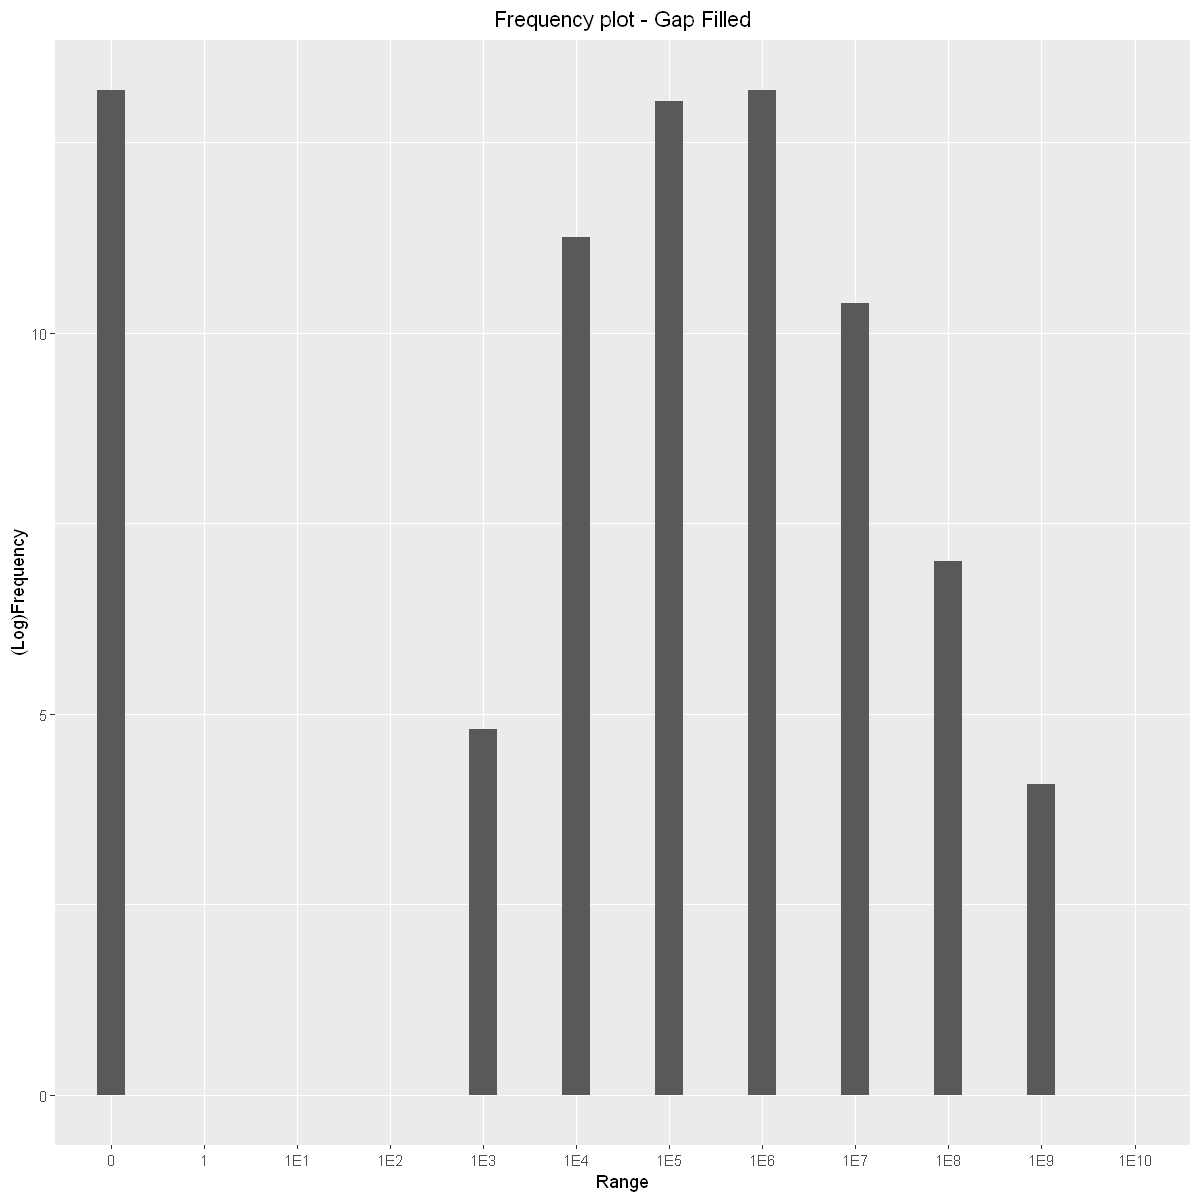

In [273]:
#creating bins from -1 to 10^10 using sequence function seq()
bins <- c(-1,0,(1 * 10^(seq(0,10,1)))) 

#cut function cuts the give table into its appropriate bins
scores_gapfilled <- cut(as.matrix(blk_rem),bins, labels = c('0','1',paste("1E",1:10,sep="")))

#transform function convert the tables into a column format: easy for visualization
FreqTable <- transform(table(scores_gapfilled)) #contains 2 columns: "scores_x1", "Freq"
FreqTable$Log_Freq <- log(FreqTable$Freq+1) #Log scaling the frequency values
colnames(FreqTable)[1] <- 'Range_Bins' #changing the 1st colname to 'Range Bins'

## GGPLOT2
ggplot(FreqTable, aes(x=Range_Bins, y=Log_Freq))+ 
    geom_bar(stat="identity",position = "dodge", width=0.3) + 
    ggtitle(label="Frequency plot - Gap Filled") +
    xlab("Range") + ylab("(Log)Frequency") + 
    theme(plot.title = element_text(hjust = 0.5))

Cutoff_LOD <- round(min(blk_rem[blk_rem!=min(blk_rem)]))
print(paste0("The minimum value greater than 0 in gap-filled table: ",Cutoff_LOD)) 

The above histogram shows that, in our, blank-removed feature table, there are many zeros present. And no values in the range between 0 to 1E2. The minimum value greater than 0 in our dataframe is in between 1E2 & 1E3 (and that value is 892).

In [274]:
# Creating random variables (between 0 and Cutoff_LOD) to replace all zeros
set.seed(141222) # by setting a seed, we generate the same set of random number all the time
ran_val <-round(runif(length(blk_rem),0,Cutoff_LOD),digits=1)
print(ran_val)

  [1] 772.3 183.1 252.2 202.9 131.9 113.8 521.3 813.3 800.5 208.5 173.7 283.4
 [13] 722.4 610.1 666.7  51.6 580.2 397.2 760.0 669.9 595.1 235.3 491.9 159.7
 [25] 402.8  72.9 452.5 778.8 682.3 271.0 475.6 218.7 702.6 367.5 778.3  93.4
 [37] 499.9 722.0 149.8 889.5  87.2 884.6 509.1 142.3 437.5 809.2  50.1 858.1
 [49] 405.1 813.4  54.1 570.9 567.4 313.3 289.2 345.2 454.2 118.5 213.3 371.0
 [61] 370.0  88.6  96.8 575.8 109.5 599.6  76.5 552.7  23.4 453.9  24.3 481.0
 [73] 140.1 443.4 327.8 761.3 296.4 152.5 135.4 515.0 638.4 603.3 547.6 876.5
 [85] 470.7 220.4 120.5 261.7 568.2 805.8 622.9 694.7 354.8 596.9 884.6  39.6
 [97]  35.2 651.4 527.1 821.0 714.8 320.9 405.8  72.6 579.3 254.2 123.3  23.7
[109] 169.8 470.1 588.2  12.6 579.7  74.4 233.2 430.7 699.1 846.3 138.2 391.1
[121]   3.3 621.8 262.9 237.3 438.3 878.5 410.4 253.3 736.5 189.5 814.3 206.5
[133] 466.1  87.8 814.4 333.3 224.3 470.3 122.8 532.4 159.7 192.2 698.6 884.7
[145] 320.8 167.6 640.9 344.0  58.6 350.8 606.8 520.9 720.5 426.

In [275]:
imp <- blk_rem  %>% mutate(across(everything(),
                                  ~replace(., . == 0 , # here '.' represents the dataframe 'blk_rem'
                                           sample(ran_val, size=1)))) # sample function pick one random sample from 'ran_val'
head(imp, 2)

,SD_01-2018_1_a.mzXML,SD_01-2018_1_b.mzXML,SD_01-2018_10_a.mzXML,SD_01-2018_10_b.mzXML,SD_01-2018_11_a.mzXML,SD_01-2018_11_b.mzXML,SD_01-2018_12_a.mzXML,SD_01-2018_12_b.mzXML,SD_01-2018_13_a.mzXML,SD_01-2018_13_b.mzXML,⋯,SD_12-2017_5_a.mzXML,SD_12-2017_5_b.mzXML,SD_12-2017_6_a.mzXML,SD_12-2017_6_b.mzXML,SD_12-2017_7_a.mzXML,SD_12-2017_7_b.mzXML,SD_12-2017_8_a.mzXML,SD_12-2017_8_b.mzXML,SD_12-2017_9_a.mzXML,SD_12-2017_9_b.mzXML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X10015_282.169_2.763,50907.97,51443.73,109227.8,176375.7,104468.7,107860.7,416643.3,100000.8,113347.2,229451.5,⋯,81368.72,110551.6,86917.61,73583.3,135812.4,142495.9,172251.7,259688.5,205187.2,139750.70
X10035_325.139_2.817,196008.38,99569.05,144769.5,133548.6,508455.6,99449.2,450726.6,161512.5,151758.7,146276.4,⋯,106263.34,308457.9,207960.67,227622.1,115274.4,534276.9,113054.6,114660.3,729054.1,80493.73


In [276]:
sum(imp==0) # checking if there are any zeros in our imputed table 

[1] 0

In [ ]:
write.csv(imp,paste0(Sys.Date(),'_Imputed_QuantTable.csv'),row.names =T)

## <font color ='darkblue'> 3.4 Normalization </font>
<a id="norm"></a>

<font color = "red"> add some description of what normalization is </font>

To be edited... Here, we present 2 types of normalization. TIC or PQN. Choose according to your data.

### 3.4.1 Total Ion Current (TIC) or sample-centric normalization
<a id="tic"></a>

The following code performs sample-centric (column-wise) normalisation. Here, we divide each element (mass spectral feature) of a particular column (sample) with its column sum.

In [277]:
norm_TIC <- t(normalization(t(imp), method = "sum")$newXtrain) 
head(norm_TIC,n=3)
dim(norm_TIC)
print(paste('No.of NA values in Normalized data:',sum(is.na(norm_TIC)== T)))

,SD_01-2018_1_a.mzXML,SD_01-2018_1_b.mzXML,SD_01-2018_10_a.mzXML,SD_01-2018_10_b.mzXML,SD_01-2018_11_a.mzXML,SD_01-2018_11_b.mzXML,SD_01-2018_12_a.mzXML,SD_01-2018_12_b.mzXML,SD_01-2018_13_a.mzXML,SD_01-2018_13_b.mzXML,⋯,SD_12-2017_5_a.mzXML,SD_12-2017_5_b.mzXML,SD_12-2017_6_a.mzXML,SD_12-2017_6_b.mzXML,SD_12-2017_7_a.mzXML,SD_12-2017_7_b.mzXML,SD_12-2017_8_a.mzXML,SD_12-2017_8_b.mzXML,SD_12-2017_9_a.mzXML,SD_12-2017_9_b.mzXML
X10015_282.169_2.763,2.977175e-05,2.999528e-05,7.230727e-05,1.328148e-04,7.489287e-05,7.469619e-05,2.662925e-04,6.390917e-05,7.486779e-05,1.481398e-04,⋯,1.172983e-04,1.586839e-04,1.134921e-04,0.0000957115,1.578179e-04,1.528850e-04,1.724326e-04,2.600404e-04,2.198192e-04,1.511484e-04
X10035_325.139_2.817,1.146287e-04,5.805570e-05,9.583535e-05,1.005651e-04,3.645081e-04,6.887101e-05,2.880764e-04,1.032204e-04,1.002393e-04,9.443975e-05,⋯,1.531855e-04,4.427554e-04,2.715433e-04,0.0002960733,1.339522e-04,5.732299e-04,1.131733e-04,1.148156e-04,7.810432e-04,8.705858e-05
X10037_216.123_2.847,5.291461e-05,2.399888e-04,3.457870e-05,4.954185e-05,6.217140e-05,1.047900e-04,2.763333e-05,4.747816e-05,9.935738e-05,9.887989e-05,⋯,3.270679e-05,1.117159e-06,2.893803e-05,0.0001112567,4.807443e-05,6.970476e-05,8.292529e-05,4.744758e-05,8.797619e-05,6.254650e-05


[1] 9092  180

[1] "No.of NA values in Normalized data: 0"


In [ ]:
write.csv(norm_TIC, paste0(Sys.Date(),'_TIC_Normalised_table.csv'),row.names =T)

### 3.4.2 Probabilistic Quotient Normalization (PQN)
<a id="pqn"></a>

In [278]:
norm_pqn <- t(normalization(t(imp), method = "pqn")$newXtrain)
head(norm_pqn,n=3)
dim(norm_pqn)
print(paste('No.of NA values in Normalized data:',sum(is.na(norm_pqn)== T)))

,SD_01-2018_1_a.mzXML,SD_01-2018_1_b.mzXML,SD_01-2018_10_a.mzXML,SD_01-2018_10_b.mzXML,SD_01-2018_11_a.mzXML,SD_01-2018_11_b.mzXML,SD_01-2018_12_a.mzXML,SD_01-2018_12_b.mzXML,SD_01-2018_13_a.mzXML,SD_01-2018_13_b.mzXML,⋯,SD_12-2017_5_a.mzXML,SD_12-2017_5_b.mzXML,SD_12-2017_6_a.mzXML,SD_12-2017_6_b.mzXML,SD_12-2017_7_a.mzXML,SD_12-2017_7_b.mzXML,SD_12-2017_8_a.mzXML,SD_12-2017_8_b.mzXML,SD_12-2017_9_a.mzXML,SD_12-2017_9_b.mzXML
X10015_282.169_2.763,3.540018e-05,3.017861e-05,5.255678e-05,1.068633e-04,6.356057e-05,9.757233e-05,0.0002231066,7.298662e-05,5.541492e-05,1.189655e-04,⋯,0.0001028529,9.632791e-05,6.755138e-05,0.0001836754,1.122295e-04,1.400207e-04,1.449955e-04,2.741661e-04,1.882258e-04,1.713079e-04
X10035_325.139_2.817,1.362995e-04,5.841053e-05,6.965824e-05,8.091504e-05,3.093531e-04,8.996315e-05,0.0002413577,1.178815e-04,7.419413e-05,7.584102e-05,⋯,0.0001343205,2.687715e-04,1.616247e-04,0.0005681803,9.525785e-05,5.249965e-04,9.516542e-05,1.210526e-04,6.687881e-04,9.867006e-05
X10037_216.123_2.847,6.291825e-05,2.414556e-04,2.513364e-05,3.986156e-05,5.276403e-05,1.368825e-04,0.0000231519,5.422180e-05,7.354139e-05,7.940673e-05,⋯,0.0000286789,6.781633e-07,1.722414e-05,0.0002135074,3.418733e-05,6.383958e-05,6.973039e-05,5.002499e-05,7.533185e-05,7.088867e-05


[1] 9092  180

[1] "No.of NA values in Normalized data: 0"


In [ ]:
write.csv(norm_pqn, paste0(Sys.Date(),'_PQN_Normalised_Quant_table.csv'),row.names =T)

## <font color ='darkblue'> 3.5 Scaling </font>
<a id='scaling'></a>

<font color="red">add some description here on why we scale data and what it is</font>

In [279]:
Imp_t <- as.data.frame(t(imp)) #transposing the imputed table
head(Imp_t, n=2)

,X10015_282.169_2.763,X10035_325.139_2.817,X10037_216.123_2.847,X10047_338.159_2.845,X10058_280.117_2.961,X10059_414.175_2.851,X10072_305.157_2.851,X10074_283.175_2.851,X10078_300.201_2.851,X10082_309.144_2.886,⋯,X9833_268.175_2.821,X9860_240.144_2.824,X9876_414.139_2.761,X9884_190.05_2.832,X9897_333.144_2.881,X9909_400.16_2.813,X9918_252.123_2.833,X9957_402.139_3.01,X9972_323.123_2.716,X9995_276.159_2.805
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,50907.97,196008.38,90480.91,446560.7,182757.8,121197.4,615145.0,2004980,2698188,206.5,⋯,108854.26,437011.9,90982.97,114156.20,73891.54,245935.5,447505.8,862014.4,199116.2,127721.8
SD_01-2018_1_b.mzXML,51443.73,99569.05,411595.38,239022.0,274146.0,201966.1,527106.5,1937671,2750867,455468.0,⋯,52075.82,570035.0,519301.53,99533.95,139784.78,144992.2,807991.6,777378.6,203698.4,279187.2


In [280]:
#Imp_t <- Imp_t[match(md_Samples$filename,rownames(Imp_t)),] # ordering the rows in the feature table and metadata
identical(rownames(Imp_t),md_Samples$filename) #should return TRUE

[1] TRUE

In [281]:
Imp_s <- scale(Imp_t, center = T, scale = T) # center and scale data
head(Imp_s, n=2)

,X10015_282.169_2.763,X10035_325.139_2.817,X10037_216.123_2.847,X10047_338.159_2.845,X10058_280.117_2.961,X10059_414.175_2.851,X10072_305.157_2.851,X10074_283.175_2.851,X10078_300.201_2.851,X10082_309.144_2.886,⋯,X9833_268.175_2.821,X9860_240.144_2.824,X9876_414.139_2.761,X9884_190.05_2.832,X9897_333.144_2.881,X9909_400.16_2.813,X9918_252.123_2.833,X9957_402.139_3.01,X9972_323.123_2.716,X9995_276.159_2.805
SD_01-2018_1_a.mzXML,-1.130474,-0.2996871,-0.1117275,2.2186171,-1.452146,-0.1759304,-0.3434611,-0.1778404,-0.1933466,-0.98676658,⋯,0.50953425,0.3411530,-0.9690079,-0.2136334,-1.0317304,-0.3097998,-0.177995,1.167922,-0.9536029,-0.720846274
SD_01-2018_1_b.mzXML,-1.126516,-0.6037355,1.9885898,0.2986375,-1.028317,0.3848581,-0.3749450,-0.1894778,-0.1876122,0.01064504,⋯,0.09238905,0.5326194,1.0516269,-0.3038794,-0.1930184,-0.7478181,1.252001,0.955153,-0.9361819,-0.008639177


In [ ]:
write.csv(Imp_s, paste0(Sys.Date(),'_scaled_table.csv'),row.names =T)

# <font color ='blue'> 4. Univariate Analysis </font>
<a id="uni"></a>

In the following section we will use univariate statistical analyses to investigate how the metabolome is influenced by:


*   Sampling site: We will compare seven different sampling areas and investigate if there is a gradual shift in metabolite levels from along the coast. 
*   Heavy rainfall: By comparing metabolite levels before and and after a heavy rainfall in January 2018.

Once again, let's merge metadata and the scaled data to one dataframe.

In [282]:
Data <- merge(md_Samples,Imp_s,by.x="filename",by.y="row.names")

We make sure that the merging of the two data frames was successful. 

In [283]:
dim(Imp_s)
dim(md_Samples)
dim(Data)

[1]  180 9092

[1] 180  14

[1]  180 9106

In [284]:
head(Data, 2)

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,⋯,X9833_268.175_2.821,X9860_240.144_2.824,X9876_414.139_2.761,X9884_190.05_2.832,X9897_333.144_2.881,X9909_400.16_2.813,X9918_252.123_2.833,X9957_402.139_3.01,X9972_323.123_2.716,X9995_276.159_2.805
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,-117.2648,⋯,0.50953425,0.3411530,-0.9690079,-0.2136334,-1.0317304,-0.3097998,-0.177995,1.167922,-0.9536029,-0.720846274
2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,-117.2648,⋯,0.09238905,0.5326194,1.0516269,-0.3038794,-0.1930184,-0.7478181,1.252001,0.955153,-0.9361819,-0.008639177


## <font color ='darkblue'> 4.1 ANOVA </font>
<a id="anova"></a>

We will test whether metabolite levels were different between different sampling sites, where seven different sampling areas will be compared. We  use the function aov to run statistical analyses using ANOVA. Since one ANOVA is being run for each metabolite feature, we run the analyses in a loop and save the output for each feature in a list called anova_out.<br>

The vector a indicates which columns in the dataset are features (i.e. from "start" to the last column of the data frame). <br>

We can run a for loop to pass each feature column into the first argument of the aov function, while the second argument, time point, is constant.

In [285]:
colnames(Data)[1:15]

[1] "filename"                  "ATTRIBUTE_Sample.Type"    
 [3] "ATTRIBUTE_Batch"           "ATTRIBUTE_Month"          
 [5] "ATTRIBUTE_Year"            "ATTRIBUTE_Sample_Location"
 [7] "ATTRIBUTE_Replicate"       "ATTRIBUTE_Spot"           
 [9] "ATTRIBUTE_Latitude"        "ATTRIBUTE_Longitude"      
[11] "ATTRIBUTE_Sample_Area"     "ATTRIBUTE_Spot_Name"      
[13] "ATTRIBUTE_time_run"        "ATTRIBUTE_Injection_order"
[15] "X10015_282.169_2.763"

In [286]:
start <- which(colnames(Data)=="ATTRIBUTE_Injection_order")+1 # This defines the column after injection order to be the first in the metabolite part of the dataset

In [287]:
anova_out=NULL
a <- start:ncol(Data) #We use the start variable to indicate where metabolite data starts in the data frame
for (i in 1:length(a)){
  anova_out[[i]] <- aov(scale(Data[,a[i]])~as.factor(Data$'ATTRIBUTE_Sample_Area'))
}

summary(anova_out[[1]]) #show the first entry in the list

                                       Df Sum Sq Mean Sq F value Pr(>F)
as.factor(Data$ATTRIBUTE_Sample_Area)   6   7.56   1.260   1.272  0.273
Residuals                             173 171.44   0.991               

<b>Extract p- and F-values from anova output list: </b><br>
Lists of ANOVA results are not convenient when summarizing our findings. We extract the desired data from the list and summarize this in a dataframe called <b>op_aov.</b> <br>

The following is of interest:
*   Feature ID
*   p-value for ANOVA
*   p-value after taking multiple tests into consideration
*   F-value

In [288]:
#extract p- and F-values from ANOVA output list
op_aov <- data.frame(colnames(Data[start:ncol(Data)]))
colnames(op_aov)[1] <- "Metabolites"
op_aov["p"] <- sapply(1:length(a),function(n){summary(anova_out[[n]])[[1]][1,5]})
op_aov["p_bonferroni"] <- p.adjust(op_aov$p,method="bonferroni")
op_aov["significant"]  <- ifelse(op_aov$p_bonferroni<0.05,"Significant","Nonsignificant")
op_aov["F"] <- sapply(1:length(a),function(n){summary(anova_out[[n]])[[1]][1,4]})

Now we have created a dataframe with desired results from the ANOVA. We can sort the results after the p value, using arrange, and select the top N rows using slice_head. Are there any significant findings?

In [289]:
#Arrange the output anova list by top 10 p-values
op_aov %>% arrange (p) %>% slice_head(n=10)

Metabolites,p,p_bonferroni,significant,F
<chr>,<dbl>,<dbl>,<chr>,<dbl>
X59188_312.231_7.625,9.413695e-30,8.558932e-26,Significant,39.00333
X33200_260.196_4.886,1.649322e-28,1.499563e-24,Significant,36.75640
X57080_314.247_7.36,3.033785e-24,2.758317e-20,Significant,29.58350
X21870_246.18_3.969,7.261726e-23,6.602361e-19,Significant,27.42957
X80910_243.174_10.41,1.655165e-21,1.504876e-17,Significant,25.38274
X55328_312.232_7.138,3.090564e-21,2.809941e-17,Significant,24.98246
X76223_982.448_9.906,3.513942e-21,3.194876e-17,Significant,24.90051
X55979_529.37_7.232,4.365882e-21,3.969460e-17,Significant,24.76221
X47253_300.195_6.208,6.840211e-21,6.219120e-17,Significant,24.47723


**Plot ANOVA results**

We will use ggplot to visualize results from the ANOVA, with log(F-values) on the x-axis and -log(p) on the y-axis. Features are colored after statistical significance after multiple test correction. Since there are large differences in the F- and P-values, it is easier to plot their log.

We can also display the names of some of the top features in the plot. This easily gets very cluttered if we decide to display too many names, so starting at the top 5 could be a good idea. We can select these similarly to the cell above (pipes with arrange and slice_head). Using geom_text_repel, you can make sure the labels are not overlapping)

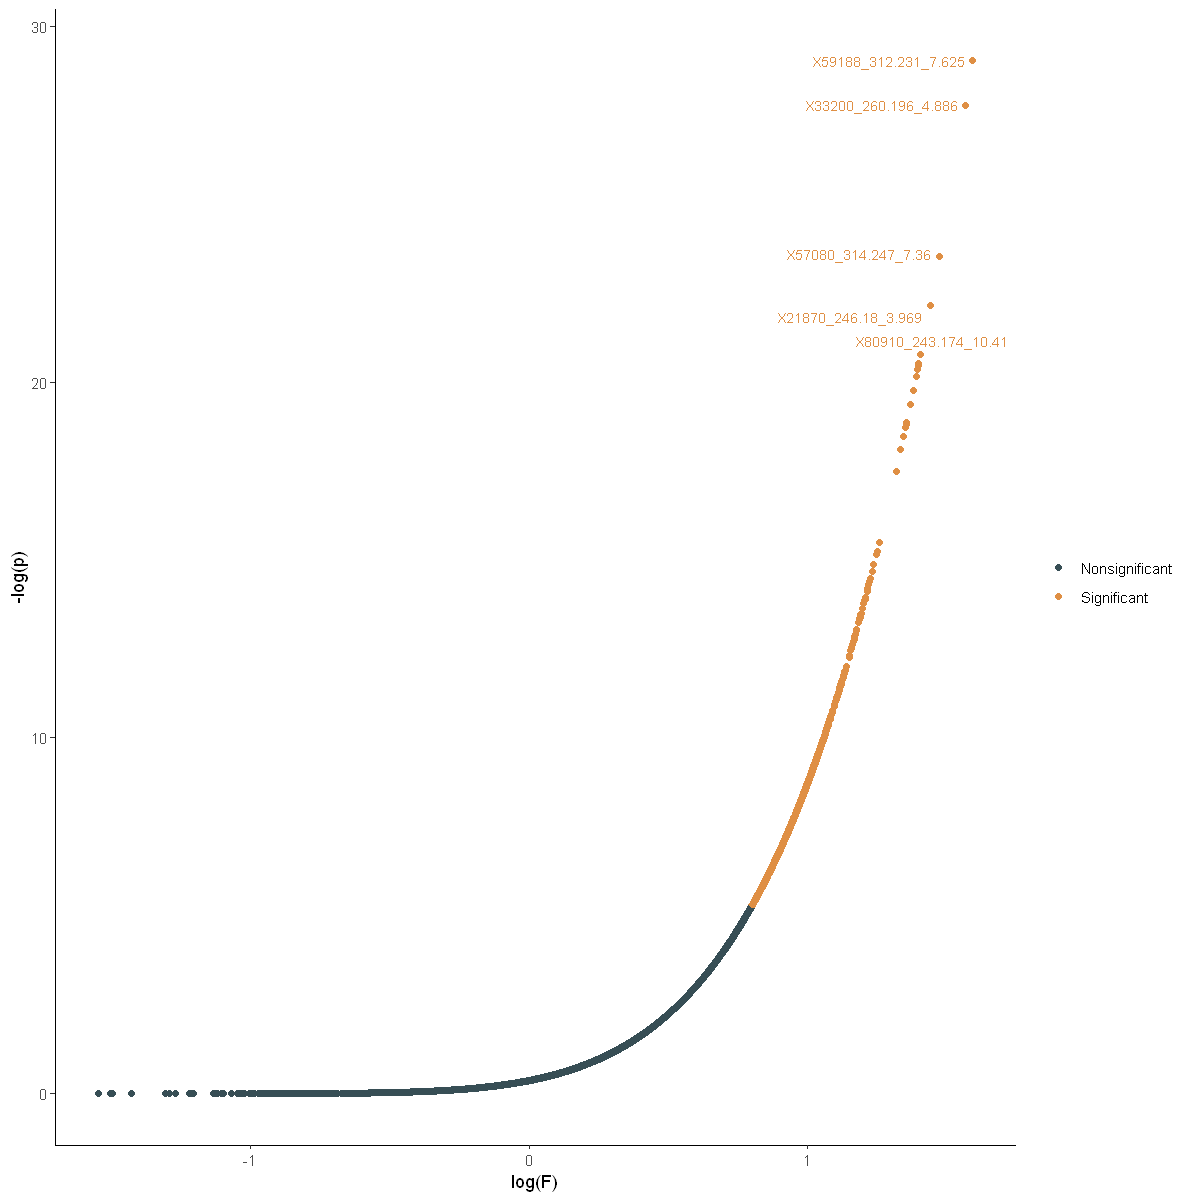

In [290]:
#plot ANOVA results
plot_anova <- ggplot(op_aov,aes(x=log(F,base=10),y=-log(p,base=10),color=significant))+ 
geom_point()+ theme_classic()+ scale_color_jama()+ ylab("-log(p)")+ xlab("log(F)")+
geom_text_repel(data=op_aov %>% arrange(p) %>% slice_head(n=5),
                  aes(label=Metabolites),size=3,show.legend = FALSE,max.overlaps = 100)+
theme(legend.title = element_blank())

plot_anova

The ANOVA only tests if the between group variance is larger than the within group variance. This means that the results only show you whether there are groupwise differences in metabolite levels, but do not show you which pair-wise group comparison are driving this difference. This can be furhter explored using Tukey's Honestly Significant Difference, which is explored further down.

If you want, you can also export the plots to a pdf

In [ ]:
pdf("plot_ANOVA.pdf")
plot_anova
dev.off()

Or as a csv-file

In [ ]:
write.csv(op_aov,"ANOVA_results.csv")

Show boxplot of the four metabolites with lowest p-value, in order to visualize how these particular metabolites differ between sampling sites

In [291]:
sig_4 <- op_aov %>% arrange (p) %>% slice_head(n=4) %>% pull(Metabolites) #getting the names of first 4 significant metabolites
sig_4

[1] "X59188_312.231_7.625" "X33200_260.196_4.886" "X57080_314.247_7.36" 
[4] "X21870_246.18_3.969"

In [292]:
b <- list() # creating an empty list to store the boxplot of each metabolite as an element [[i]]
for(i in 1:4){
    b[[i]] <- ggplot(Data,aes(x=ATTRIBUTE_Sample_Area,
                              y=Data[,(sig_4[i])], # this will get the corresponding column from the dataframe 'Data'
                              color=ATTRIBUTE_Sample_Area))+
    geom_boxplot() + 
    scale_color_jama() +  # specifying the 'journal-friendly' color palette
    labs(x='ATTRIBUTE Sample Area',y=as.character(sig_4[i])) + #labelling the axes
    theme_classic() + # white background theme
    geom_jitter() + #adds some random variation to each point location to avoid overfitting
    theme(axis.text.x= element_blank()) #removing the x axis labels for each boxplot in a plot
}

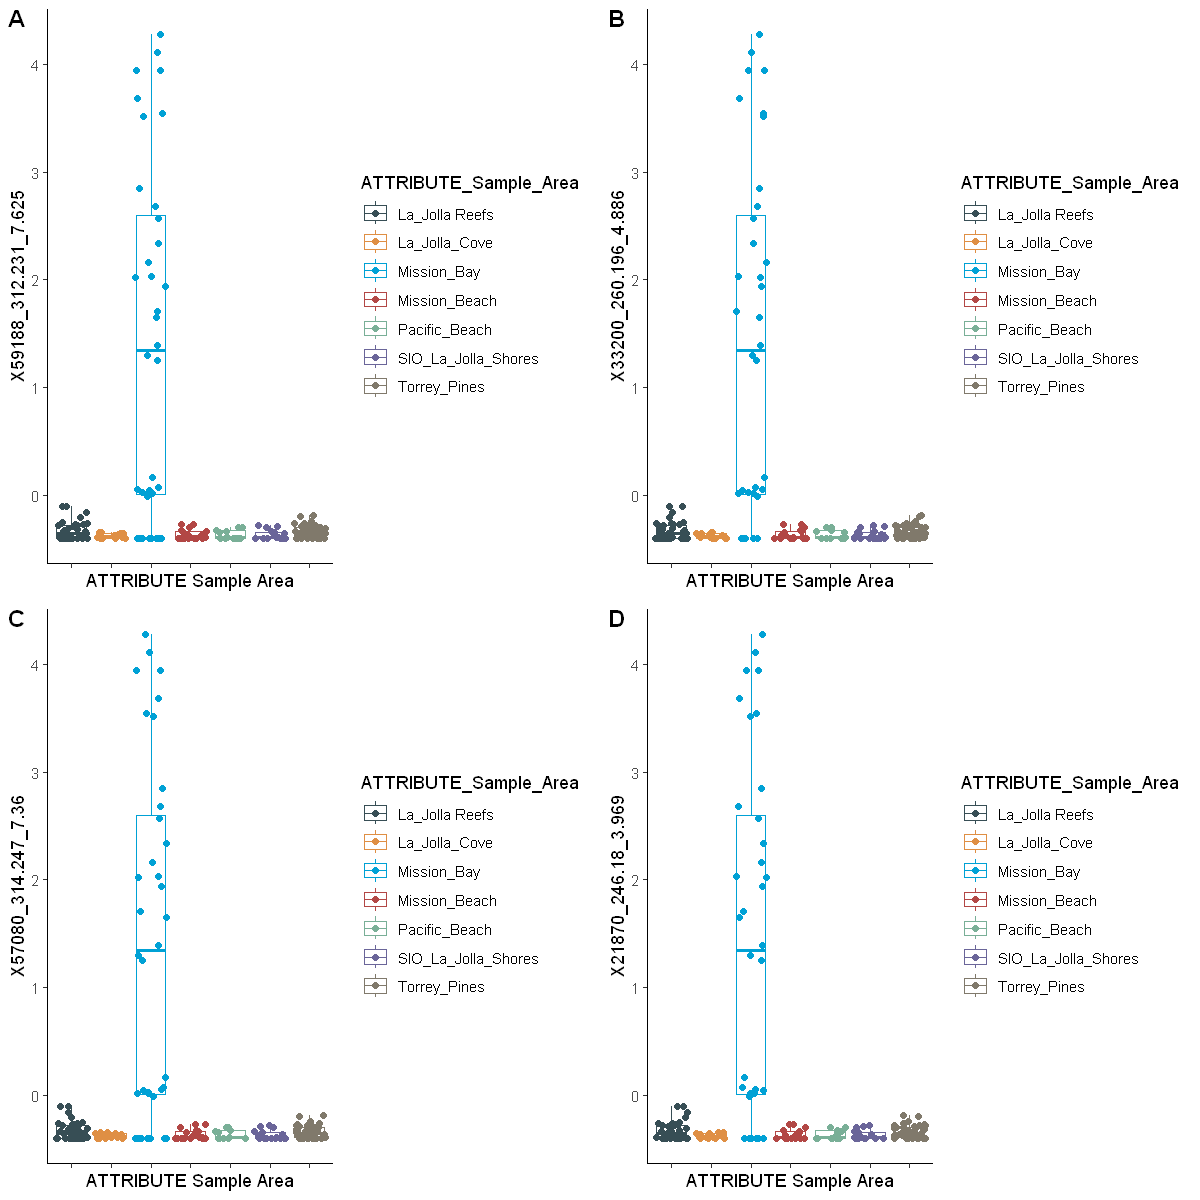

In [293]:
combined_boxplots <- plot_grid(b[[1]],b[[2]],b[[3]],b[[4]], labels = c('A','B','C','D'))
combined_boxplots

Write boxplot of top 4 metabolites to pdf

In [294]:
ggsave("combined_boxplots.pdf",combined_boxplots,height = 9,width = 16)

For the top four metabolites, Mission bay is the area that drives the difference between sampling sites, with much higher levels. 

## <font color ='darkblue'> 4.2 Test for normality </font>
<a id="norm_test"></a>

Parametric statistical tests, such as t-tests and ANOVA, assume normally distributed variables. We perform both visual and statistical tests to investigate whether metabolite features in the present dataset are normally distributed. <br>
We start by inspecting a histogram of the first feature in the dataset:

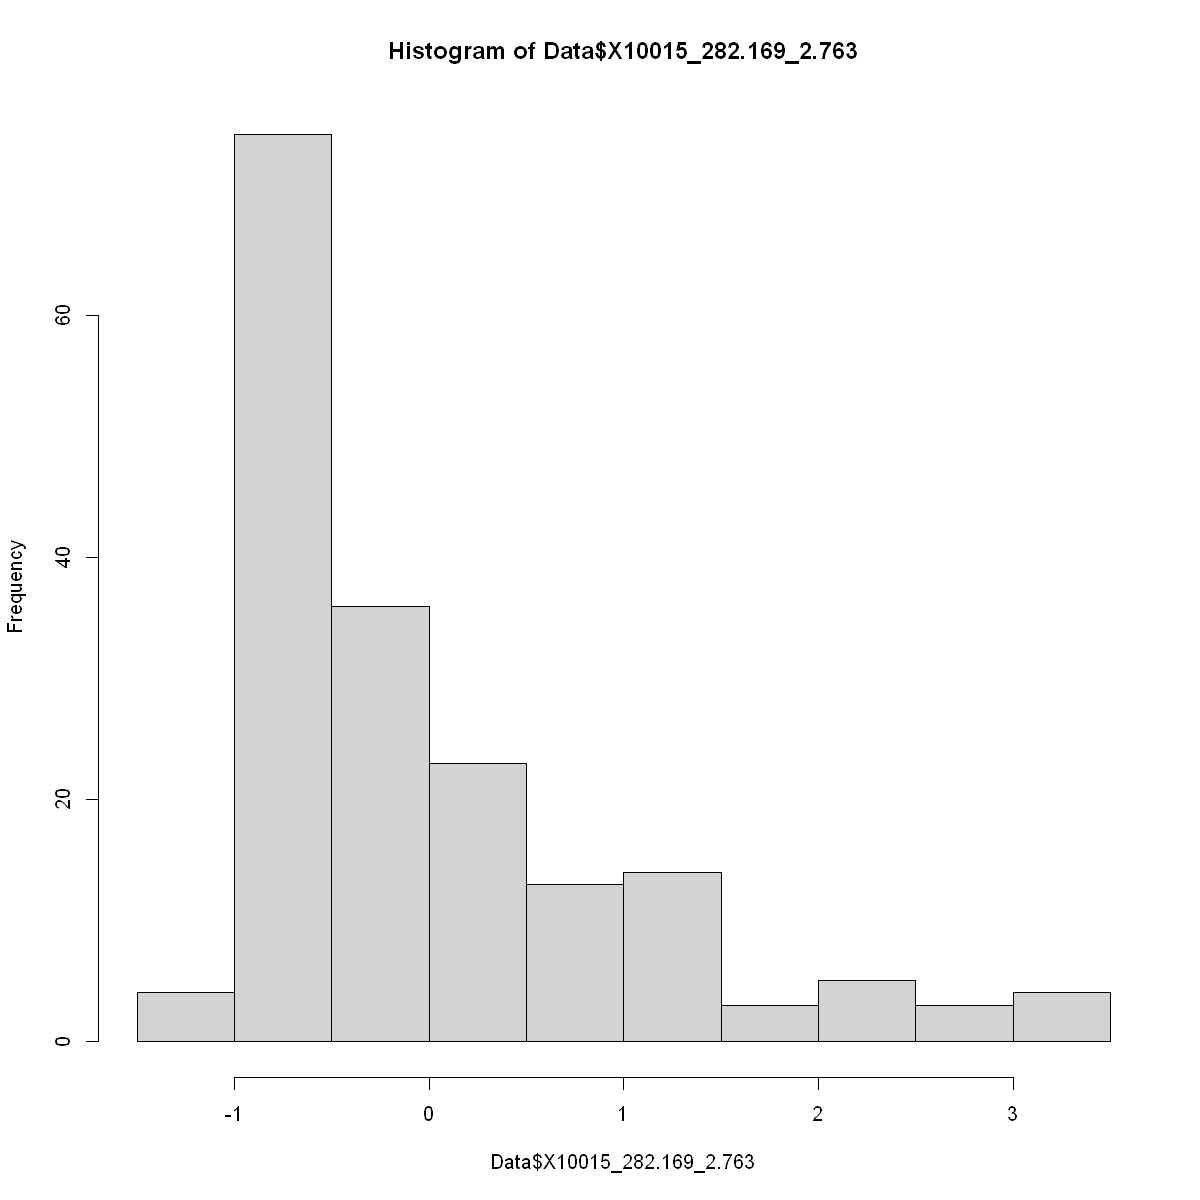

In [295]:
hist(Data$'X10015_282.169_2.763')

We can also visualize this using a quantile-quantile plot (Q-Q plot), which plots observed distribution against a theoretical normal distribution. A linear relation between the two (points follow the line), the investigated variable follows a normal distribution

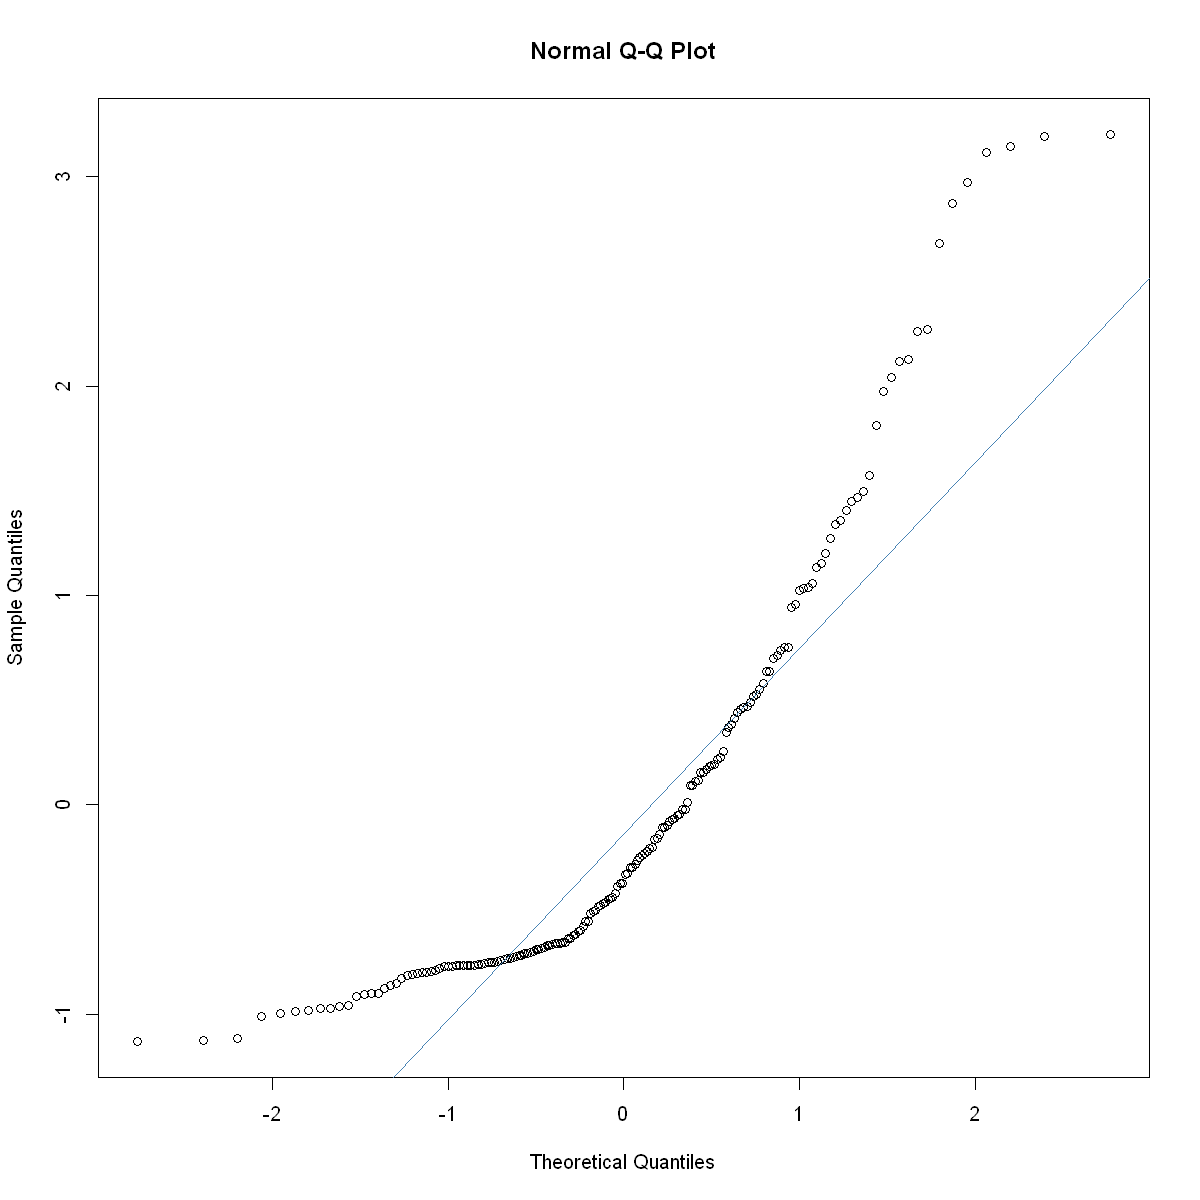

In [296]:
qqnorm(Data$'X10015_282.169_2.763')
qqline(Data$'X10015_282.169_2.763', col = "steelblue")

Finally, we can test for noramlity using a statistical test (Shapiro-Wilks test for normality). The null hypothesis is that the sample distribution is normal, i.e a significant p-value indicates a non-normal distribution

In [297]:
shapiro.test(Data$'X10015_282.169_2.763')


	Shapiro-Wilk normality test

data:  Data$X10015_282.169_2.763
W = 0.83361, p-value = 4.636e-13


All of the above, indicate that the first variable in our dataset follows a non-normal distribution. <br>
We can now systematically investigate all metabolite features in the dataset for normallity:

In [298]:
a <- start:ncol(Data)

op_shapiro <- data.frame(colnames(Data[start:ncol(Data)]))
colnames(op_shapiro)[1] <- "Metabolites"
op_shapiro$p <- sapply(1:length(a),function(n){shapiro.test(Data[,a[n]])$p})
op_shapiro$p_adj <- p.adjust(op_shapiro$p,method="fdr")
op_shapiro$distribution <- ifelse(op_shapiro$p_adj<0.05,"Non-normal","Normal")

In [299]:
op_shapiro %>% arrange(p) %>% head(n=10)

,Metabolites,p,p_adj,distribution
,<chr>,<dbl>,<dbl>,<chr>
1,X84985_565.566_10.884,4.371118e-29,9.78941e-27,Non-normal
2,X84649_587.548_10.842,4.461996e-29,9.78941e-27,Non-normal
3,X90897_792.441_12.493,4.506668e-29,9.78941e-27,Non-normal
4,X90643_508.544_12.391,4.534865e-29,9.78941e-27,Non-normal
5,X90847_793.442_12.473,4.599743e-29,9.78941e-27,Non-normal
6,X89262_866.459_11.971,4.662842e-29,9.78941e-27,Non-normal
7,X88315_548.345_11.623,4.759355e-29,9.78941e-27,Non-normal
8,X90496_537.579_12.338,4.761122e-29,9.78941e-27,Non-normal
9,X90898_794.44_12.493,4.817085e-29,9.78941e-27,Non-normal


In [300]:
sum(op_shapiro$distribution=="Normal")

[1] 54

## <font color ='darkblue'> 4.3 Kruskall-Wallis </font>
<a id="kr_wallis"></a>

We will test whether metabolite levels were different between different sampling sites, where seven different sampling areas will be compared. We  use the function aov to run statistical analyses using ANOVA. Since one ANOVA is being run for each metabolite feature, we run the analyses in a loop and save the output for each feature in a list called anova_out.<br>

The vector a indicates which columns in the dataset are features (i.e. from "start" to the last column of the data frame). <br>

We can run a for loop to pass each feature column into the first argument of the aov function, while the second argument, time point, is constant.

In [301]:
kruskall_out=NULL
a <- start:ncol(Data) #We use the start variable to indicate where metabolite data starts in the data frame
for (i in 1:length(a)){
  kruskall_out[[i]] <- kruskal.test(scale(Data[,a[i]])~as.factor(Data$'ATTRIBUTE_Sample_Area'))
}

kruskall_out[[1]] #show the first entry in the list
summary(anova_out[[1]]) # compare with results from ANOVA


	Kruskal-Wallis rank sum test

data:  scale(Data[, a[i]]) by as.factor(Data$ATTRIBUTE_Sample_Area)
Kruskal-Wallis chi-squared = 6.007, df = 6, p-value = 0.4224


                                       Df Sum Sq Mean Sq F value Pr(>F)
as.factor(Data$ATTRIBUTE_Sample_Area)   6   7.56   1.260   1.272  0.273
Residuals                             173 171.44   0.991               

For the first feature, the results from the ANOVA and Kruskall-Wallis are similar.

In [302]:
#extract p- and F-values from ANOVA output list
op_KW <- data.frame(colnames(Data[start:ncol(Data)]))
colnames(op_KW)[1] <- "Metabolites"
op_KW["p"] <- sapply(1:length(a),function(n){kruskall_out[[n]][[3]]})
op_KW["p_bonferroni"] <- p.adjust(op_KW$p,method="bonferroni")
op_KW["significant"]  <- ifelse(op_KW$p_bonferroni<0.05,"Significant","Nonsignificant")
op_KW["chsq"] <- sapply(1:length(a),function(n){kruskall_out[[n]][[1]]})

In [303]:
op_KW %>% arrange(p) %>% head(n=10)

,Metabolites,p,p_bonferroni,significant,chsq
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,X91372_906.258_12.697,6.945518e-22,6.314865e-18,Significant,112.23221
2,X91133_907.259_12.628,2.875768e-21,2.614649e-17,Significant,109.28611
3,X90743_908.258_12.555,2.902660e-21,2.639098e-17,Significant,109.26681
4,X90597_906.258_12.403,1.643008e-20,1.493823e-16,Significant,105.66838
5,X92112_906.258_12.941,7.149453e-20,6.500283e-16,Significant,102.61222
6,X90429_907.259_12.326,3.154168e-19,2.867769e-15,Significant,99.52385
7,X89945_906.258_12.064,1.467686e-16,1.334420e-12,Significant,86.69845
8,X80910_243.174_10.41,4.451389e-16,4.047203e-12,Significant,84.37319
9,X10485_193.119_2.895,4.132066e-15,3.756874e-11,Significant,79.69425


In [304]:
op_aov_kw <- merge(op_aov,op_KW,by="Metabolites")

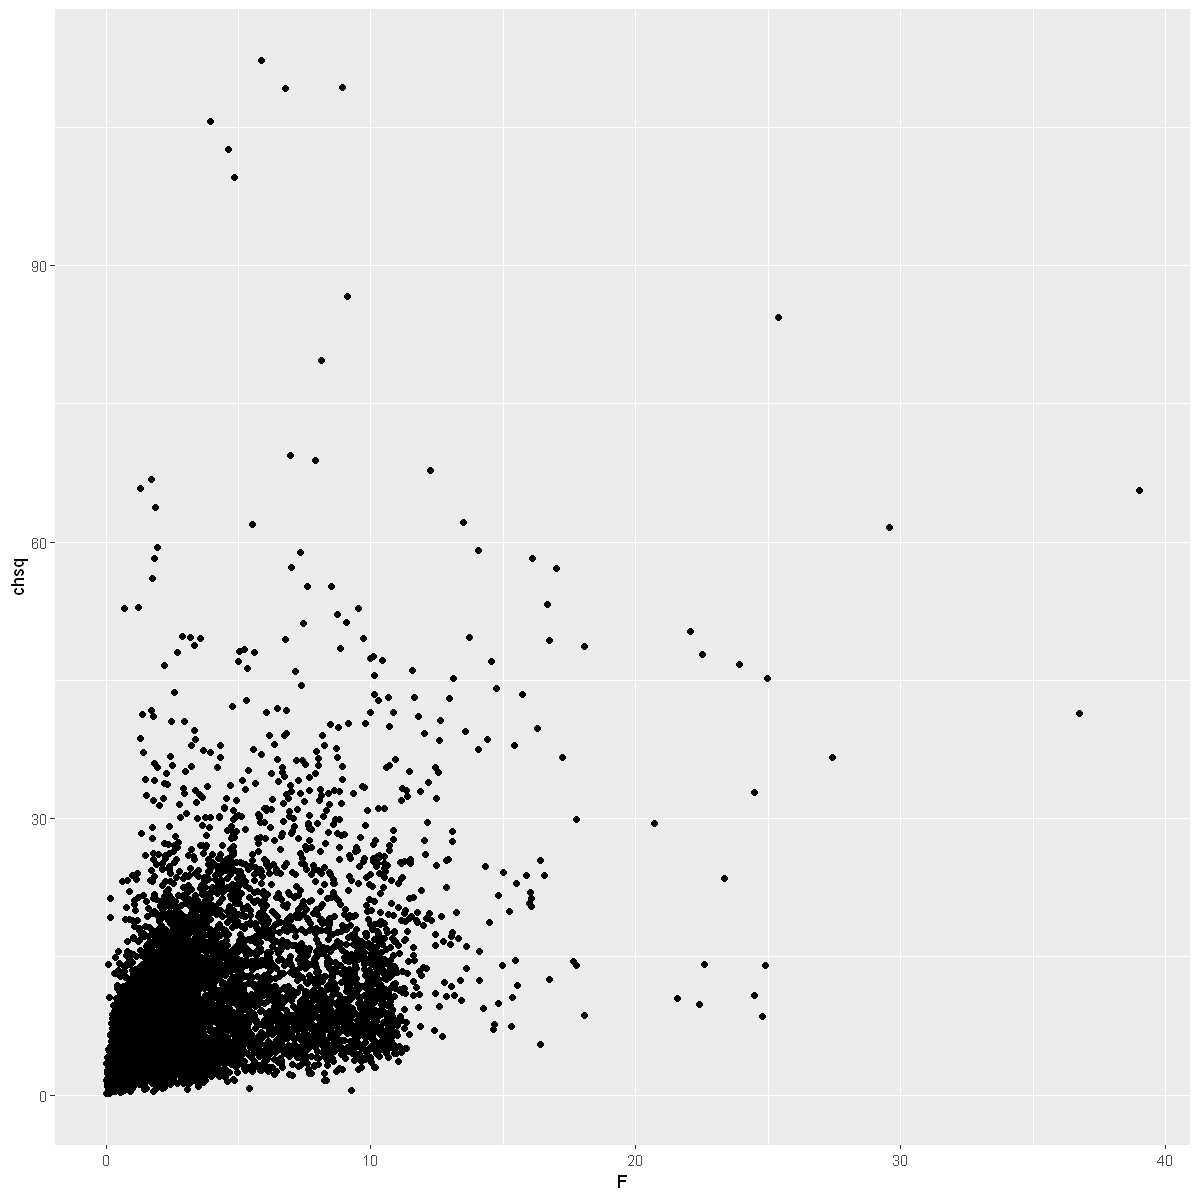

In [305]:
ggplot(op_aov_kw,aes(x=F,y=chsq))+
  geom_point()

In [306]:
cor(op_aov_kw$F,op_aov_kw$chsq,method="spearman")

[1] 0.5781331

## <font color ='darkblue'> 4.4 Tukey's post hoc test </font>
<a id ="tukey"></a>

As mentioned above, Tukey's post hoc test can be used to calculate, which features show statistically significant differences between individual sampling sites. The function TukeyHSD is used, which calculates these differences from the ANOVA output list previously generated. Results are stored in a new list called tukey_out.

In [307]:
#Tukey_output:
tukey_out=NULL
for (i in 1:length(a)){
tukey_out[[i]] <- TukeyHSD(anova_out[[i]])
}

tukey_out[[1]]$`as.factor(Data$'ATTRIBUTE_Sample_Area')` #shows the first entry of the list to show that all group wise differences are calculated.

NULL

We can show the results from a single entry in the list

In [308]:
tukey_out[[8]]$`as.factor(Data$ATTRIBUTE_Sample_Area)`

,diff,lwr,upr,p adj
La_Jolla_Cove-La_Jolla Reefs,0.064097151,-0.8296322,0.9578265,9.999918e-01
Mission_Bay-La_Jolla Reefs,1.210051203,0.5780891,1.8420133,9.911987e-07
Mission_Beach-La_Jolla Reefs,-0.008723713,-0.7827160,0.7652686,1.000000e+00
Pacific_Beach-La_Jolla Reefs,-0.063585458,-0.9573148,0.8301439,9.999922e-01
SIO_La_Jolla_Shores-La_Jolla Reefs,0.005684983,-0.7683073,0.7796773,1.000000e+00
Torrey_Pines-La_Jolla Reefs,0.178740818,-0.4124056,0.7698872,9.718359e-01
Mission_Bay-La_Jolla_Cove,1.145954053,0.2522247,2.0396834,3.392065e-03
Mission_Beach-La_Jolla_Cove,-0.072820863,-1.0720406,0.9263989,9.999910e-01
Pacific_Beach-La_Jolla_Cove,-0.127682609,-1.2222730,0.9669078,9.998552e-01
SIO_La_Jolla_Shores-La_Jolla_Cove,-0.058412168,-1.0576320,0.9408076,9.999976e-01


Every possible pair-wise group difference is explored. Since Mission Bay seemed to differ from other sampling sites for the four most significant metabolites, we could specifically look at the results from comparison between Mission Bay and another sampling site. In the example below we look at the differences between Mission Bay and La Jolla Reefs.

We extract the information we are interested in from tukey_out. For instance, the differences Mission bay and La Jolla Reefs:

- diff - Difference in average levels between Mission Bay and La Jolla Reefs
- p - p-value for group-wise difference after taking multiple group-wise comparisons into account.
- p_bonferroni - adjusted p-value after taking multiple tests (N number of features) into account
- significant - Whether the corrected p-value is below 0.05

In [309]:
#Extracting info for the tukey plot:
output_tukey <- data.frame(colnames(Data[start:ncol(Data)]))
colnames(output_tukey)[1] <- "Metabolites"
output_tukey$ID <- colnames(Data)[start:ncol(Data)]
output_tukey["diff"] <- sapply(1:length(a),function(n){tukey_out[[n]]$`as.factor(Data$ATTRIBUTE_Sample_Area)`[2,1]})
output_tukey["p"] <- sapply(1:length(a),function(n){tukey_out[[n]]$`as.factor(Data$ATTRIBUTE_Sample_Area)`[2,4]})
output_tukey["p_bonferroni"] <- p.adjust(output_tukey$p,method="bonferroni")
output_tukey["significant"] <- ifelse(output_tukey$p_bonferroni<0.05,"Significant","Nonsignificant")

Display the top results. Any significant findings? Other impressions?

In [310]:
output_tukey %>% arrange(p) %>% slice_head(n=10)

Metabolites,ID,diff,p,p_bonferroni,significant
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
X33200_260.196_4.886,X33200_260.196_4.886,1.829682,0.000000e+00,0.000000e+00,Significant
X59188_312.231_7.625,X59188_312.231_7.625,1.900977,0.000000e+00,0.000000e+00,Significant
X57080_314.247_7.36,X57080_314.247_7.36,1.777045,3.275158e-14,2.977774e-10,Significant
X55328_312.232_7.138,X55328_312.232_7.138,1.703309,4.274359e-14,3.886247e-10,Significant
X21870_246.18_3.969,X21870_246.18_3.969,1.719871,4.496403e-14,4.088130e-10,Significant
X13982_232.202_3.272,X13982_232.202_3.272,1.671664,4.529710e-14,4.118412e-10,Significant
X37281_272.164_5.298,X37281_272.164_5.298,1.676595,4.540812e-14,4.128506e-10,Significant
X47253_300.195_6.208,X47253_300.195_6.208,1.680497,4.785061e-14,4.350578e-10,Significant
X36504_214.191_5.227,X36504_214.191_5.227,1.717931,4.873879e-14,4.431331e-10,Significant


Create a volcano plot that displays -log(p) on the y-axis and group-difference on the x-axis. Again, display names of top findings in the plot

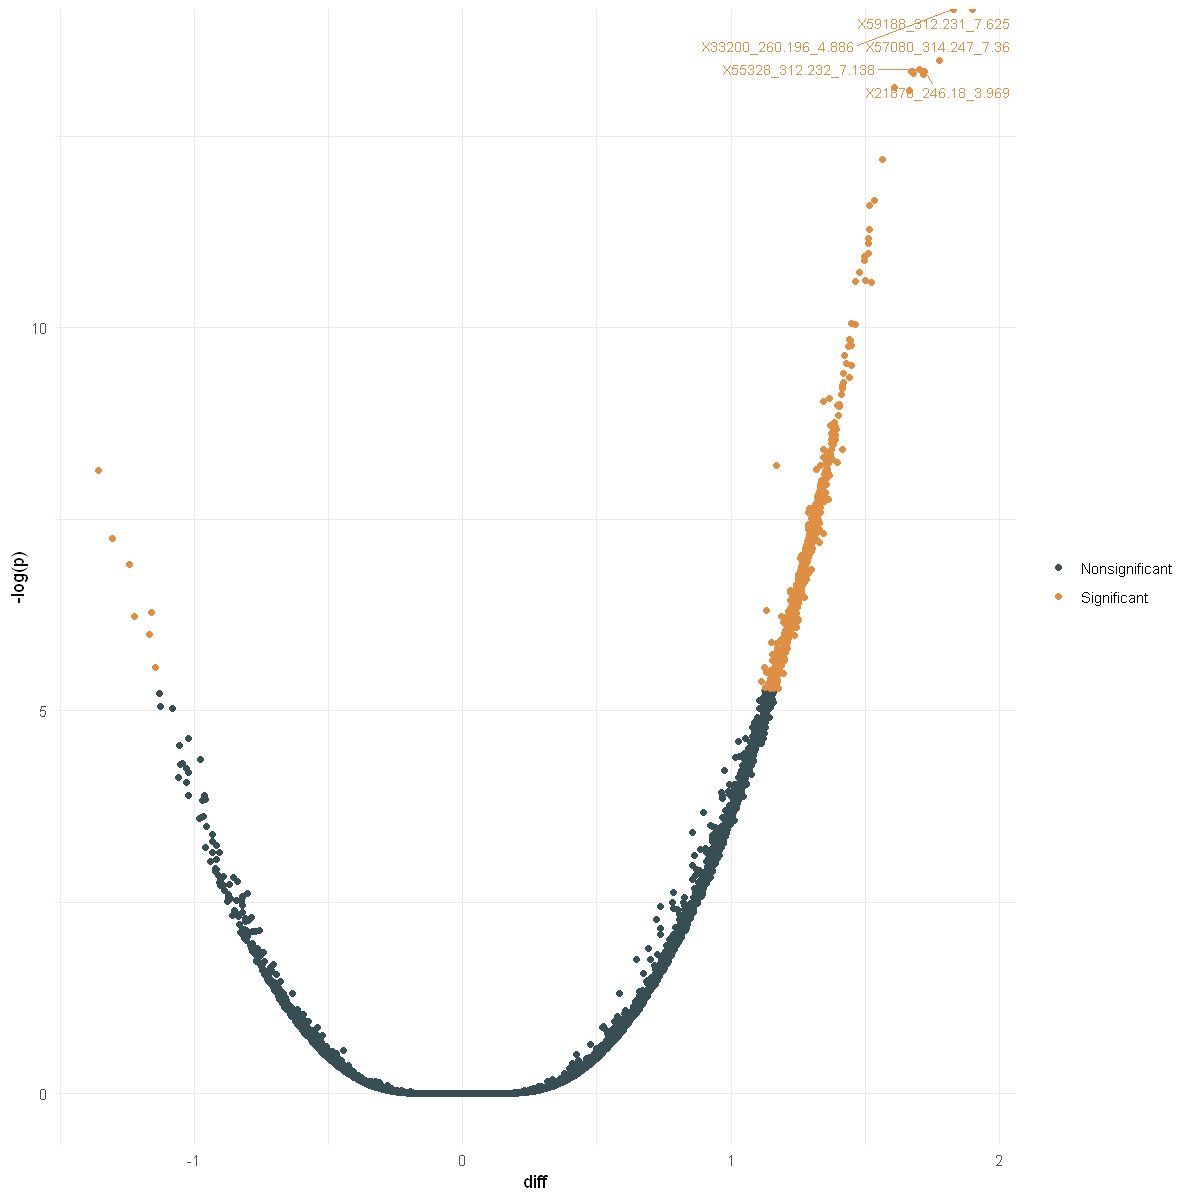

In [311]:
plot_tukey <- ggplot(output_tukey,aes(x=diff,y=-log(p,base=10),color=significant))+ 
              geom_point()+ theme_minimal()+ scale_color_jama()+ ylab("-log(p)") +
              geom_text_repel(data=output_tukey %>% arrange(p) %>% slice_head(n=5),
                aes(label=Metabolites),size=3,show.legend = FALSE,max.overlaps = 100) +
              theme(legend.title = element_blank())

plot_tukey

Export the plot as a pdf-file and the output as a csv.

In [ ]:
pdf("TukeyHSD_MissionBayLaJollaReefs.pdf")
plot_tukey
dev.off()

write.csv(output_tukey,"TukeyHSD_output.csv")

## <font color ='darkblue'> 4.5 Dunn's post hoc test </font>
<a id ="dunn"></a>

As mentioned above, Dunn's post hoc test can be used to calculate, which features show statistically significant differences between individual sampling sites. The function TukeyHSD is used, which calculates these differences from the Kruskall-Wallis output list previously generated. Results are stored in a new list called dunn_out.

In [312]:
#Dunn output:
dunn_out=NULL
for (i in 1:length(a)){
dunn_out[[i]] <- dunnTest(Data[,a[i]],as.factor(Data$`ATTRIBUTE_Sample_Area`),method="bonferroni")
}

In [313]:
#Extracting info for the Dunn plot:
op_dunn <- data.frame(colnames(Data[start:ncol(Data)]))
colnames(op_dunn)[1] <- "Metabolites"
op_dunn$ID <- colnames(Data)[start:ncol(Data)]
op_dunn["Z"] <- sapply(1:length(a),function(n){dunn_out[[n]]$res$Z[2]})
op_dunn["p"] <- sapply(1:length(a),function(n){dunn_out[[n]]$res$P.adj[2]})
op_dunn["p_bonferroni"] <- p.adjust(op_dunn$p,method="bonferroni")
op_dunn["significant"] <- ifelse(op_dunn$p_bonferroni<0.05,"Significant","Nonsignificant")

In [314]:
op_dunn %>% arrange(p) %>% head(n=5)

,Metabolites,ID,Z,p,p_bonferroni,significant
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,X57080_314.247_7.36,X57080_314.247_7.36,-6.790999,2.338561e-10,2.126220e-06,Significant
2,X60583_506.326_7.811,X60583_506.326_7.811,-6.600999,8.576338e-10,7.797606e-06,Significant
3,X59188_312.231_7.625,X59188_312.231_7.625,-6.468715,2.075640e-09,1.887172e-05,Significant
4,X82124_413.268_10.607,X82124_413.268_10.607,-6.194994,1.224035e-08,1.112892e-04,Significant
5,X54129_381.808_6.99,X54129_381.808_6.99,-5.919286,6.790193e-08,6.173644e-04,Significant


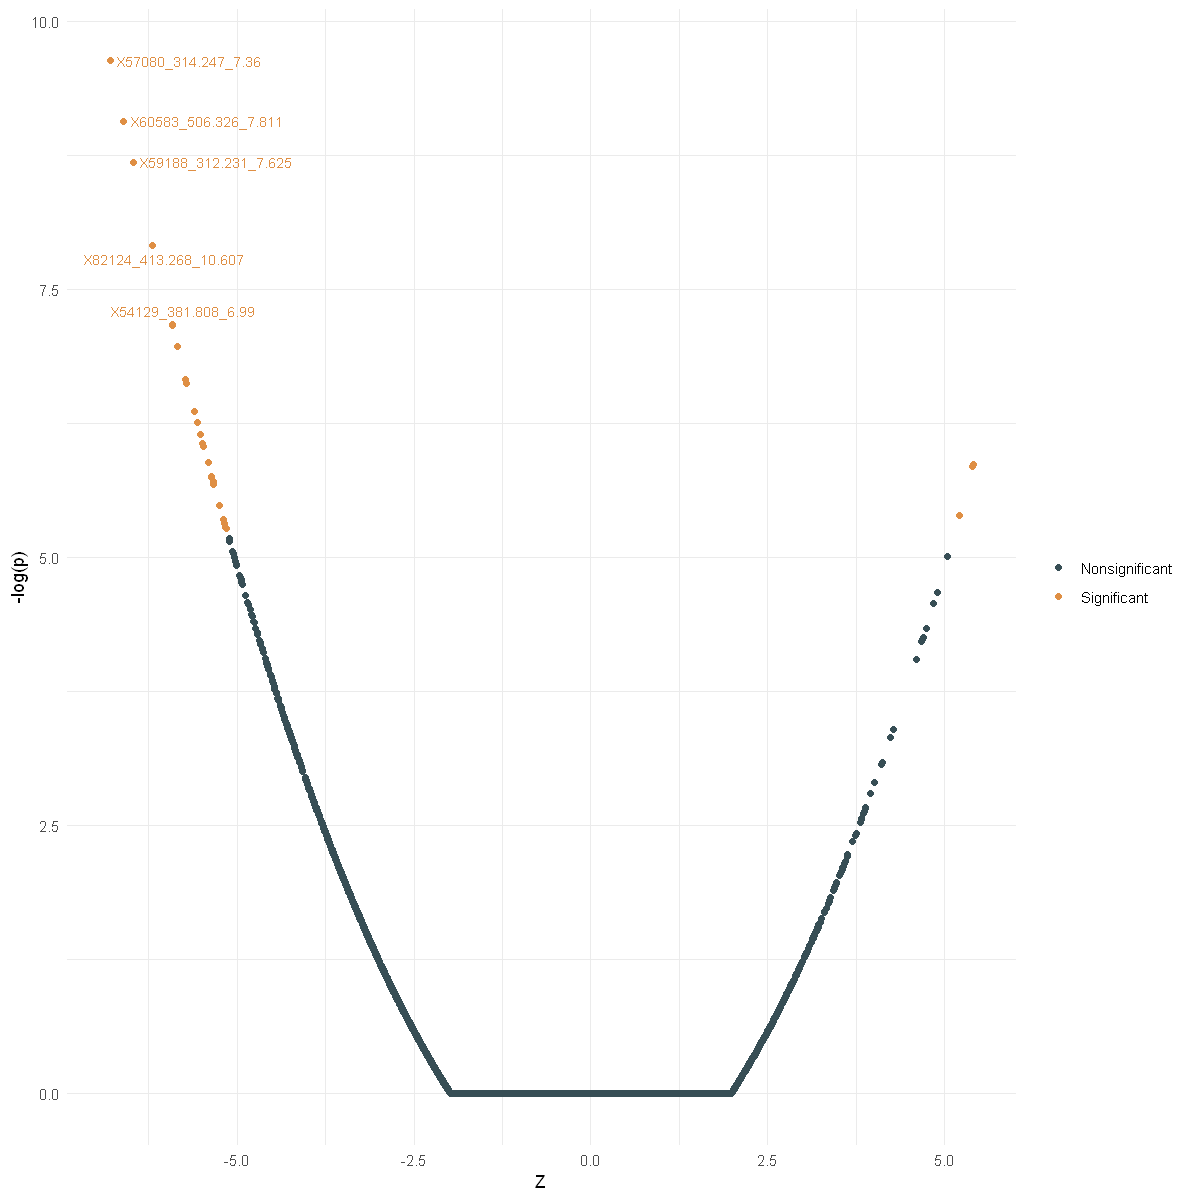

In [315]:
plot_dunn <- ggplot(op_dunn,aes(x=Z,y=-log(p,base=10),color=significant))+ 
              geom_point()+ theme_minimal()+ scale_color_jama()+ ylab("-log(p)") +
              geom_text_repel(data=op_dunn %>% arrange(p) %>% slice_head(n=5),
                aes(label=Metabolites),size=3,show.legend = FALSE,max.overlaps = 100) +
              theme(legend.title = element_blank())

plot_dunn

## <font color ='darkblue'> 4.6 Linear regression analysis </font>
<a id="lin_reg"></a>

We will now explore whether there is a gradual shift in the metabolome along the coast (south to north). Linear regression models can be used to see if there is an association between metabolites and the lattitude. Month of sampling will also be used as a covariate in order to adjust for potential temporal differences in sampling along the coast. 

In [316]:
lm_lat = NULL
for (i in 1:length(a)){
  lm_lat[[i]] <- lm(Data$ATTRIBUTE_Latitude~Data[,a[i]]+Data$ATTRIBUTE_Month)
}

In [317]:
output_lm <- data.frame(colnames(Data[start:ncol(Data)]))
colnames(output_lm)[1] <- "Metabolites"
output_lm$beta <- sapply(1:length(a),function(n){coef(lm_lat[[n]])[2]})
output_lm$lowint <- sapply(1:length(a),function(n){confint.default(lm_lat[[n]])[2,1]})
output_lm$highint <- sapply(1:length(a),function(n){confint.default(lm_lat[[n]])[2,2]})
output_lm$p <- sapply(1:length(a),function(n){summary(lm_lat[[n]])$coefficients[2,4]})
output_lm["p_bonferroni"] <- p.adjust(output_lm$p,method="bonferroni")
output_lm["significant"] <- ifelse(output_lm$p_bonferroni<0.05,"Significant","Nonsignificant")

In [318]:
output_lm %>% arrange(p) %>% head(n=5)

,Metabolites,beta,lowint,highint,p,p_bonferroni,significant
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,X60937_412.165_7.857,0.07027068,0.05826083,0.08228053,4.294457e-23,3.904521e-19,Significant
2,X80910_243.174_10.41,-0.03383680,-0.04044781,-0.02722580,5.147106e-19,4.679749e-15,Significant
3,X84748_363.31_10.856,-0.03961609,-0.04778406,-0.03144812,1.484116e-17,1.349359e-13,Significant
4,X26884_218.959_4.421,0.07415510,0.05845655,0.08985365,7.115561e-17,6.469468e-13,Significant
5,X51236_576.389_6.653,0.03943761,0.03106524,0.04780997,8.377970e-17,7.617250e-13,Significant


In [319]:
volcano_lat <- ggplot(output_lm,aes(x=beta,y=-log(p,base=10),color=significant))+
  geom_point()+
  theme_classic()+
  scale_color_jama()+
  geom_vline(xintercept = 0, linetype="dashed")+
  xlab("Beta")+
  ylab("-log(p")+
  theme(legend.title = element_blank())+
  geom_text_repel(data=output_lm %>% arrange(p) %>% slice_head(n=5),
                aes(label=Metabolites),size=3,show.legend = FALSE,max.overlaps = 100)

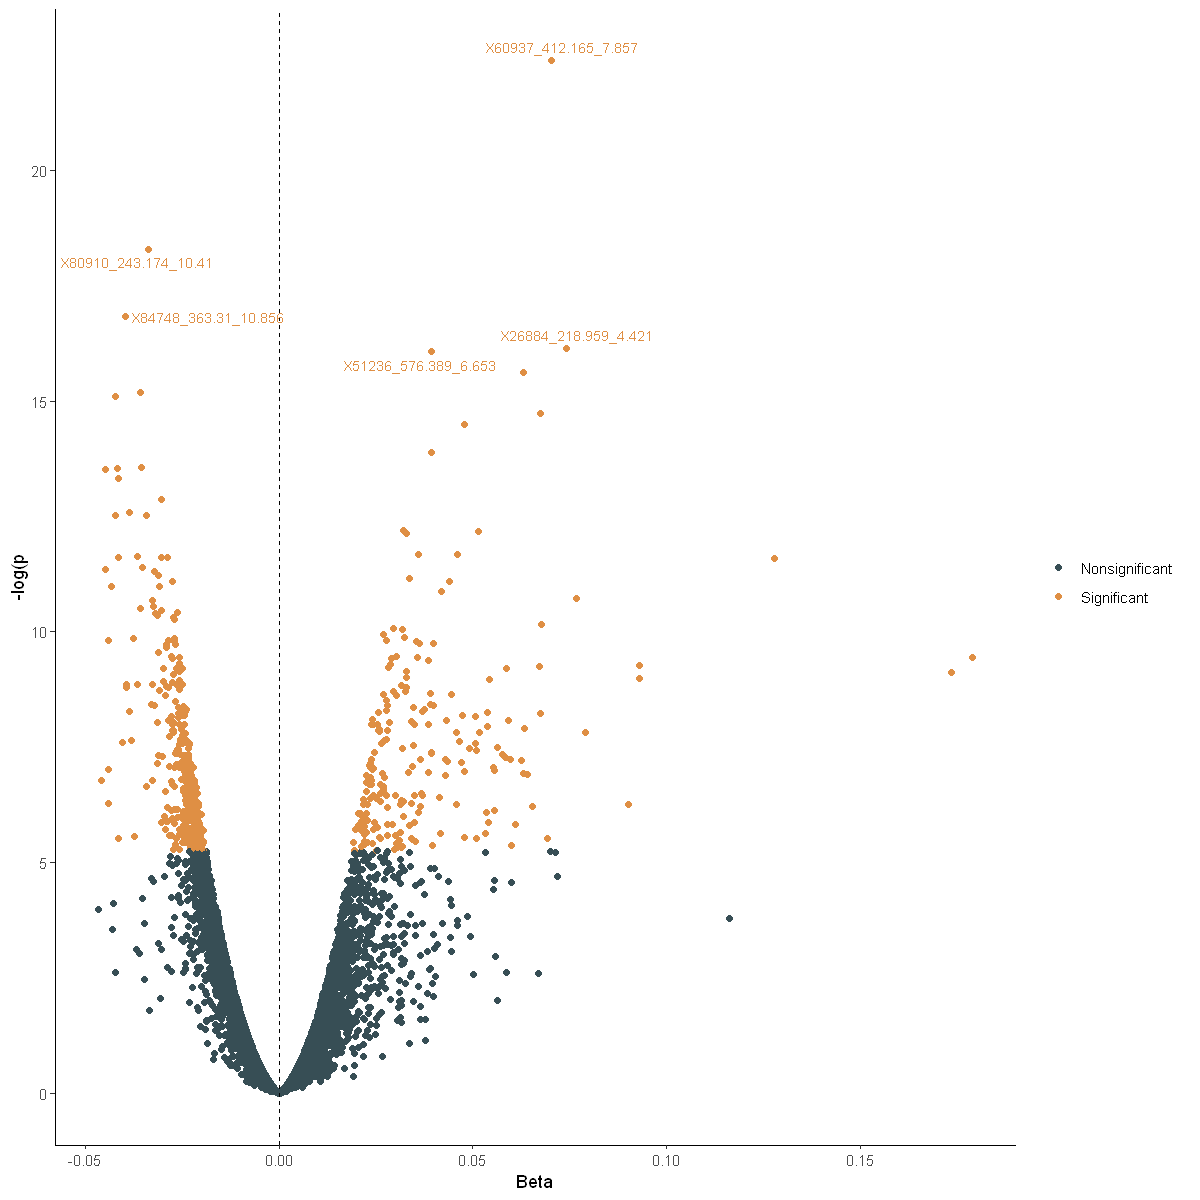

In [320]:
volcano_lat

In [ ]:
write.csv(output_lm,"rainfall_t_test.csv")
ggsave("volcano_plot_lattitude.pdf",volcano_lat)

## <font color ='darkblue'> 4.7 T-tests </font>
<a id = "t_test"></a>

A heavy rainfall in January 2018 could have influenced the metabolome. We will investigate the effect of the rainfall using t-tests.

In [321]:
Data <- Data %>% add_column(rainfall=ifelse(Data$ATTRIBUTE_Month=="Jan",1,0),.before = 10)

In [322]:
start <- which(names(Data)=="ATTRIBUTE_Injection_order")+1

In [323]:
a <- start:ncol(Data)

In [324]:
rain_out=NULL
for (i in 1:length(a)){
rain_out[[i]] <- t.test(Data[,a[i]]~Data$rainfall)
}

In [325]:
output_rainfall <- data.frame(colnames(Data[start:ncol(Data)]))
colnames(output_rainfall)[1] <- "Metabolites"
output_rainfall$mean_before <- sapply(1:length(a),function(n){rain_out[[n]]$estimate[1]})
output_rainfall$mean_after <- sapply(1:length(a),function(n){rain_out[[n]]$estimate[2]})
output_rainfall$diff <- output_rainfall$mean_after-output_rainfall$mean_before
output_rainfall$p <- sapply(1:length(a),function(n){rain_out[[n]]$p.value})
output_rainfall["p_bonferroni"] <- p.adjust(output_rainfall$p,method="bonferroni")
output_rainfall["significant"] <- ifelse(output_rainfall$p_bonferroni<0.05,"Significant","Nonsignificant")

In [328]:
output_rainfall %>% arrange(p) %>% head(n=5)

,Metabolites,mean_before,mean_after,diff,p,p_bonferroni,significant
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,X2716_252.123_1.231,-0.6418780,1.283756,1.925634,1.698330e-84,1.544122e-80,Significant
2,X4504_301.175_2.04,-0.6501167,1.300233,1.950350,7.507471e-84,6.825793e-80,Significant
3,X61401_256.19_7.915,-0.6604424,1.320885,1.981327,1.838910e-61,1.671937e-57,Significant
4,X44803_456.274_5.953,0.5787004,-1.157401,-1.736101,9.871250e-57,8.974940e-53,Significant
5,X68756_402.3_8.994,0.5526702,-1.105340,-1.658010,1.093689e-50,9.943819e-47,Significant


In [329]:
volcano_rainfall <- ggplot(output_rainfall,aes(x=diff,y=-log(p,base=10),color=significant))+
  geom_point()+
  theme_classic()+
  scale_color_jama()+
  geom_vline(xintercept = 0, linetype="dashed")+
  xlab("Beta")+
  ylab("-log(p")+
  theme(legend.title = element_blank())+
  geom_text_repel(data=output_rainfall %>% arrange(p) %>% slice_head(n=5),
                aes(label=Metabolites),size=3,show.legend = FALSE,max.overlaps = 100)

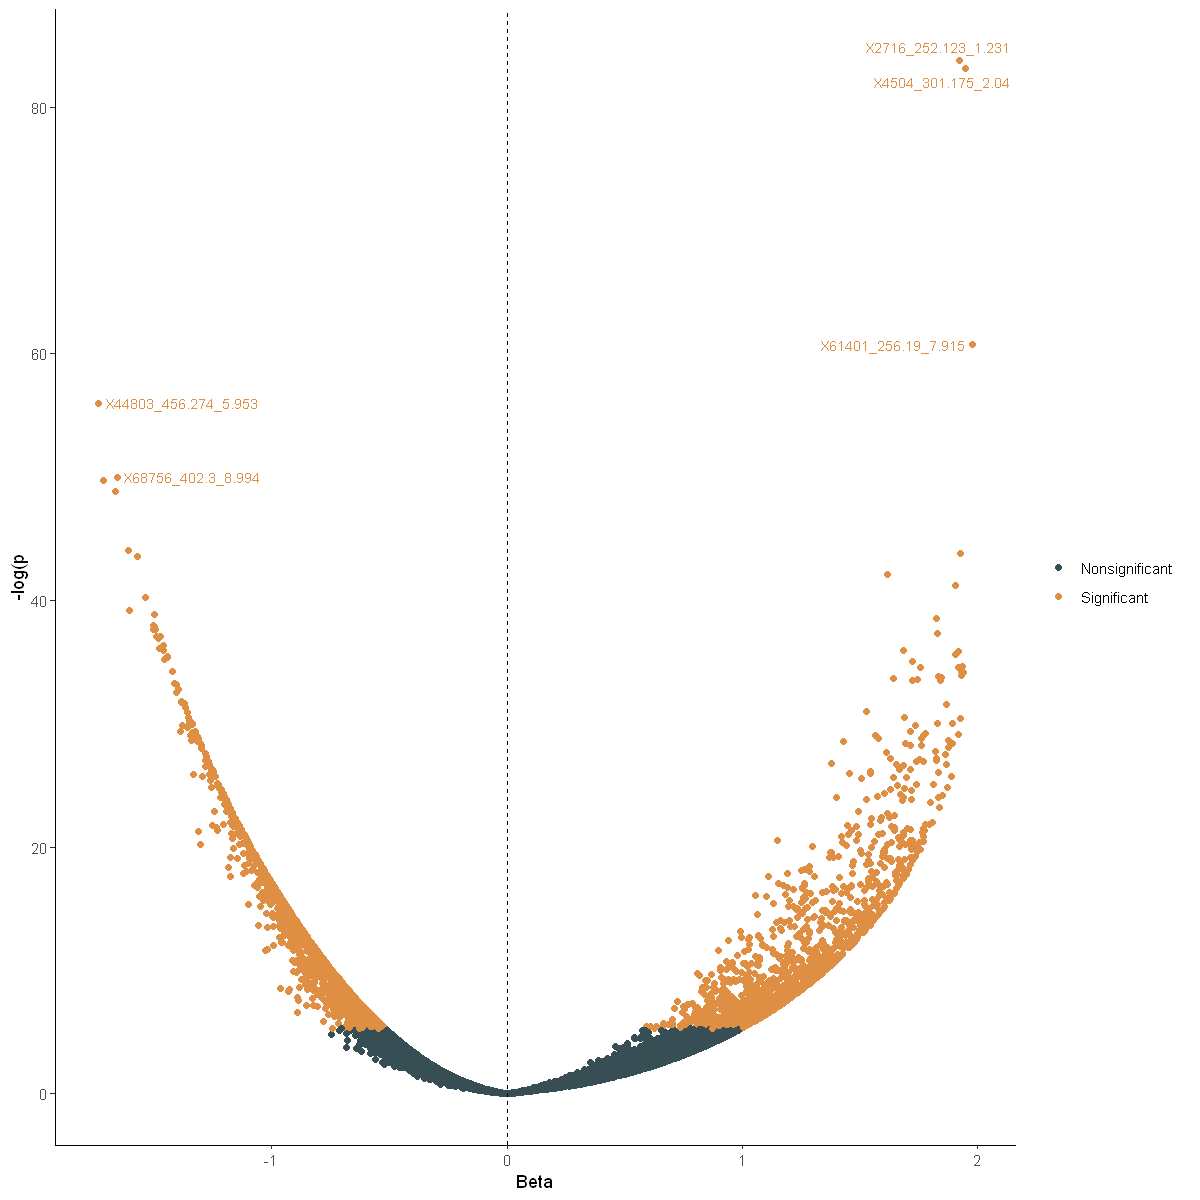

In [330]:
volcano_rainfall

In [ ]:
write.csv(output_rainfall,"rainfall_t_test.csv")
ggsave("volcano_plot_rainfall.pdf",volcano_rainfall)

## <font color ='darkblue'> 4.8 Wilcoxon's test </font>
<a id = "wilcoxon"></a>

In [331]:
wilcox_out=NULL
for (i in 1:length(a)){
wilcox_out[[i]] <-wilcox.test(Data[,a[i]]~Data$rainfall)
}

In [332]:
op_wilcox <- data.frame(colnames(Data[start:ncol(Data)]))
colnames(op_wilcox)[1] <- "Metabolites"
op_wilcox$p <- sapply(1:length(a),function(n){wilcox_out[[n]]$p.value})
op_wilcox["p_bonferroni"] <- p.adjust(op_wilcox$p,method="bonferroni")
op_wilcox["significant"] <- ifelse(op_wilcox$p_bonferroni<0.05,"Significant","Nonsignificant")

In [333]:
op_wilcox %>% arrange(p) %>% head(n=5)

,Metabolites,p,p_bonferroni,significant
,<chr>,<dbl>,<dbl>,<chr>
1,X86348_600.415_11.051,8.95658e-28,8.143323e-24,Significant
2,X86473_773.497_11.119,8.95658e-28,8.143323e-24,Significant
3,X87757_587.06_11.432,8.95658e-28,8.143323e-24,Significant
4,X89588_1129.314_12.031,8.95658e-28,8.143323e-24,Significant
5,X90455_1130.313_12.302,8.95658e-28,8.143323e-24,Significant


# <font color ='blue'> 5. Multivariate analysis </font>
<a id="multi"></a>

## <font color ='darkblue'> 5.1 PCoA PERMANOVA </font>
<a id = 'pcoa'></a>

<p style='text-align: justify;'> <b>Principal coordinates analysis (PCoA)</b> is a metric multidimensional scaling (MDS) method that attempts to represent sample dissimilarities in a low-dimensional space. It converts a distance matrix consisting of pair-wise distances (dissimilarities) across samples into a 2- or 3-D graph (<a href="https://onlinelibrary.wiley.com/doi/10.1002/0470011815.b2a13070">(Gower, 2005)</a>. Different distance metrics can be used to calculate dissimilarities among samples (e.g. Euclidean, Canberra, Minkowski). Performing a principal coordinates analysis using the Euclidean distance metric is the same as performing a principal components analysis (PCA). The selection of the most appropriate metric depends on the nature of your data and assumptions made by the metric.</p>

<p style='text-align: justify;'> Within the metabolomics field the Euclidean, Bray-Curtis, Jaccard or Canberra distances are most commonly used. The Jaccard distance is an unweighted metric (presence/absence) whereas Euclidean, Bray-Curtis and Canberra distances take into account relative abundances (weighted). Some metrics may be better suited for very sparse data (with many zeroes) than others. For example, the Euclidean distance metric is not recommended to be used for highly sparse data. </p>

This [video tutorial by StatQuest](https://www.youtube.com/watch?v=GEn-_dAyYME) summarizes nicely the basic principles of PCoA.

In order to perform a PCoA as described below, it is important that the filenames in our metadata are identical as well as in the same order as the filenames in our feature table.

In [334]:
# name rows in metadata after filenames
rownames(md_Samples) <- md_Samples$filename

In [335]:
# how many files in the metadata are also present in the feature table
table(rownames(md_Samples) %in% rownames(Imp_s))


TRUE 
 180 

Let's bring metadata and feature table samples in the same order and check whether sample names in both data tables are identical (and in the same order). The second boolean value should return TRUE.

In [336]:
identical(rownames(Imp_s),rownames(md_Samples))
# put the rows in the feature table and metadata in the same order
Imp_s <- Imp_s[match(rownames(md_Samples),rownames(Imp_s)),]
identical(rownames(Imp_s),rownames(md_Samples))

[1] TRUE

[1] TRUE

Then, we will calculate pairwise distances across all samples in our centered data using the Euclidean distance metric

In [337]:
distm <- dist(Imp_s, method = "euclidean")# compute distance

All pairwise Euclidean distances are now stored within our distance (dissimilarity) matrix (distm). The distance matrix is then used as input for the PCoA. At first, we here color samples according to the month of the year the samples were retrieved (ATTRIBUTE_Month)

In [338]:
PcoA <- cmdscale(distm, k = 2, eig = T, add = T)
PcoA_points <- as.data.frame(PcoA$points)
variance <- round(PcoA$eig*100/sum(PcoA$eig),1)
names(PcoA_points)[1:2] <- c('PCoA1', 'PCoA2')

head(PcoA_points)

,PCoA1,PCoA2
,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,-49.852728,13.65585
SD_01-2018_1_b.mzXML,-49.423128,15.97896
SD_01-2018_10_a.mzXML,-9.644539,29.77990
SD_01-2018_10_b.mzXML,-3.823113,29.57499
SD_01-2018_11_a.mzXML,-7.286396,32.38714
SD_01-2018_11_b.mzXML,-7.401341,31.90830


In [339]:
identical(rownames(PcoA_points), rownames(md_Samples))

[1] TRUE

Using the ggplot2 library, we can plot our PCoA using the Euclidean distance (=PCA).

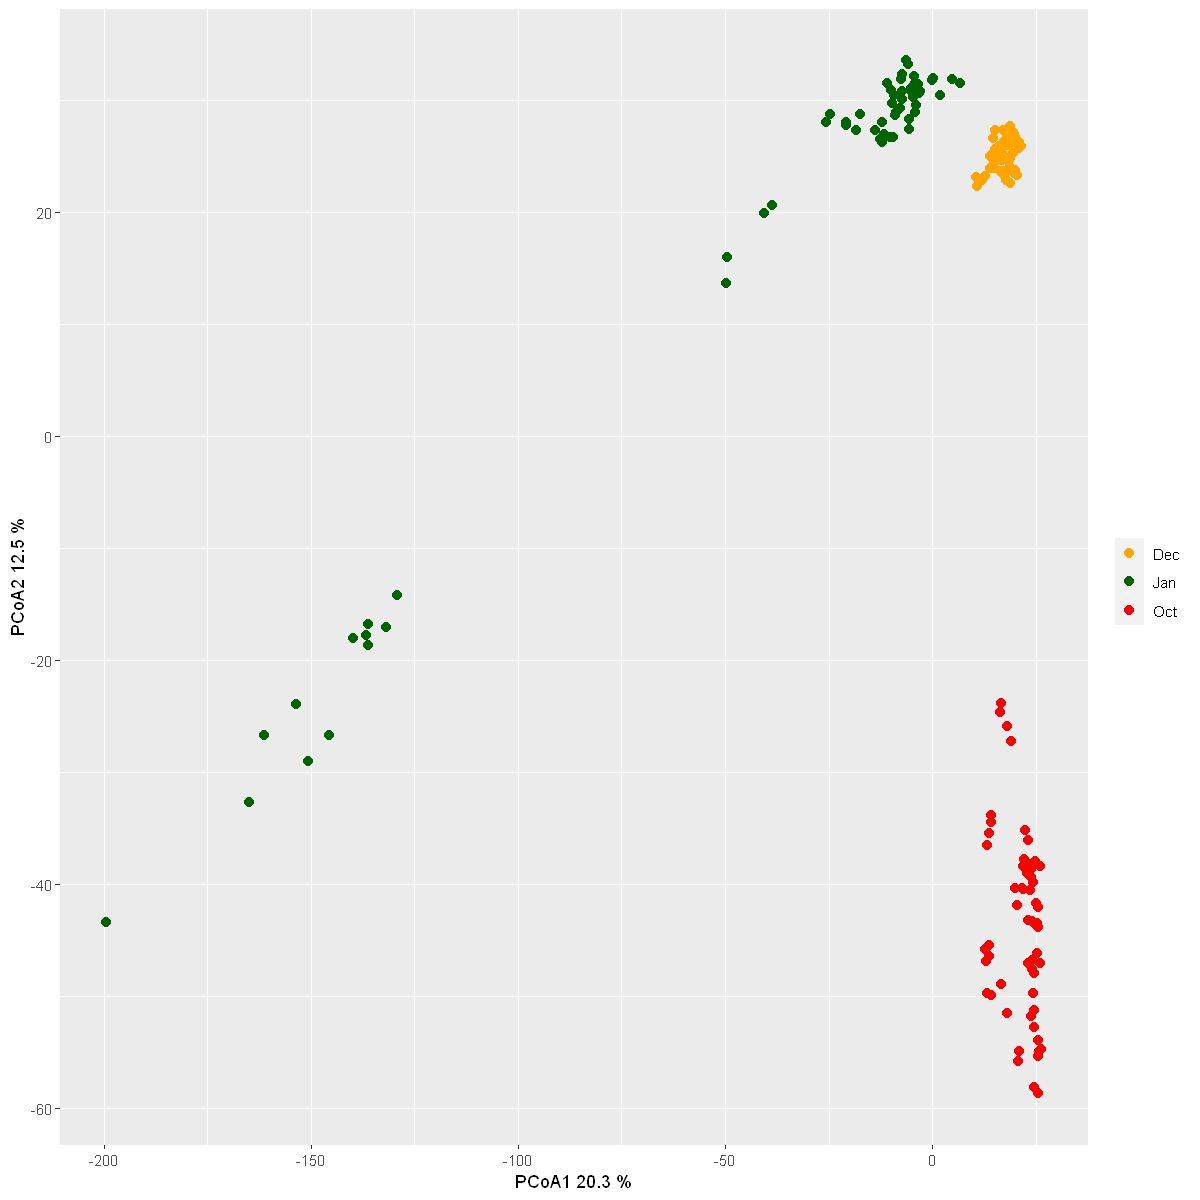

In [340]:
ggplot(PcoA_points, aes(x = PCoA1, y = PCoA2, colour = md_Samples$ATTRIBUTE_Month, label = row.names(PcoA))) +
 geom_point(size=2.5) +
 scale_colour_manual(values = c('orange','darkgreen','red','blue','black')) +
 xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
 ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
 theme(legend.title=element_blank())

<p style='text-align: justify;'> It looks like there is a strong separation between the chemotypes of seawater sampled during different months. But is the separation significant? Let's perform a permutational multivariate analysis of variance (PERMANOVA) to find out! </p>

**Permutational multivariate analysis of variance (PERMANOVA)**

<p style='text-align: justify;'> Permutational multivariate analysis of variance (PERMANOVA) is a non-parametric method for multivariate analysis of variance, where P-values are obtained using permutations. The metric was originally developed within the field of ecology <a href ='https://onlinelibrary.wiley.com/doi/full/10.1002/9781118445112.stat07841'>(Anderson, 2008)</a> but is today widely used in other fields, including the microbiome and metabolomics field. PERMANOVA is used to compare groups of samples and tests whether the centroid and/or the spread of the samples is different between the groups. </p>

<p style='text-align: justify;'> The adonis2() function in the <a href ='https://cran.r-project.org/web/packages/vegan/index.html'>(vegan package)</a> can be used to perform a PERMANOVA. The input is any dissimilarity matrix and the test-statistic retrieved is a multivariate analogue to Fisher's F-ratio as well as an R2 value (Adonis R2). </p>

In [341]:
adonres <- adonis2(distm ~ md_Samples[,colnames(md_Samples) == 'ATTRIBUTE_Month'])
adonres

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"md_Samples[, colnames(md_Samples) == ""ATTRIBUTE_Month""]",2,385177.2,0.2366727,27.43978,0.001
Residual,177,1242290.8,0.7633273,NA,NA
Total,179,1627468.0,1.0000000,NA,NA


<p style='text-align: justify;'> The PERMANOVA test result tells us that there is a significant difference in the metabolomic profiles of seawater sampled during different months (PERMANOVA, P < 0.05, Adonis R2 = 0.2367) and that app. 23% of the variation in our data can be explained by month of sampling. As we already could clearly observe in the PCoA plot, this means that there are strong differences between the chemotypes of seawater sampled at during different months. </p>

**Perform PCoA and assess separation using PERMANOVA**

<p style='text-align: justify;'> To speed up the analysis and so we don't have to rewrite the entire code when testing different parameters, we can define a function, which will perform a principal coordinates analysis (PCoA) using a distance metric of choice, calculate a PERMANOVA and plot results in a 2-D graph: </p>

In [362]:
plotPCoA <- function(ft, md, distmetric = c("euclidean", "maximum", "manhattan", "canberra", "binary", 
                                                  "minkowski"), collow = "#810f7c", colhigh ="#f7fcb9", 
                      catper = "plate", catcols = "plate", mdtype = 'categorical', 
                      cols = c('grey','black','orange','pink','darkgreen','darkred','brown','blue','skyblue3','green'),
                      title = 'Principal coordinates plot'){
    
    catper <<- catper
    distm <- dist(ft, method = distmetric)
    d <- as.matrix(distm)

    if (length(which(is.na(md[,colnames(md) == catper]))) !=0){
          red <- as.dist(as.matrix(distm)[-which(is.na(md[,colnames(md) == catper])),-which(is.na(md[,colnames(md) == catper]))])
          adonres <- adonis2(red ~ na.omit(md[,colnames(md) == catper]))
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        } else {
          adonres <- adonis2(distm ~ md[,colnames(md) == catper])
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        }

    PcoA <- cmdscale(distm, k =2, eig = T, add = T)
    PcoA_points <- as.data.frame(PcoA$points)
    variance <- round(PcoA$eig*100/sum(PcoA$eig),1)
    names(PcoA_points)[1:2] <- c('PCoA1', 'PCoA2')
    PcoA_points <- as.data.frame(PcoA_points)
    PcoA_points$Group <- md[,colnames(md) == catcols][match(rownames(PcoA_points),rownames(md))]
    names(PcoA_points)[1:2] <- c('PCoA1', 'PCoA2')
    
    # plot
    cbPalette <- cols

    if (mdtype == 'continuous'){
          Tr_PcoA <- ggplot(PcoA_points, aes(x = PCoA1, y = PCoA2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_gradient(low = collow, high = colhigh,space = "Lab", na.value = "grey50", guide = "colourbar",aesthetics = "colour") + 
            theme(legend.title=element_blank()) +
            xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
            ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
            ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" "))

        } else {

          Tr_PcoA <- ggplot(PcoA_points, aes(x = PCoA1, y = PCoA2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_manual(values = cbPalette) +
            theme(legend.title=element_blank()) + 
            xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
            ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
            ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" "))
        }
    
    print(Tr_PcoA)
}

By defining different parameters within the plotPCoA function:

- **distmetric:** A distance metric of your choice, including "euclidean", "maximum", "manhattan", "canberra", "binary" or "minkowski".
- **catper:** How should the samples be grouped for PERMANOVA, this can be any column name of your metadata.
- **catcols:** According to what groups should the samples be colored on the PCoA, this can be any column name of your metadata.
mdtype: Either 'categorical' or 'continuous', this value defines whether a continuous or categorical color scale should be used for the PCoA.
- **cols:** Colors used for plotting the groups in the PCoA. The length of this object should be equal to the number of groups plotted.
- **title:** Any title of your choice you want to give the plot.<br>

we can quickly draw the same PCoA plot as above and retrieve PERMANOVA test results at the same time.

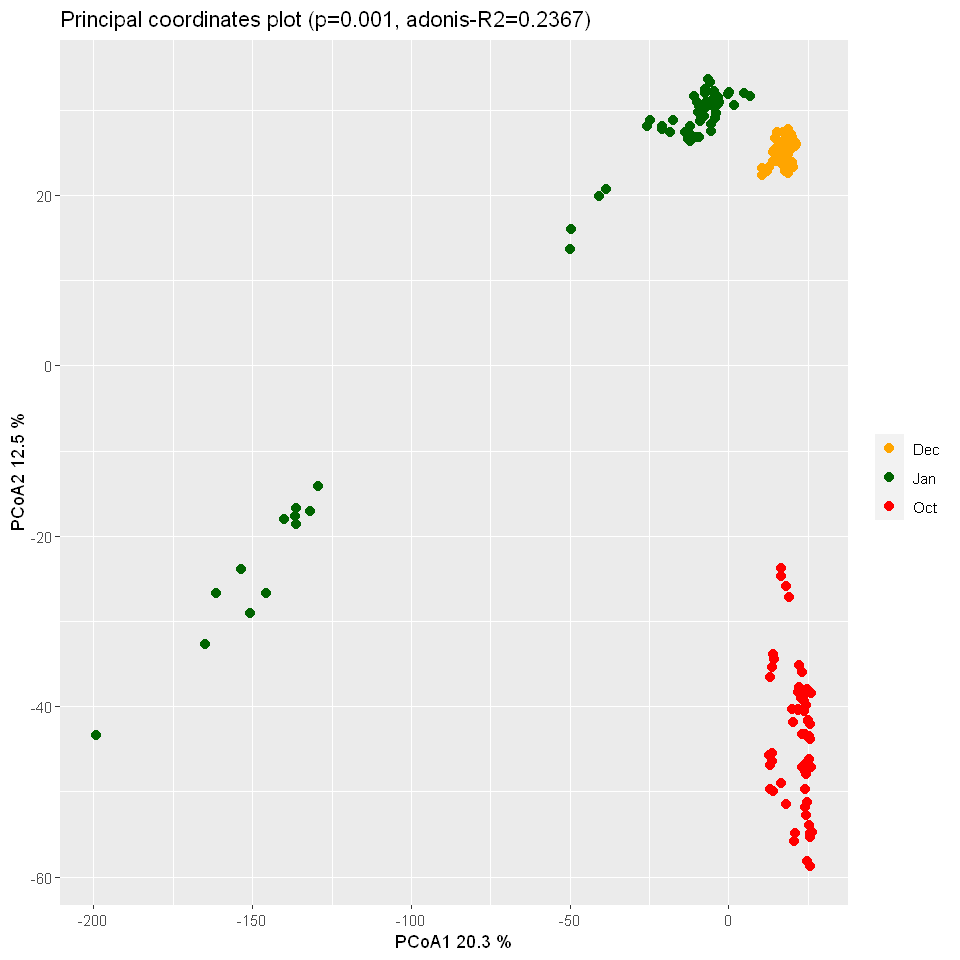

In [363]:
plotPCoA(Imp_s, md_Samples, distmetric = "euclidean", catper = "ATTRIBUTE_Month", catcols = "ATTRIBUTE_Month", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black'),
                      title = 'Principal coordinates plot')

- We can also test a different distance metric and look at the separation of samples. During data cleanup we replaced all zero values with the minimum value found in our feature table. We might want to opt not to impute any values but instead use a distance metric that can deal better with missing values (e.g. Canberra).

We will use the non-imputed, scaled feature table for that purpose. Before scaling, we will replace all zero values in the non-imputed feature table with NAs.

In [364]:
ft_nonimp <- t(blk_rem)

In [365]:
identical(rownames(ft_nonimp),rownames(md_Samples))

[1] TRUE

In [366]:
ft_nonimp[ft_nonimp == 0] <- NA

In [367]:
fts_nonimp <- scale(ft_nonimp, scale = TRUE, center = TRUE)

How many missing values do we have (in %)?

In [368]:
(sum(is.na(ft_nonimp))*100)/(dim(ft_nonimp)[1]*dim(ft_nonimp)[2])

[1] 32.48815

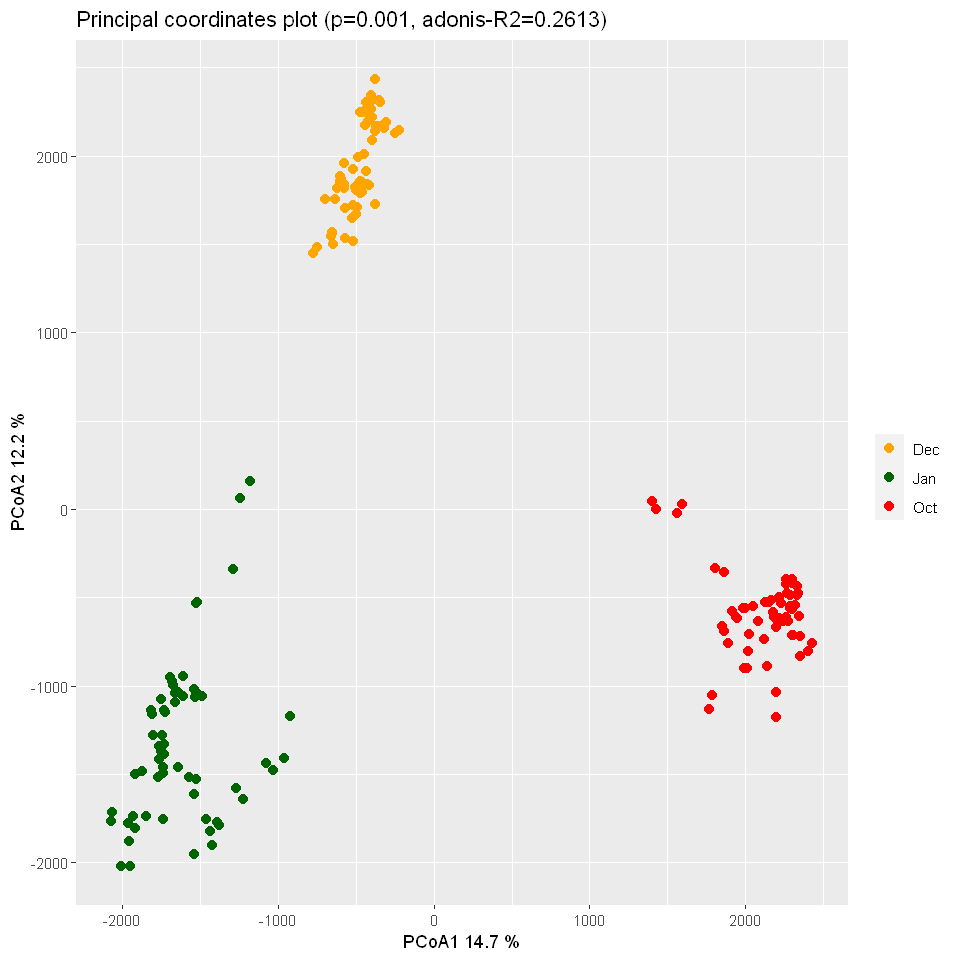

In [369]:
plotPCoA(fts_nonimp, md_Samples, distmetric = "canberra", catper = "ATTRIBUTE_Month", catcols = "ATTRIBUTE_Month", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black'),
                      title = 'Principal coordinates plot')

Using the Canberra distance metric, we also see a significant difference in the metabolomic profiles of seawater collected during different months (PERMANOVA, P < 0.05, Adonis R2 = 0.2613) with app. 26% of the variation in our data explained by month of sampling.

Lastly, let's also test a binary metric, the Jaccard metric. When we apply the Jaccard metric we need to work with the non-imputed, non-scaled feature table, where all missing values need to be converted to 0s. A positive value will be interpreted as 1 (present) and missing values as 0 (absent).

In [370]:
ft_nonimp_0 <- ft_nonimp
ft_nonimp_0[is.na(ft_nonimp_0)] <- 0

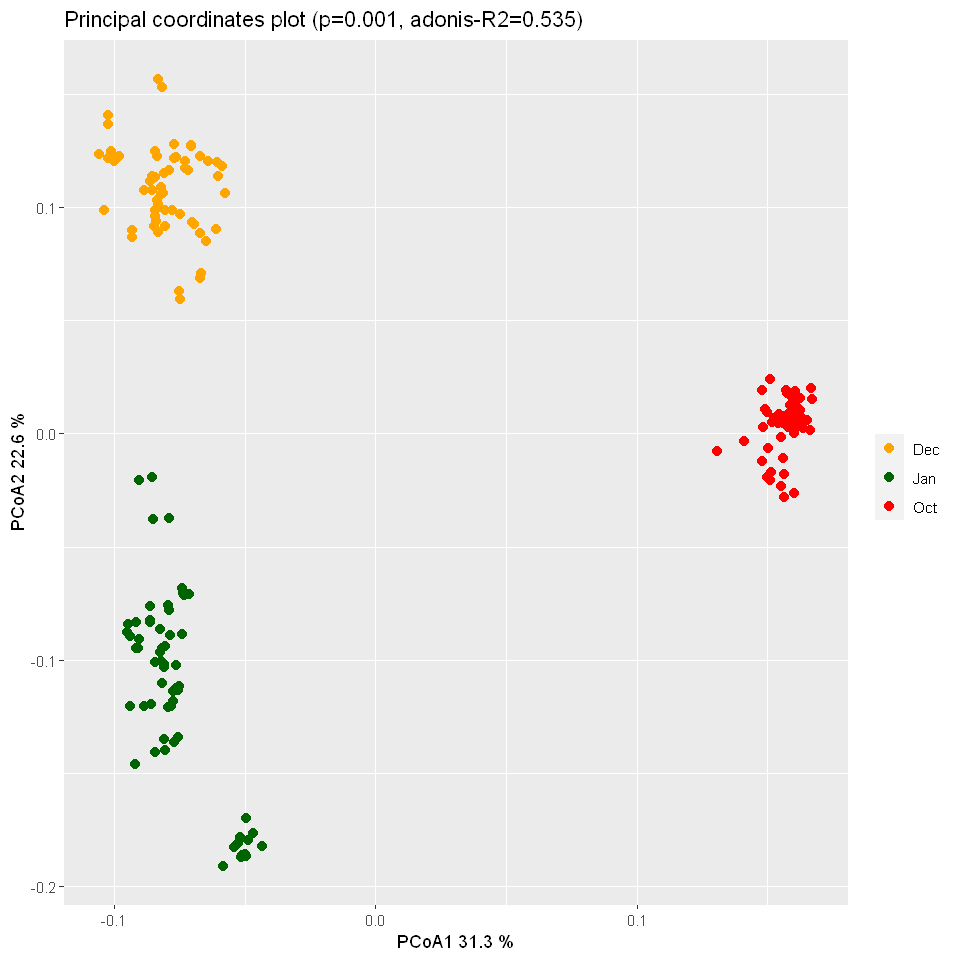

In [371]:
plotPCoA(ft_nonimp_0, md_Samples, distmetric = "binary", catper = "ATTRIBUTE_Month", catcols = "ATTRIBUTE_Month", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black'),
                      title = 'Principal coordinates plot')

Using the Jaccard distance metric, we also see a significant difference in the metabolomic profiles of seawater collected during different months (PERMANOVA, P < 0.05, Adonis R2 = 0.535) with app. 53% of the variation in our data explained by month of sampling. We observe the highest R2 using the Jaccard metric, indicating that differences in seawater chemotypes between different months are mainly qualitative.

We can also test whether there a significant differences in metabolomic profiles between different sample areas

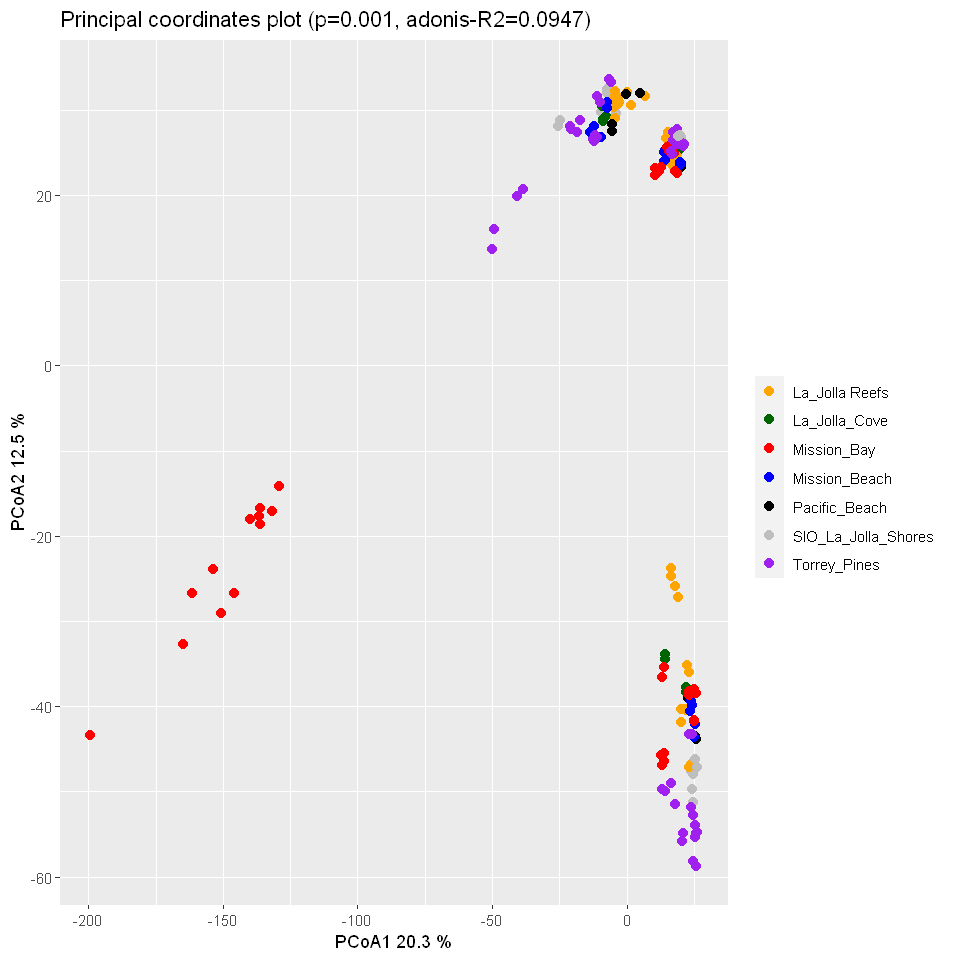

In [372]:
plotPCoA(Imp_s, md_Samples, distmetric = "euclidean", catper = "ATTRIBUTE_Sample_Area", catcols = "ATTRIBUTE_Sample_Area", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black','grey','purple'),
                      title = 'Principal coordinates plot')

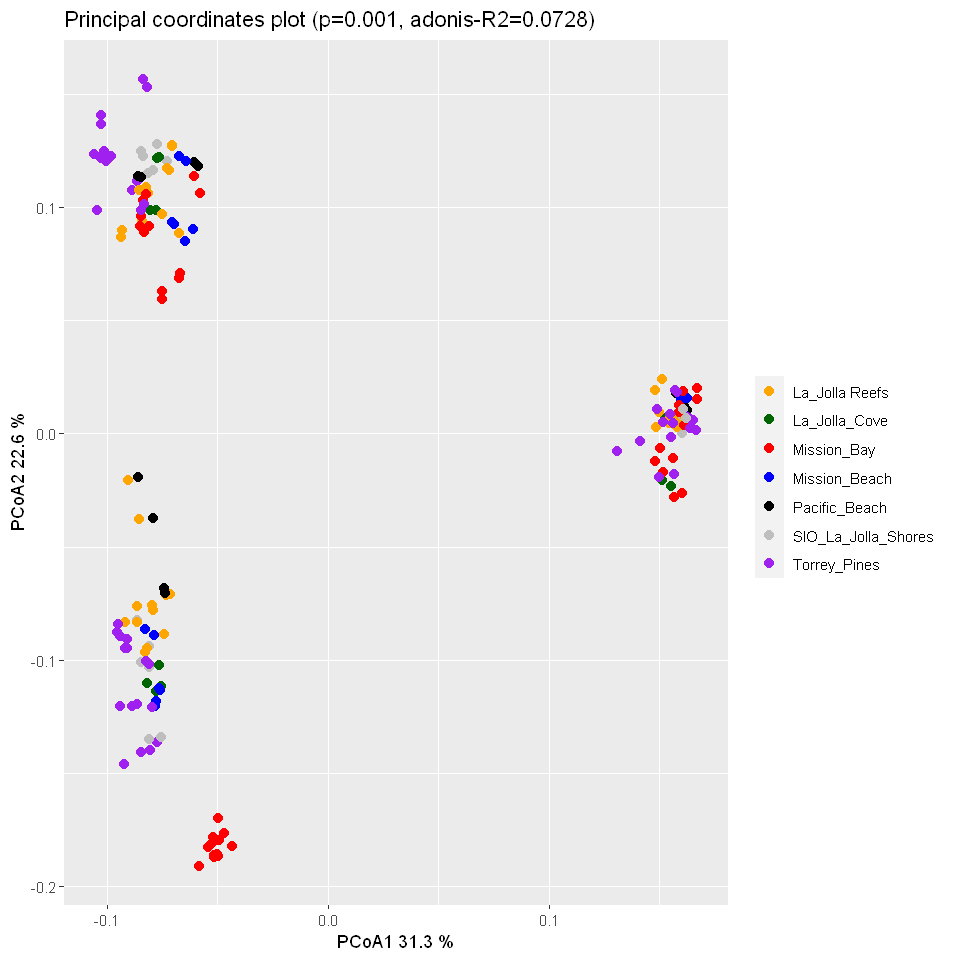

In [373]:
plotPCoA(ft_nonimp_0, md_Samples, distmetric = "binary", catper = "ATTRIBUTE_Sample_Area", catcols = "ATTRIBUTE_Sample_Area", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black','grey','purple'),
                      title = 'Principal coordinates plot')

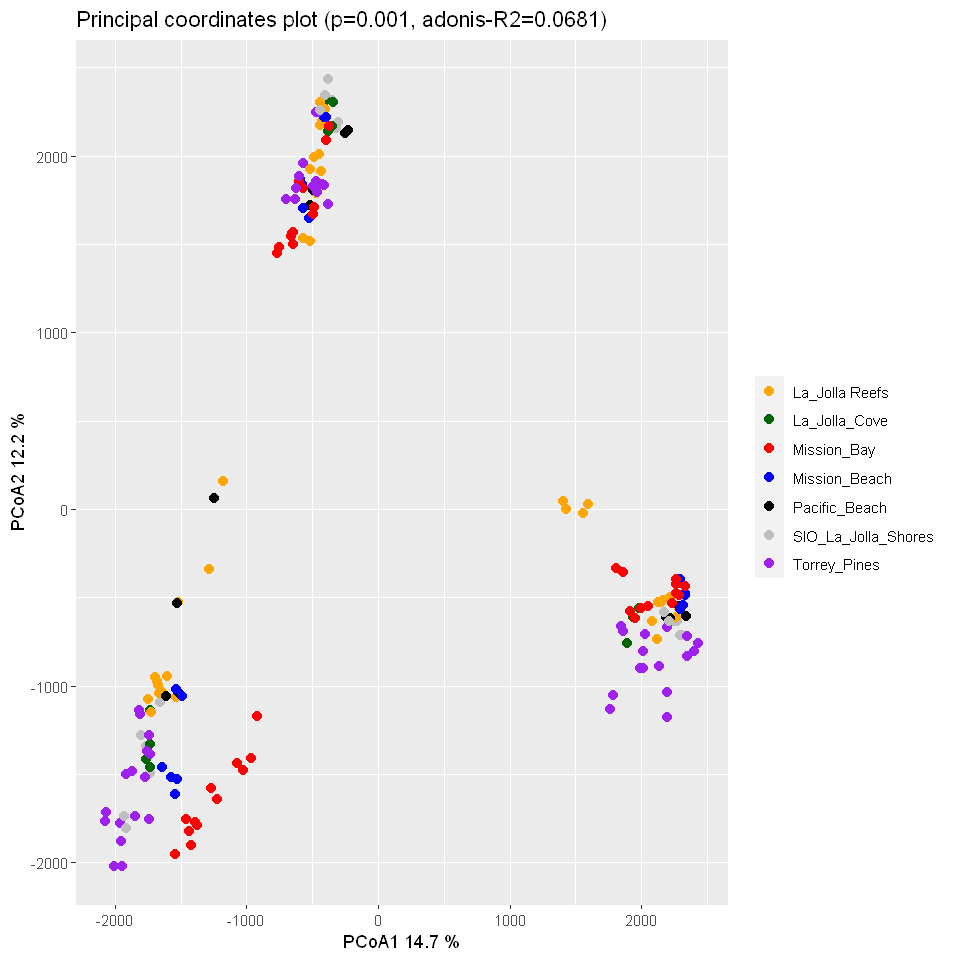

In [374]:
plotPCoA(fts_nonimp, md_Samples, distmetric = "canberra", catper = "ATTRIBUTE_Sample_Area", catcols = "ATTRIBUTE_Sample_Area", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black','grey','purple'),
                      title = 'Principal coordinates plot')

The results tell us that there are significant differences in the metabolomic profiles of seawater collected at different sampling areas (PERMANOVA p-value < 0.05). However, the differences are not as strong as the differences observed for month of sampling with only 9% and 7% respectively of the variation in the data explained by sampling area.

We can do the same for year of sampling or injection order

In [375]:
md_Samples$ATTRIBUTE_Year <- as.factor(md_Samples$ATTRIBUTE_Year)

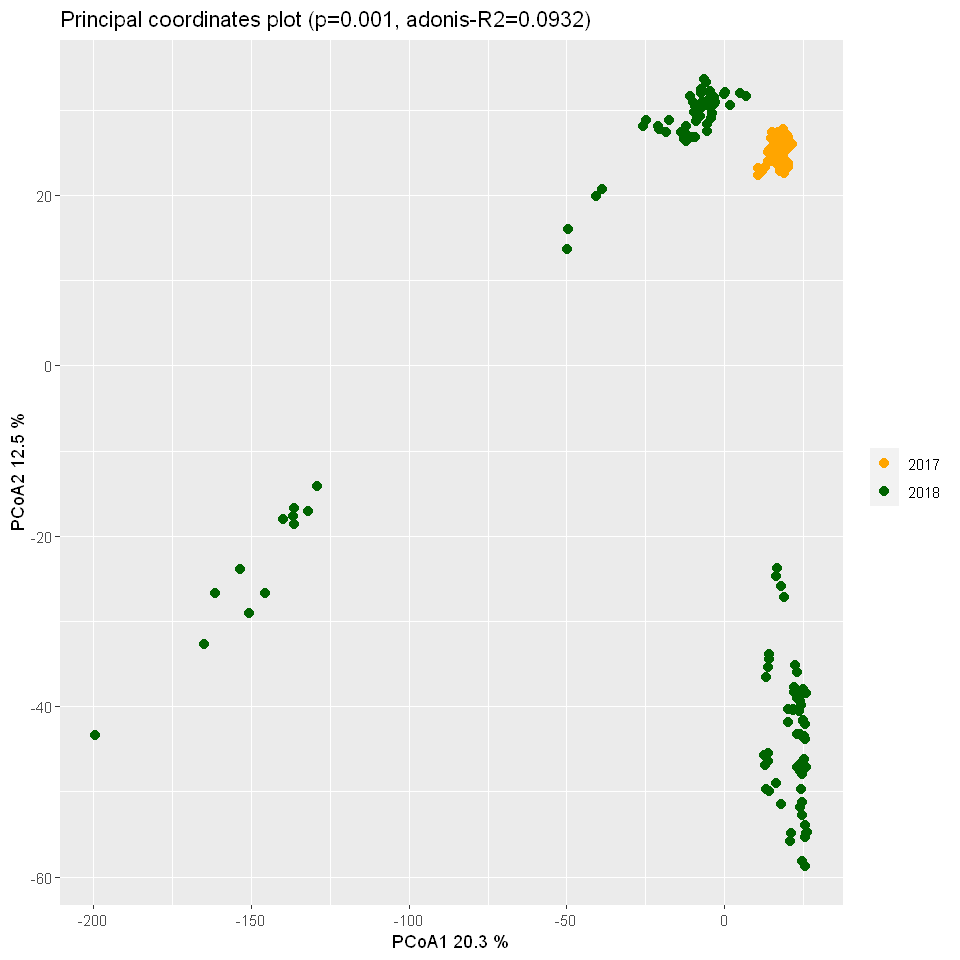

In [376]:
plotPCoA(Imp_s, md_Samples, distmetric = "euclidean", catper = "ATTRIBUTE_Year", catcols = "ATTRIBUTE_Year", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black','grey','purple'),
                      title = 'Principal coordinates plot')

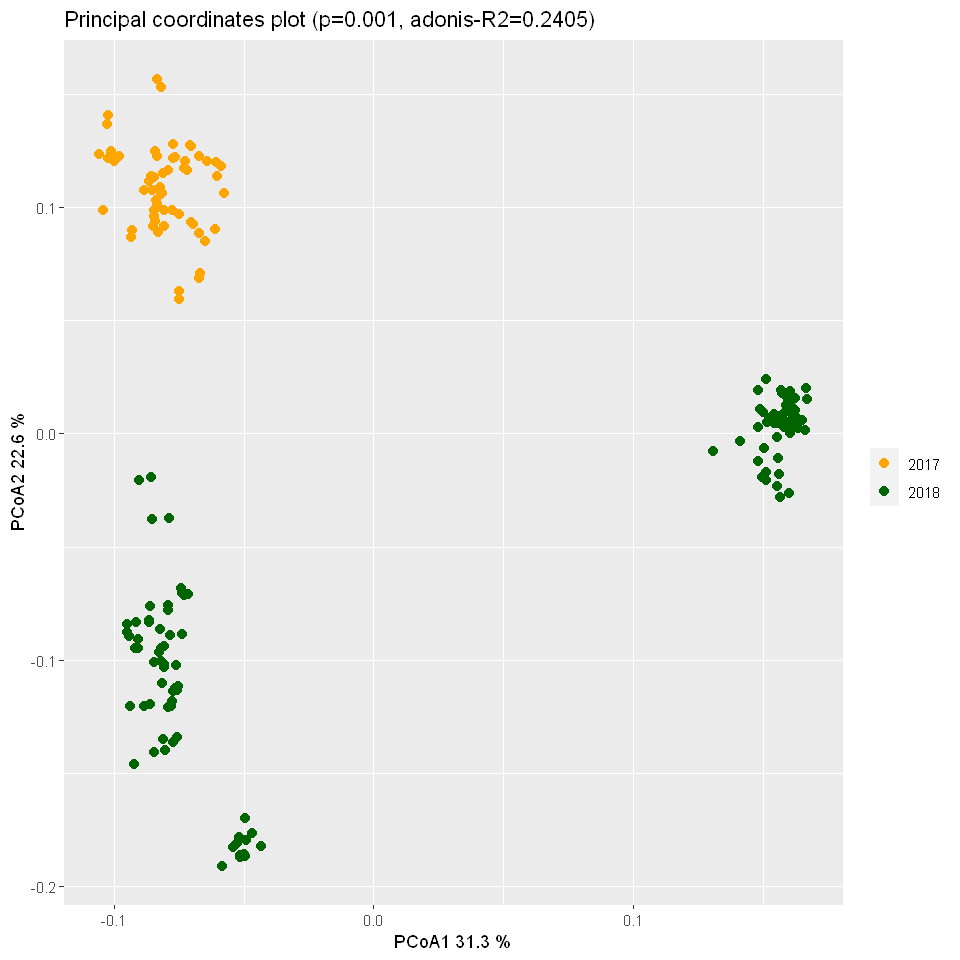

In [377]:
plotPCoA(ft_nonimp_0, md_Samples, distmetric = "binary", catper = "ATTRIBUTE_Year", catcols = "ATTRIBUTE_Year", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black','grey','purple'),
                      title = 'Principal coordinates plot')

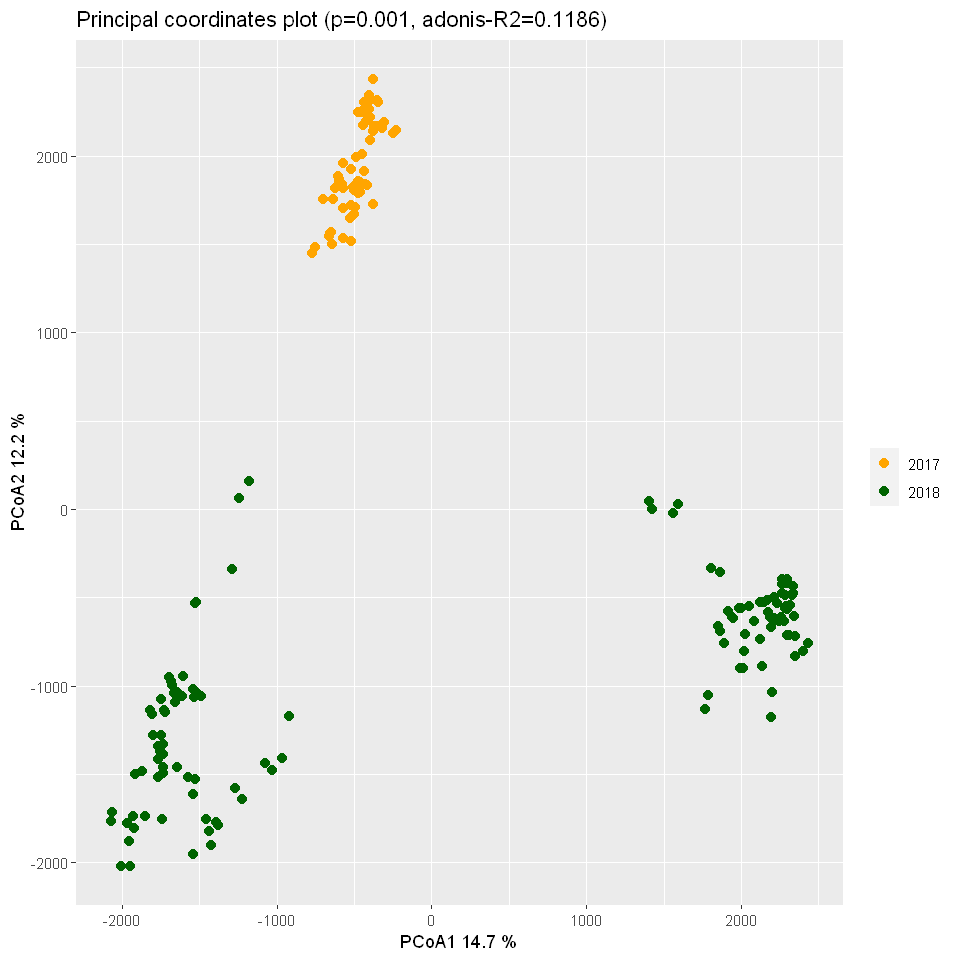

In [378]:
plotPCoA(fts_nonimp, md_Samples, distmetric = "canberra", catper = "ATTRIBUTE_Year", catcols = "ATTRIBUTE_Year", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','blue','black','grey','purple'),
                      title = 'Principal coordinates plot')

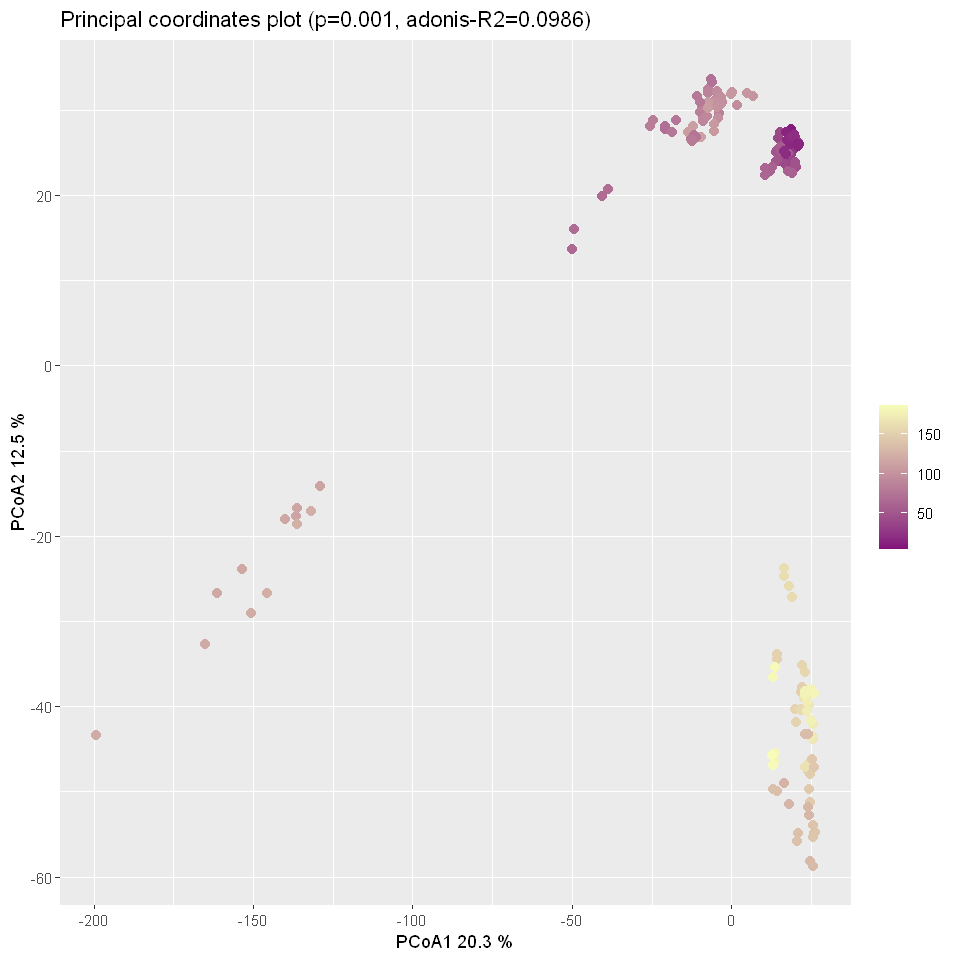

In [379]:
plotPCoA(Imp_s, md_Samples, distmetric = "euclidean", catper = "ATTRIBUTE_Injection_order", catcols = "ATTRIBUTE_Injection_order", 
         mdtype = 'continuous', cols = c('orange','darkgreen','red','blue','black','grey','purple'), title = 'Principal coordinates plot')

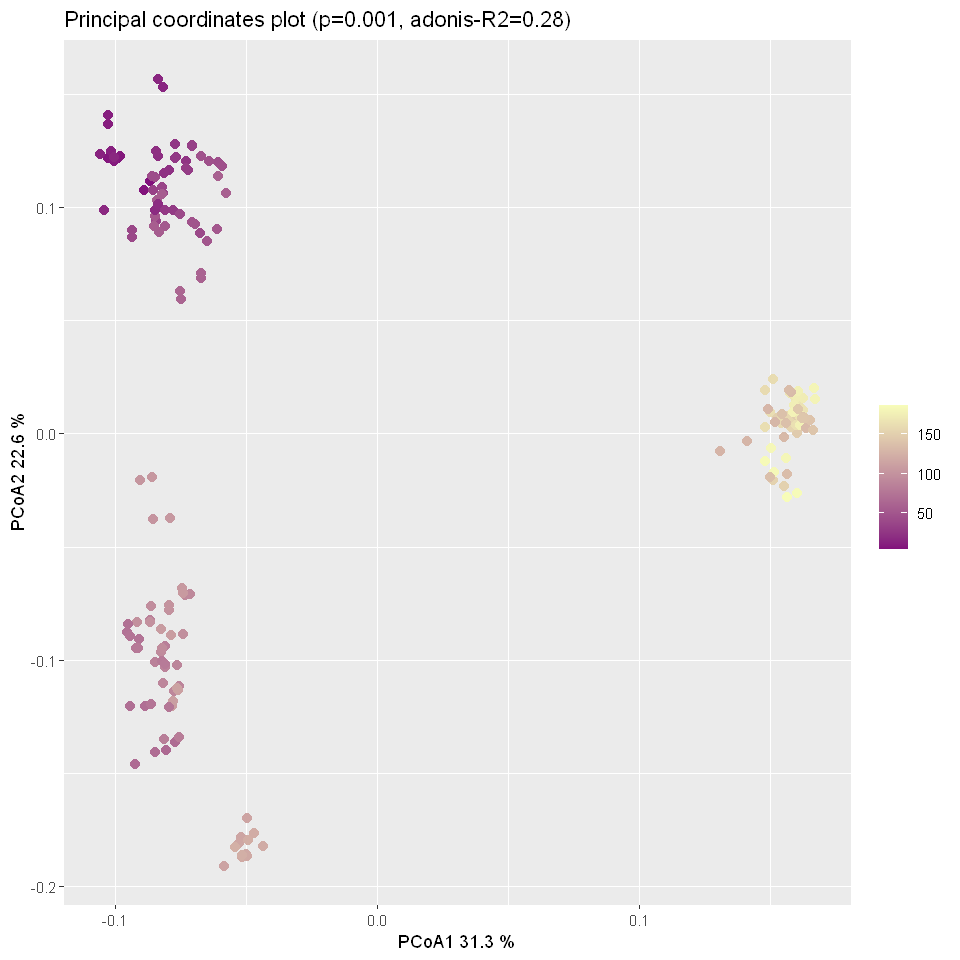

In [380]:
plotPCoA(ft_nonimp_0, md_Samples, distmetric = "binary", catper = "ATTRIBUTE_Injection_order", catcols = "ATTRIBUTE_Injection_order", 
         mdtype = 'continuous', cols = c('orange','darkgreen','red','blue','black','grey','purple'),title = 'Principal coordinates plot')

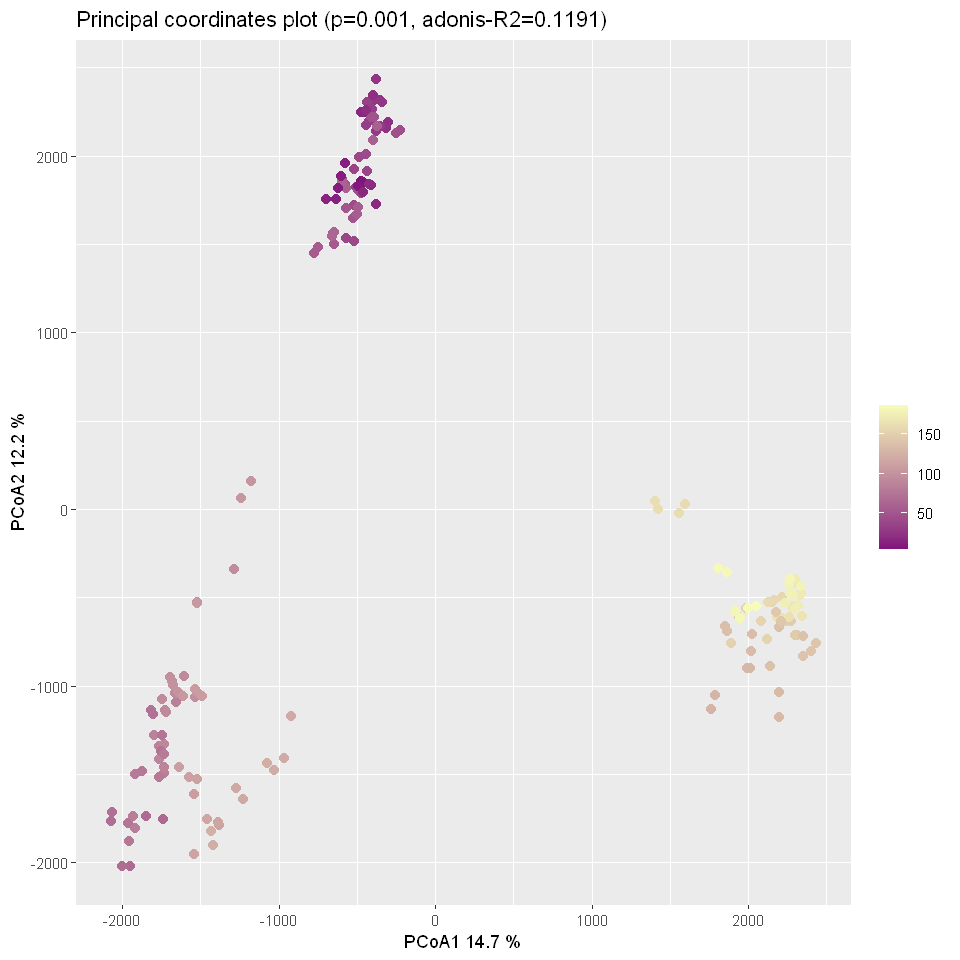

In [381]:
plotPCoA(fts_nonimp, md_Samples, distmetric = "canberra", catper = "ATTRIBUTE_Injection_order", catcols = "ATTRIBUTE_Injection_order", 
         mdtype = 'continuous', cols = c('orange','darkgreen','red','blue','black','grey','purple'),title = 'Principal coordinates plot')

## <font color = 'darkblue'> 5.2 Hierarchial Clustering Algorithm</font>
<a id="hca"></a>

We are now ready to perform a cluter analysis. The concept behind hierarchical clustering is to repeatedly combine the two nearest clusters into a larger cluster.

The first step consists of calculating the distance between every pair of observation points and stores it in a matrix;
1. It puts every point in its own cluster;
2. It merges the closest pairs of points according to their distances;
3. It recomputes the distance between the new cluster and the old ones and stores them in a new distance matrix;
4. It repeats steps 2 and 3 until all the clusters are merged into one single cluster. <br>

Next, we perform the hierarchical clustering. As you can see in the following code we need to specify the 'method' argument. This argument tells the algorithm how to measure the distance between clusters and it's usually referred as 'Linkage Method'. There are several and you can explore different options here https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/hclust. Usually, you will try different ones and plot the result.

Here, we use the default 'complete' (i.e. complete-linkage), which calculates the maximum distance between clusters before merging.

In [382]:
#Global settings for plot size in the output cell:
options(repr.plot.width=20, repr.plot.height=10,res=128) # the parameters: width, height & resolution can be changed

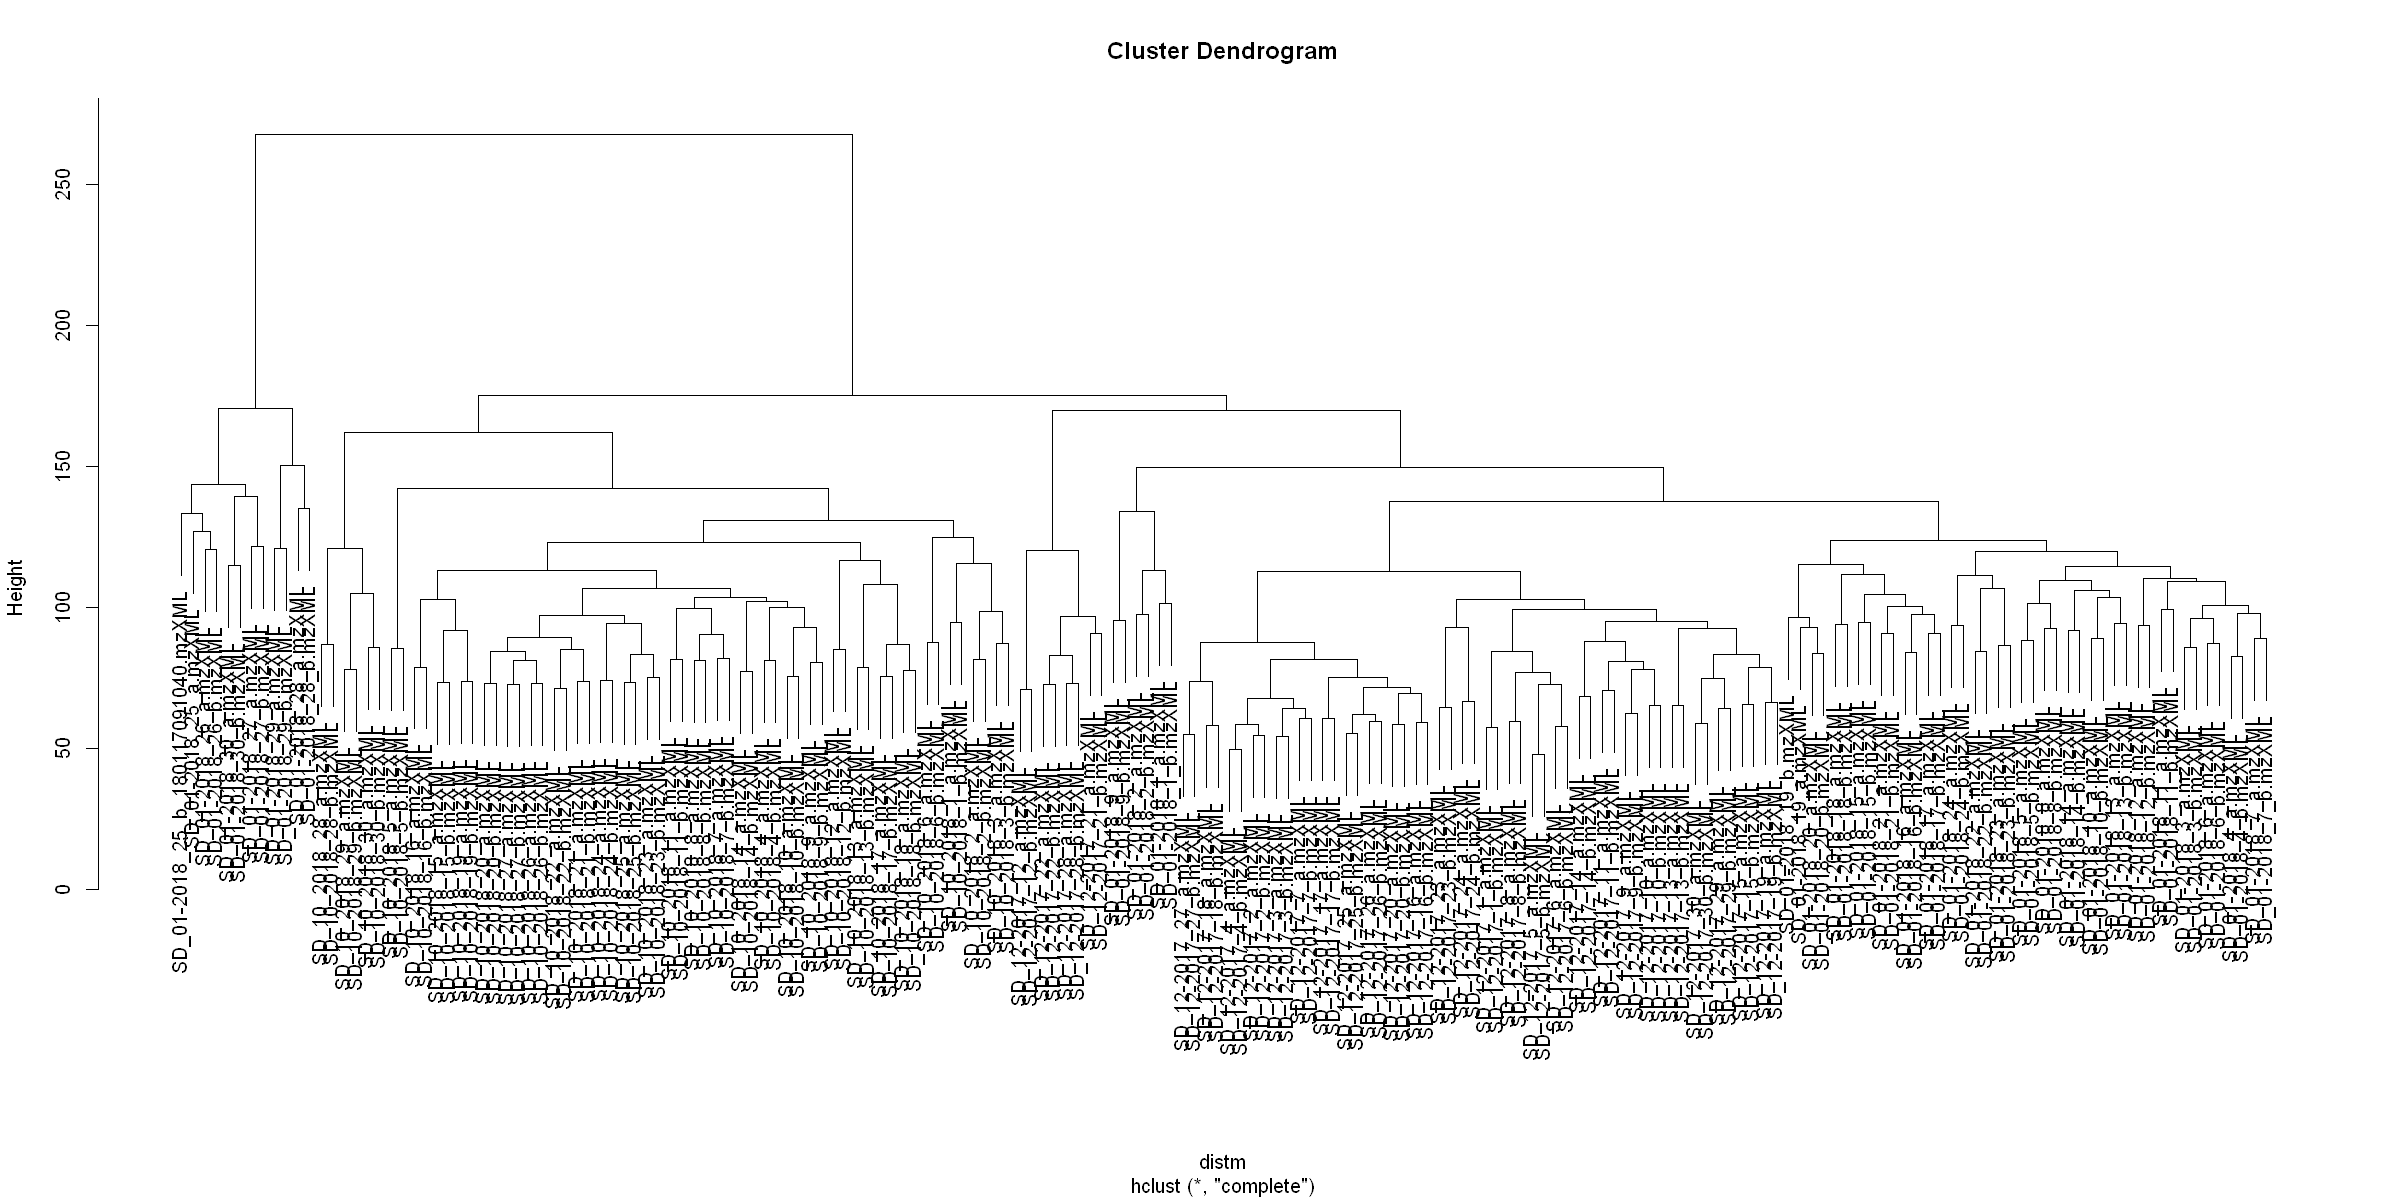

In [383]:
set.seed(1234) # Setting a seed for reproducing the same result
hclust_res <- hclust(distm, method = 'complete')
plot(hclust_res) #visualize the cluster relationships in a tree-like diagram called dendrogram

In the above dendogram, the distance of split or merge is given as the y axis 'height'. You can also cut the dendrogram to create the desired number of clusters. In this case, it seems we have 3 main 'splits', further divided into a total of 4 clusters. We are going to use the cutree() function for this https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/cutree.

In [384]:
cut_res <- cutree(hclust_res, k = 4) # where k indicates the number of clusters we want
head(data.frame(cut_res)) # looking at the header of the cluster assignment

,cut_res
,<int>
SD_01-2018_1_a.mzXML,1
SD_01-2018_1_b.mzXML,1
SD_01-2018_10_a.mzXML,1
SD_01-2018_10_b.mzXML,1
SD_01-2018_11_a.mzXML,1
SD_01-2018_11_b.mzXML,1


In [385]:
# counting the number of samples present in each cluster
table(data.frame(cut_res))

cut_res
  1   2   3   4 
108   8   4  60 

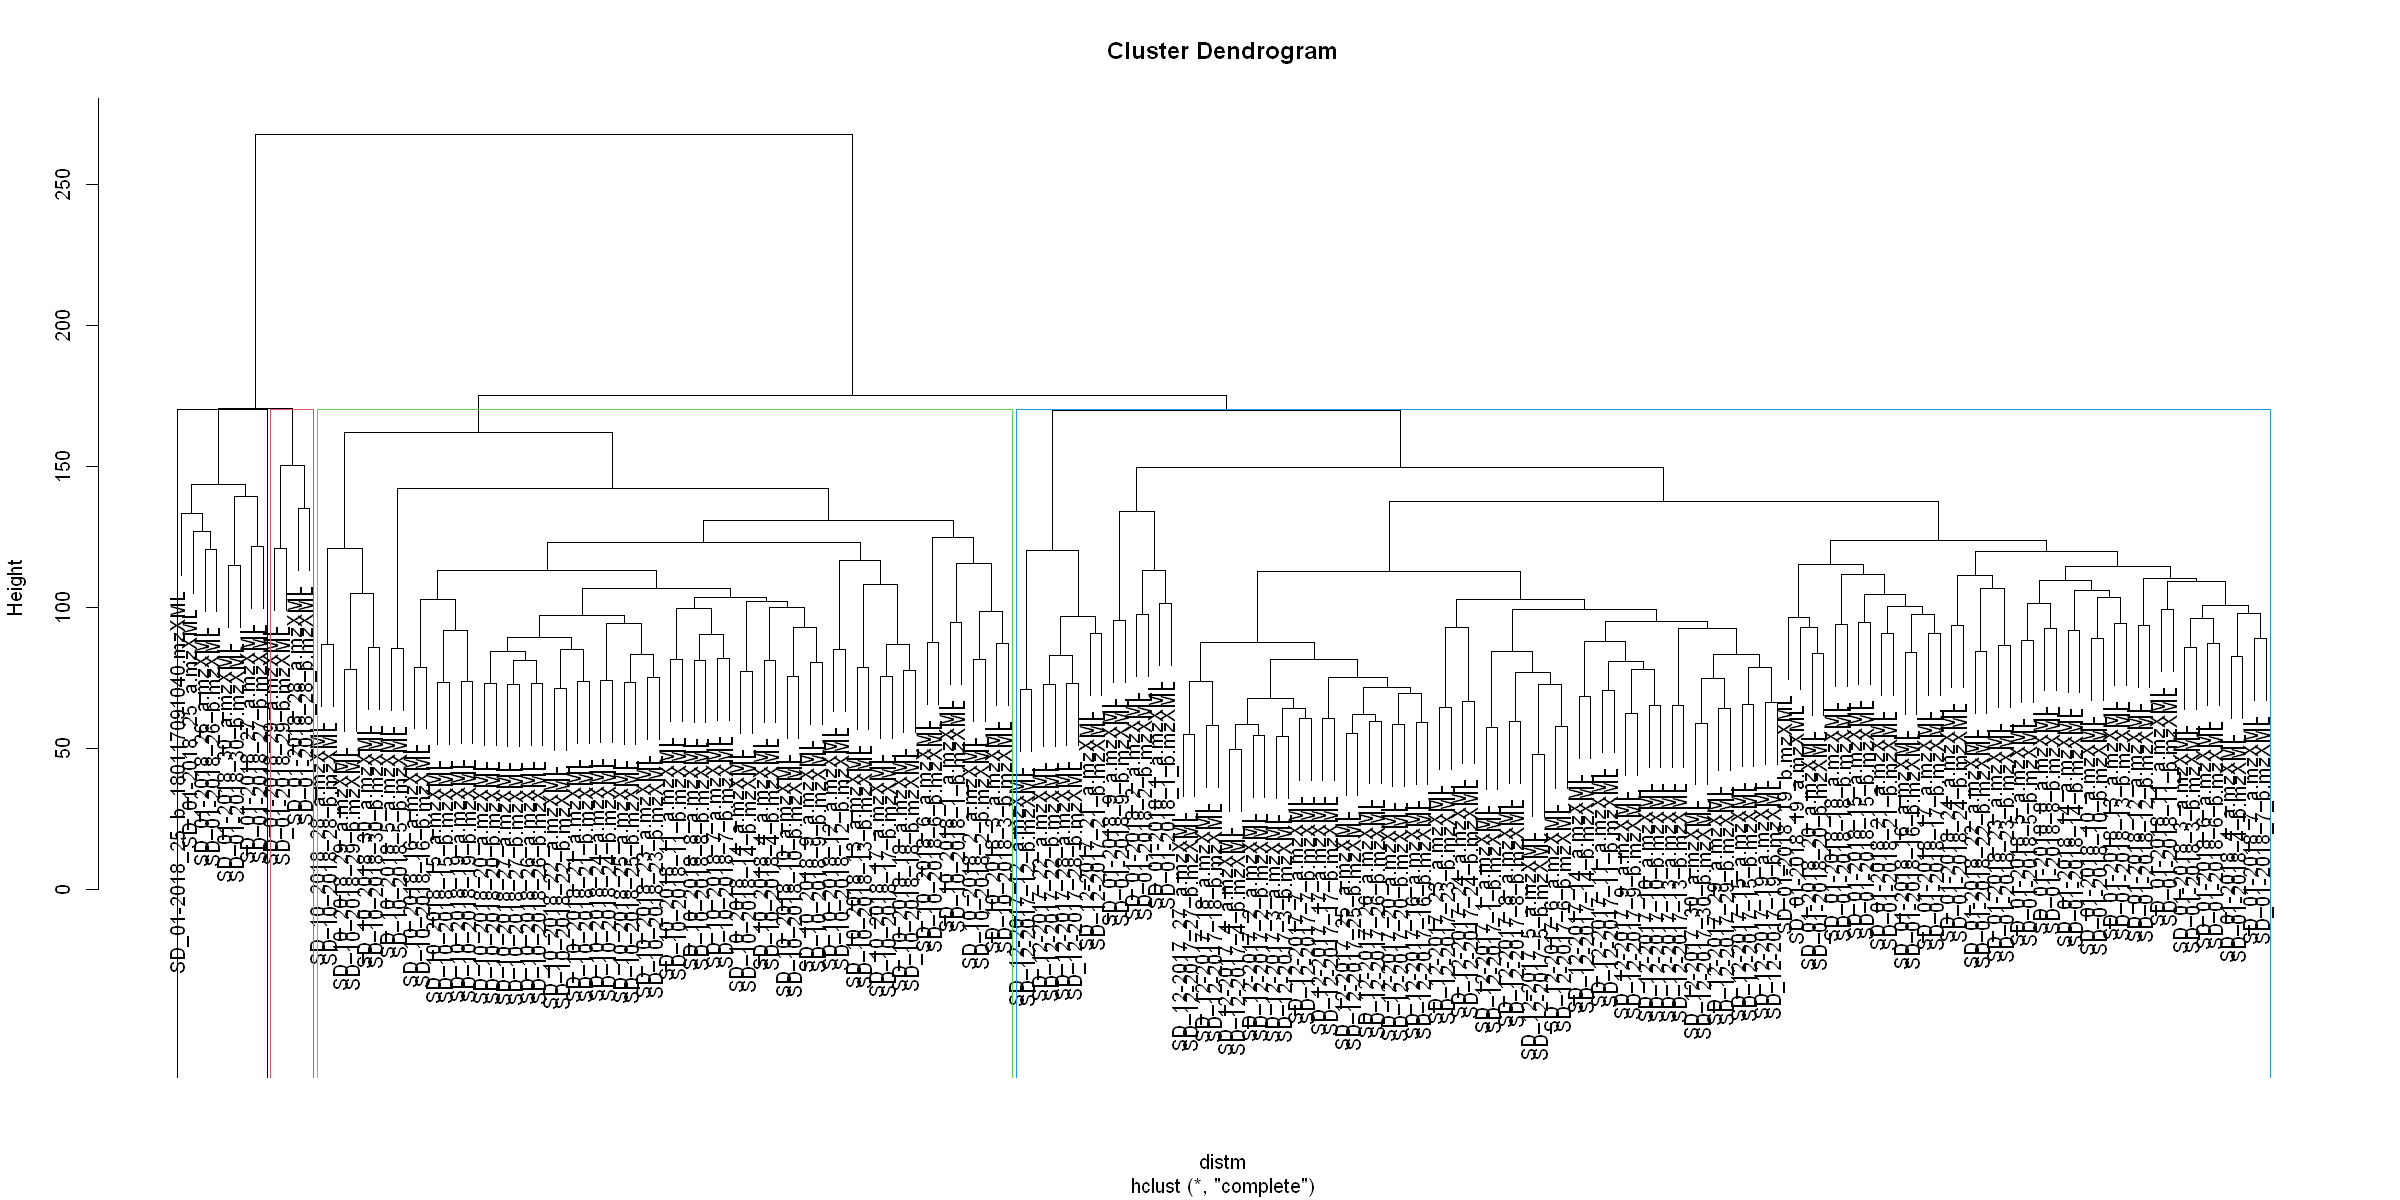

In [386]:
# highlight the clusters in the dendrogram by coloring their borders.
plot(hclust_res)
rect.hclust(hclust_res, k = 4, border = 1:4)

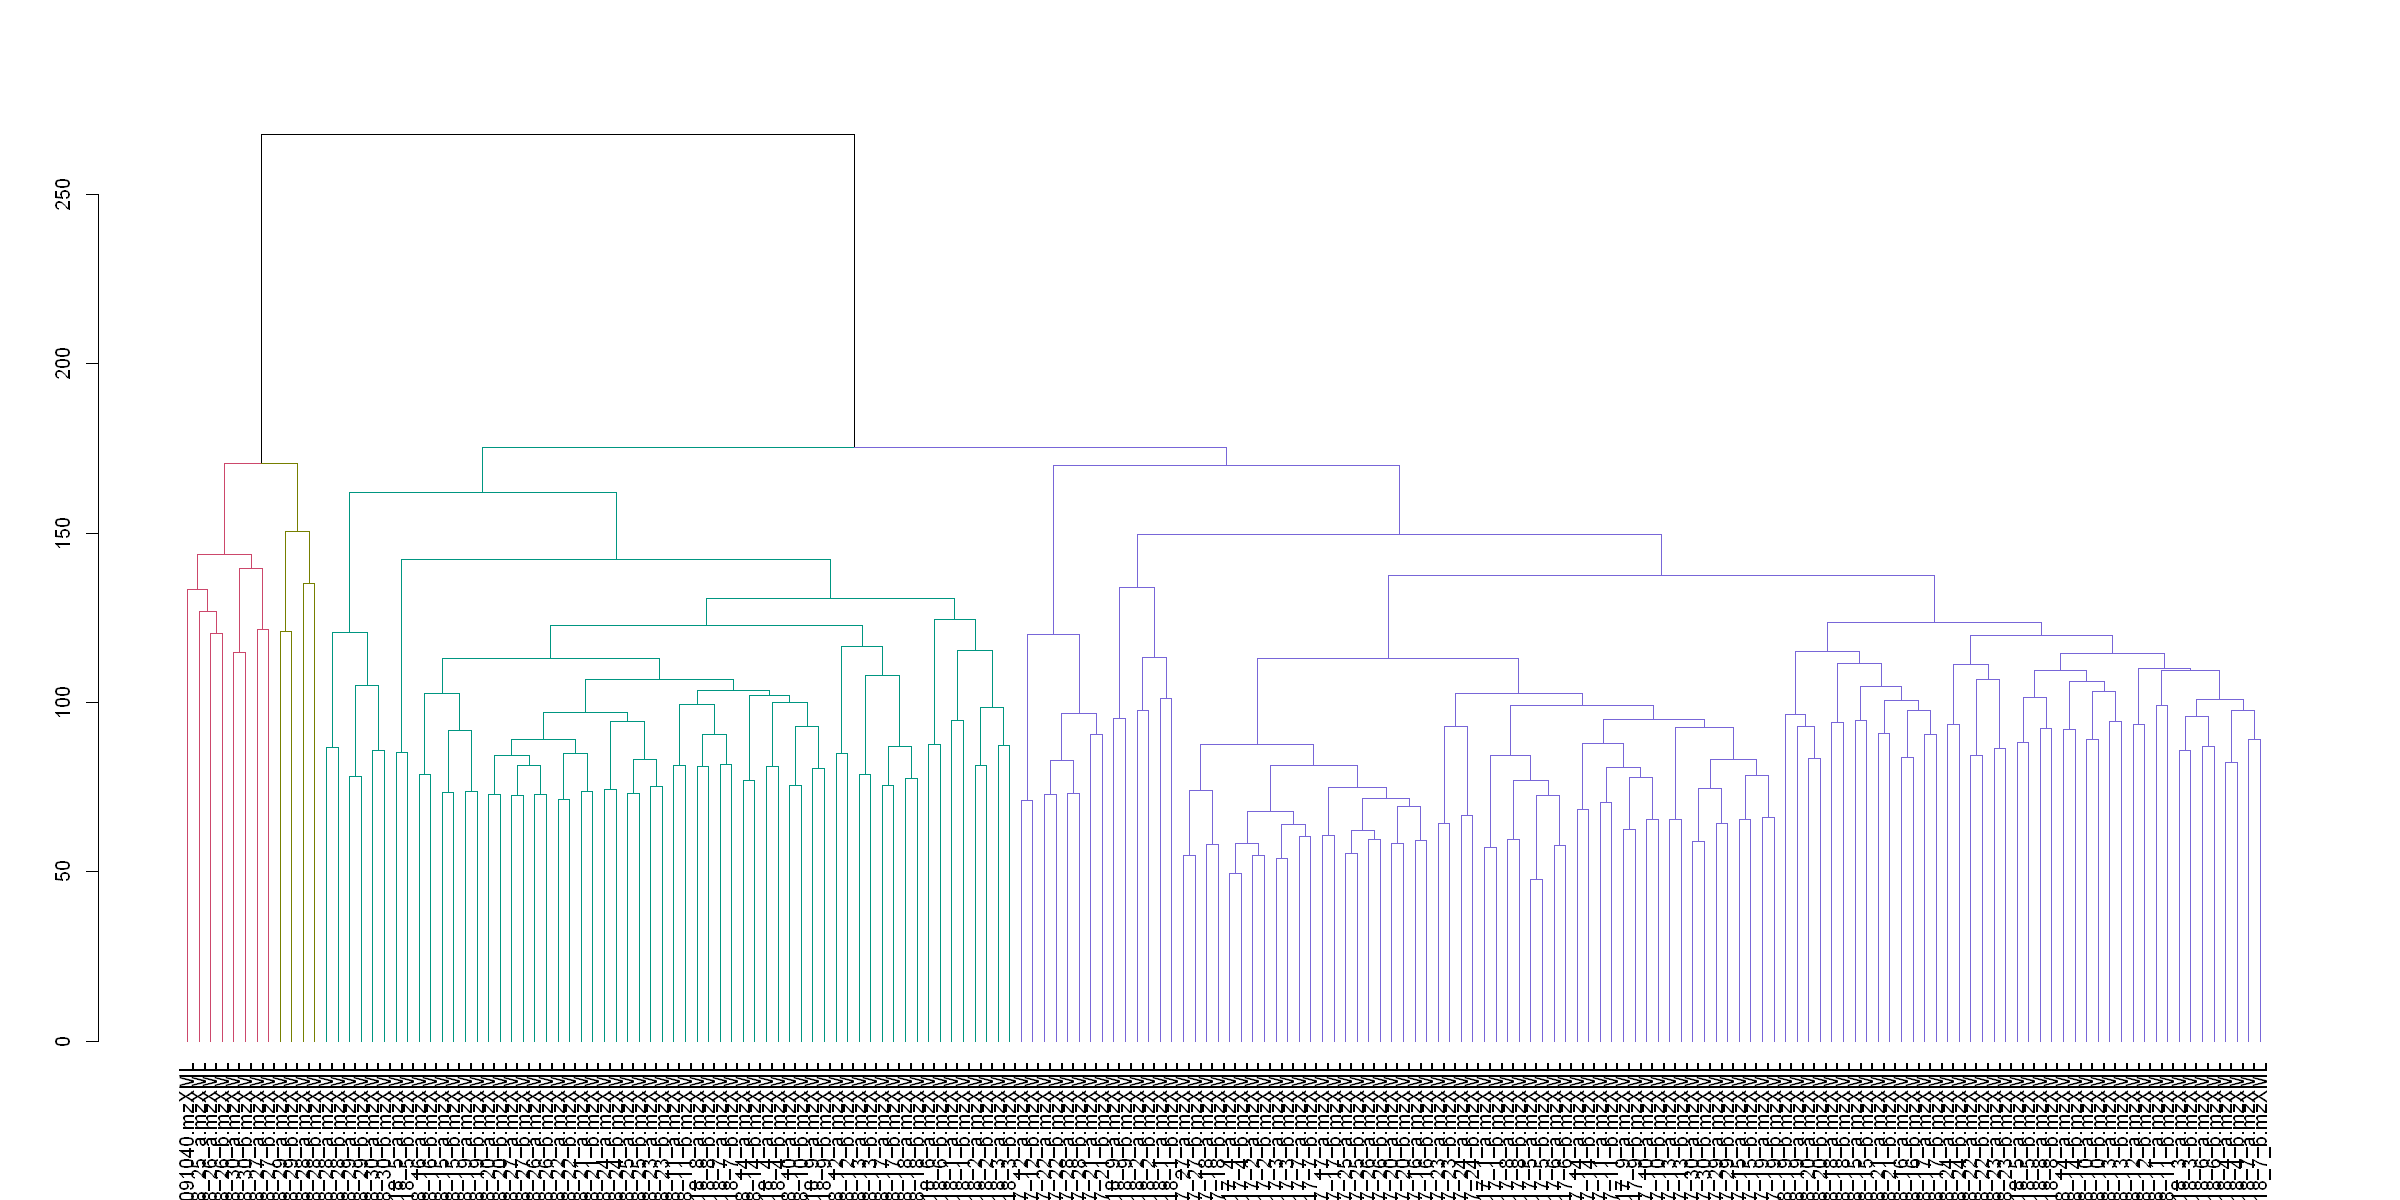

In [387]:
# Coloring the entire clusters with different colors
dend_obj <- as.dendrogram(hclust_res)
col_dend <- color_branches(dend_obj, k = 4)
plot(col_dend)

**Can we define the number of clusters using a simple approach? We are going to use the NbClust and factoextra packages for this purpose.**

We start with the Elbow approach. The Elbow method looks at the total within-cluster sum of square (WSS) as a function of the number of clusters. WSS: sum of distances between the points and the corresponding centroids for each cluster.

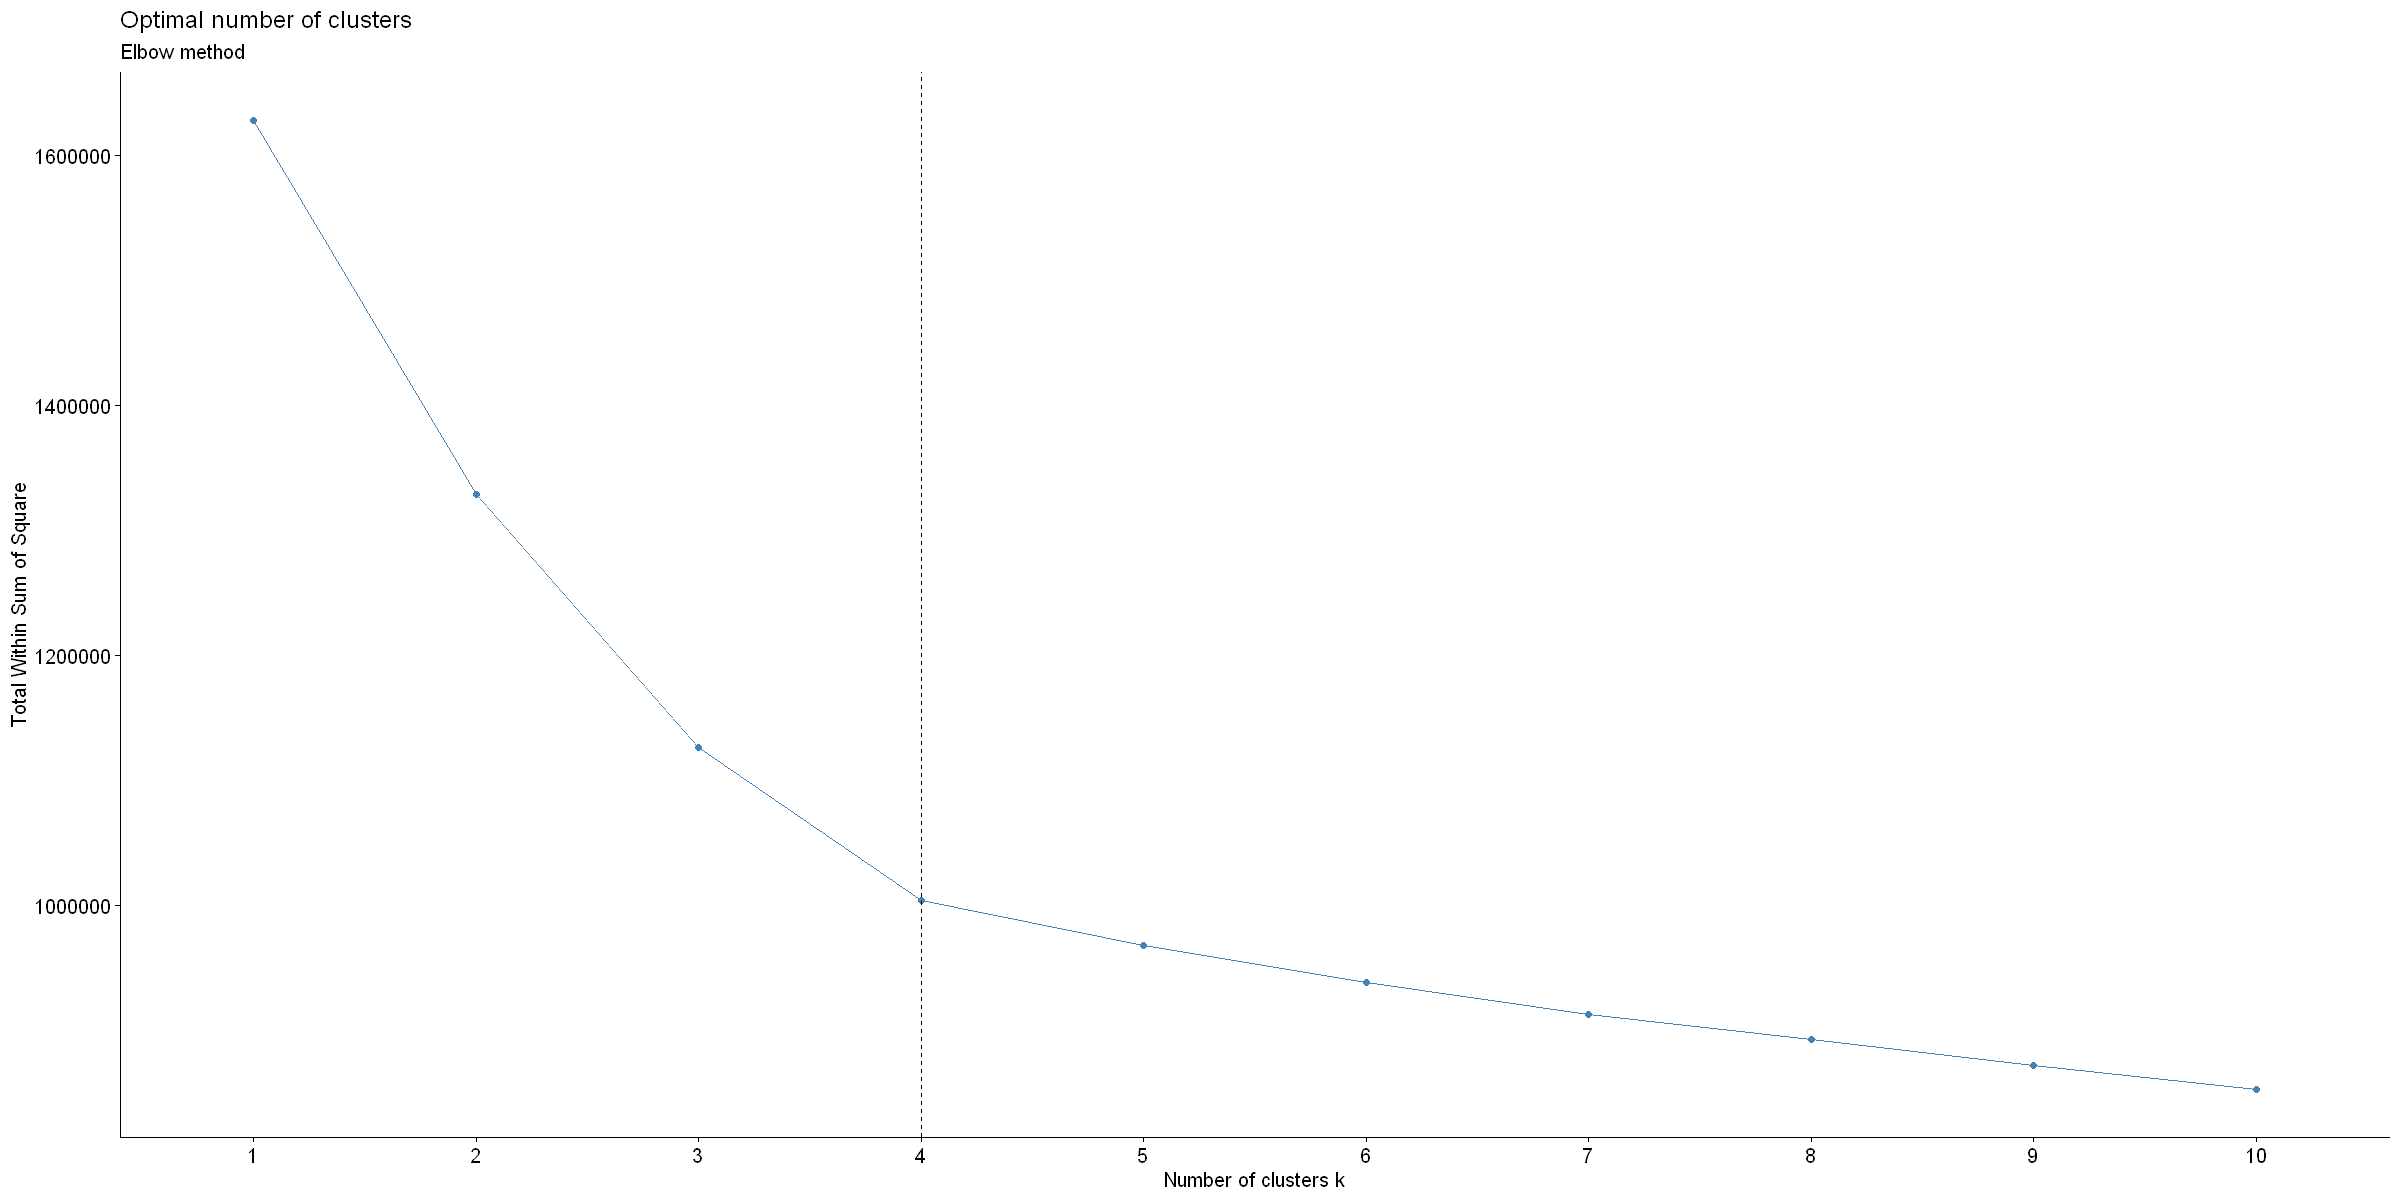

In [388]:
# Elbow method. Here we use 'hcut' which computes the hierarchical clustering and cut the tree.
fviz_nbclust(Imp_s, hcut, method = "wss") +
  geom_vline(xintercept = 4, linetype = 2) + # add line indicating what you think is the optimal number of clusters
  labs(subtitle = "Elbow method") # add subtitle

The location of a 'elbow' in the plot is usually considered as an indicator of the appropriate number of clusters because it means that adding another cluster does not improve the grouping. This method seems to suggest 3 or 4 clusters. However, the Elbow method is sometimes ambiguous.
An alternative is the average silhouette method. The Silhouette method measures the quality of a clustering and determines how well each point lies within its cluster.

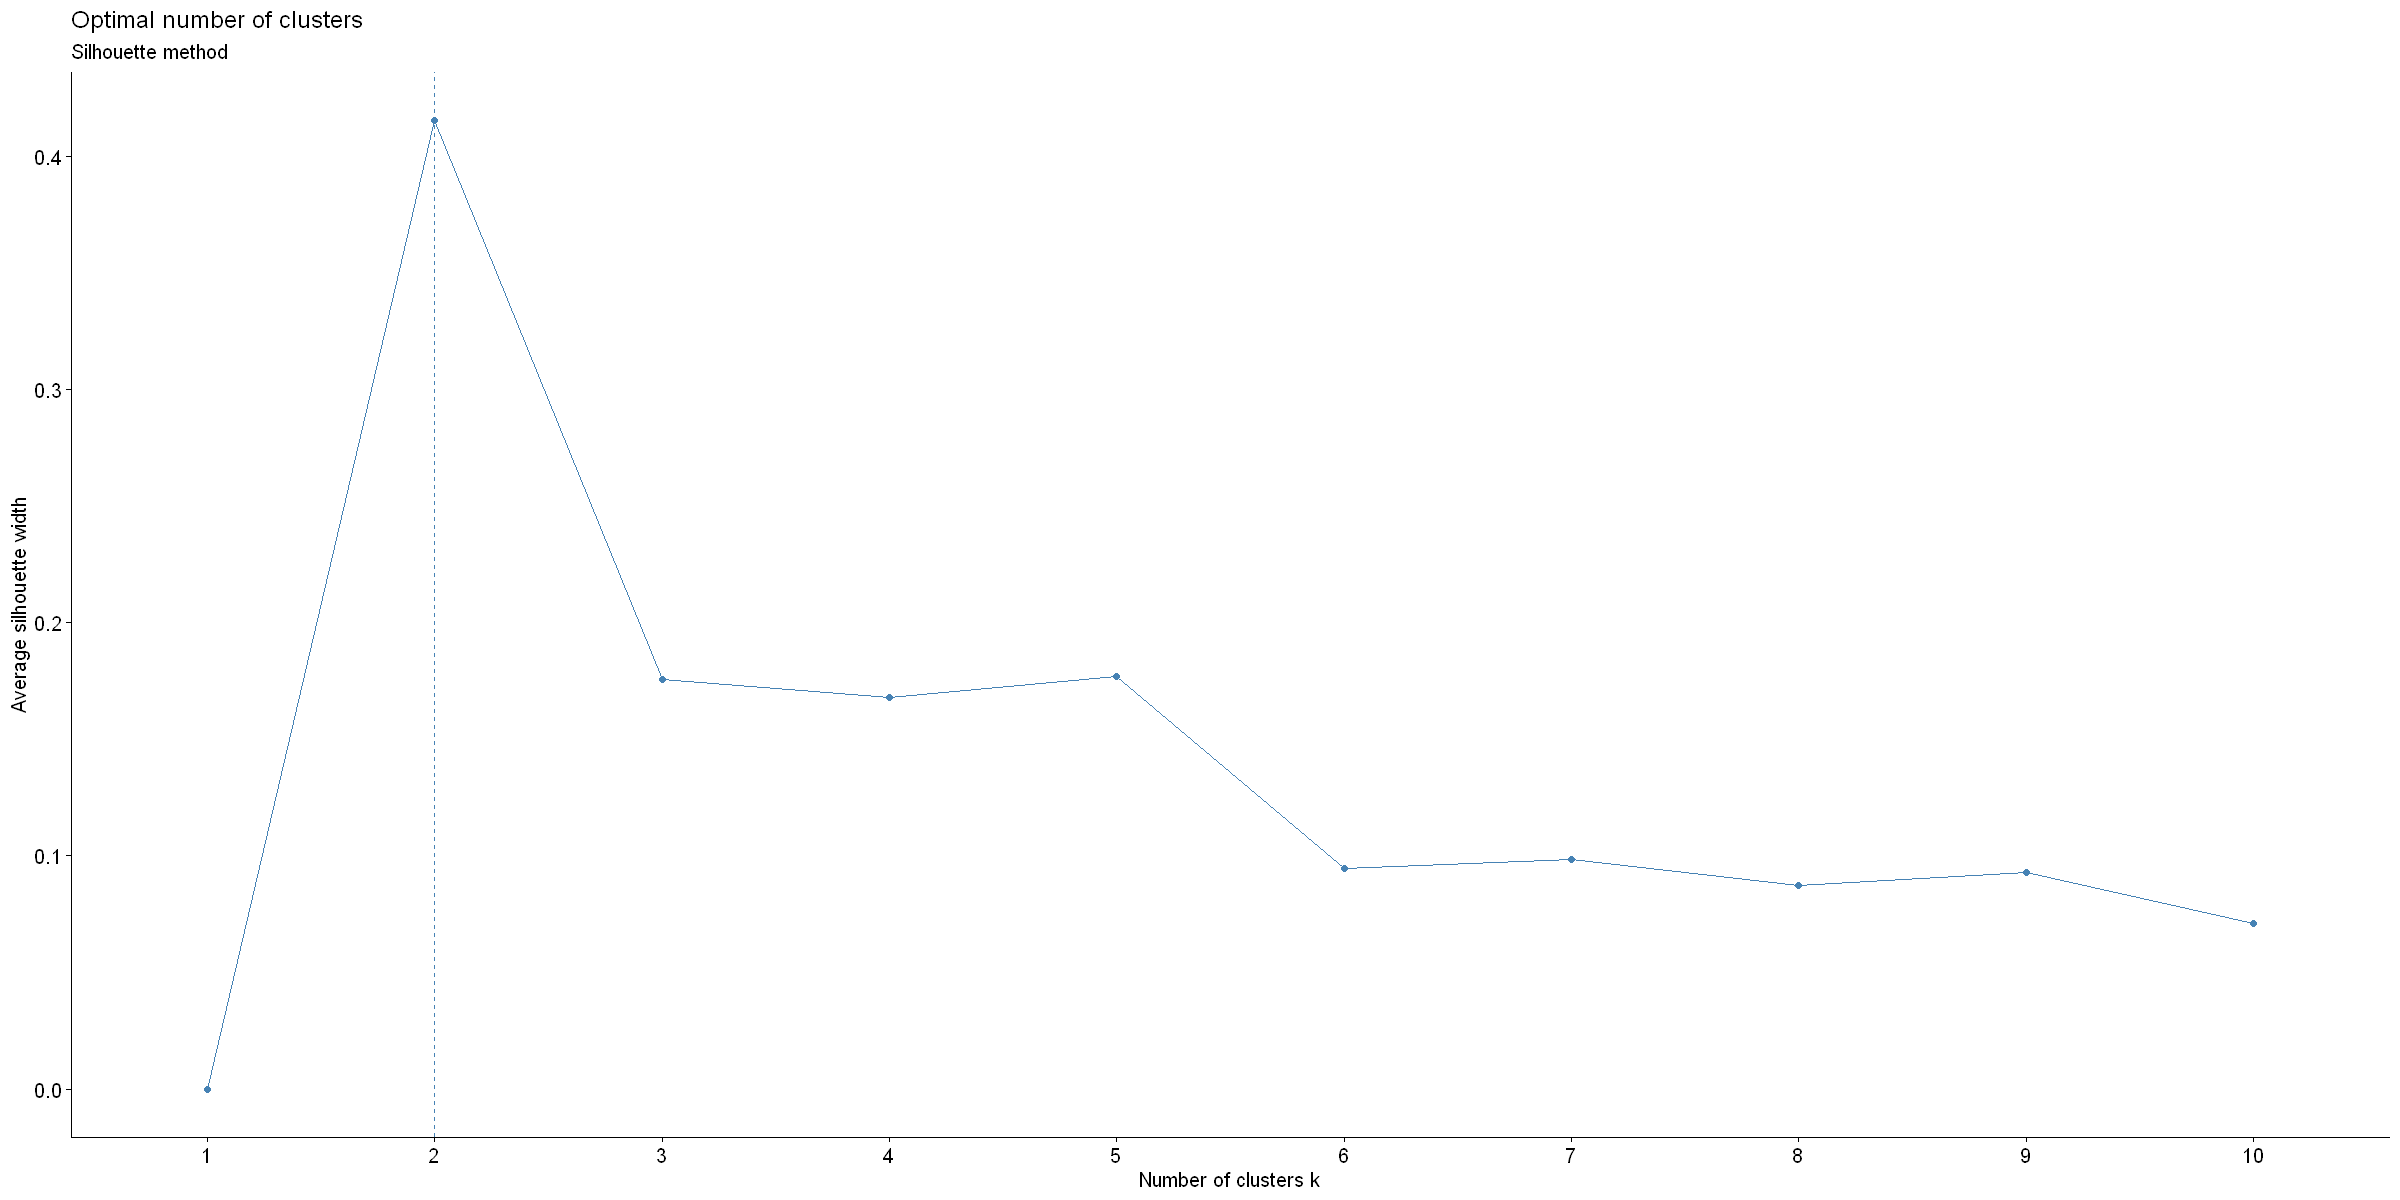

In [389]:
# Silhouette method
fviz_nbclust(Imp_s, hcut, method = "silhouette") + labs(subtitle = "Silhouette method")

In this case, the silouette method seems to find 2 main clusters. There are several other methods to discover the optimal number of clusters and sometimes they do not fully agree. Often, you will need to bring your own knowledge about the specific field to decide whether the number of clusters makes sense.

## <font color = 'darkblue'> 5.3 Heatmaps</font>
<a id="heat_maps"></a>
In the next section we will add an additional layer in our visualization by plotting a heatmap together with the hierarchical clustering.

First, we prepare the 'decoration' for our heatmap. We want to show some of the metadata such as 'ATTRIBUTE_Year', 'ATTRIBUTE_Month' and 'ATTRIBUTE_Sample_Area' colored in a distinctive way. It is much easier to read the heatmap in this way.

We are going to use the ComplexHeatmap package https://jokergoo.github.io/ComplexHeatmap/reference/Heatmap.html

In [390]:
# metadata
colnames(md_Samples)

[1] "filename"                  "ATTRIBUTE_Sample.Type"    
 [3] "ATTRIBUTE_Batch"           "ATTRIBUTE_Month"          
 [5] "ATTRIBUTE_Year"            "ATTRIBUTE_Sample_Location"
 [7] "ATTRIBUTE_Replicate"       "ATTRIBUTE_Spot"           
 [9] "ATTRIBUTE_Latitude"        "ATTRIBUTE_Longitude"      
[11] "ATTRIBUTE_Sample_Area"     "ATTRIBUTE_Spot_Name"      
[13] "ATTRIBUTE_time_run"        "ATTRIBUTE_Injection_order"

In [391]:
# create a dataframe with just the metadata of interest
ann <- data.frame(md_Samples$ATTRIBUTE_Year, md_Samples$ATTRIBUTE_Month, md_Samples$ATTRIBUTE_Sample_Area)
# assign better column names to the dataframe
colnames(ann) <- c('Year', 'Month', 'Area')
# select some colors of your choice. Explore more colors using the RColorBrewer package or by simply check for the hex code https://www.color-hex.com/
colours <- list('Year' = c('2017' = 'orange', '2018' = 'darkgreen'),
  'Month' = c('Dec' = 'orange', 'Jan' = 'darkgreen', 'Oct' = 'red'), 
  'Area' = c('La_Jolla Reefs' = 'orange', 'La_Jolla_Cove' = 'darkgreen', 'Mission_Bay' = 'red', 'Mission_Beach' = 'blue', 'Pacific_Beach' = 'black',
  'SIO_La_Jolla_Shores' = 'grey', 'Torrey_Pines' = 'purple'))
  
# the function in ComplexHeatmap for preparing the annotation object 
colAnn <- HeatmapAnnotation(df = ann,col = colours,annotation_width = unit(c(1, 4), 'cm'),gap = unit(1, 'mm'))

[ComplexHeatmap](https://jokergoo.github.io/ComplexHeatmap/reference/Heatmap.html) gives you a flexible function and it is easy to change parameters. In the following, we will perform hierarchical clustering based on Euclidean distance. ComplexHeatmap uses the R package hclust for this purpose, that we already saw in the previous section. As we said, Euclidean distance is just an example that fits well continuous numerical values in your dataset but there are several distance measures such as Manhattan, Minkowski, Canberra etc.
If you have binary data, you may consider to use Jaccard distance.

In [392]:
# set the parameters for the type of clustering to perform. You can play with different options
set.seed(1234)
hmap <- Heatmap(
  t(Imp_s),
  heatmap_legend_param = list(title = "Scaled/centered\nintensity"), 
  col = c("blue","white","darkred"),
  show_row_names = FALSE,show_column_names = FALSE,
  cluster_rows = TRUE,cluster_columns = TRUE,
  show_column_dend = TRUE,show_row_dend = TRUE,
  row_dend_reorder = TRUE,column_dend_reorder = TRUE,
  clustering_distance_rows = "euclidean",clustering_distance_columns = "euclidean",
  clustering_method_rows = "complete",clustering_method_columns = "complete",
  width = unit(100, "mm"),
  top_annotation = colAnn)

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.



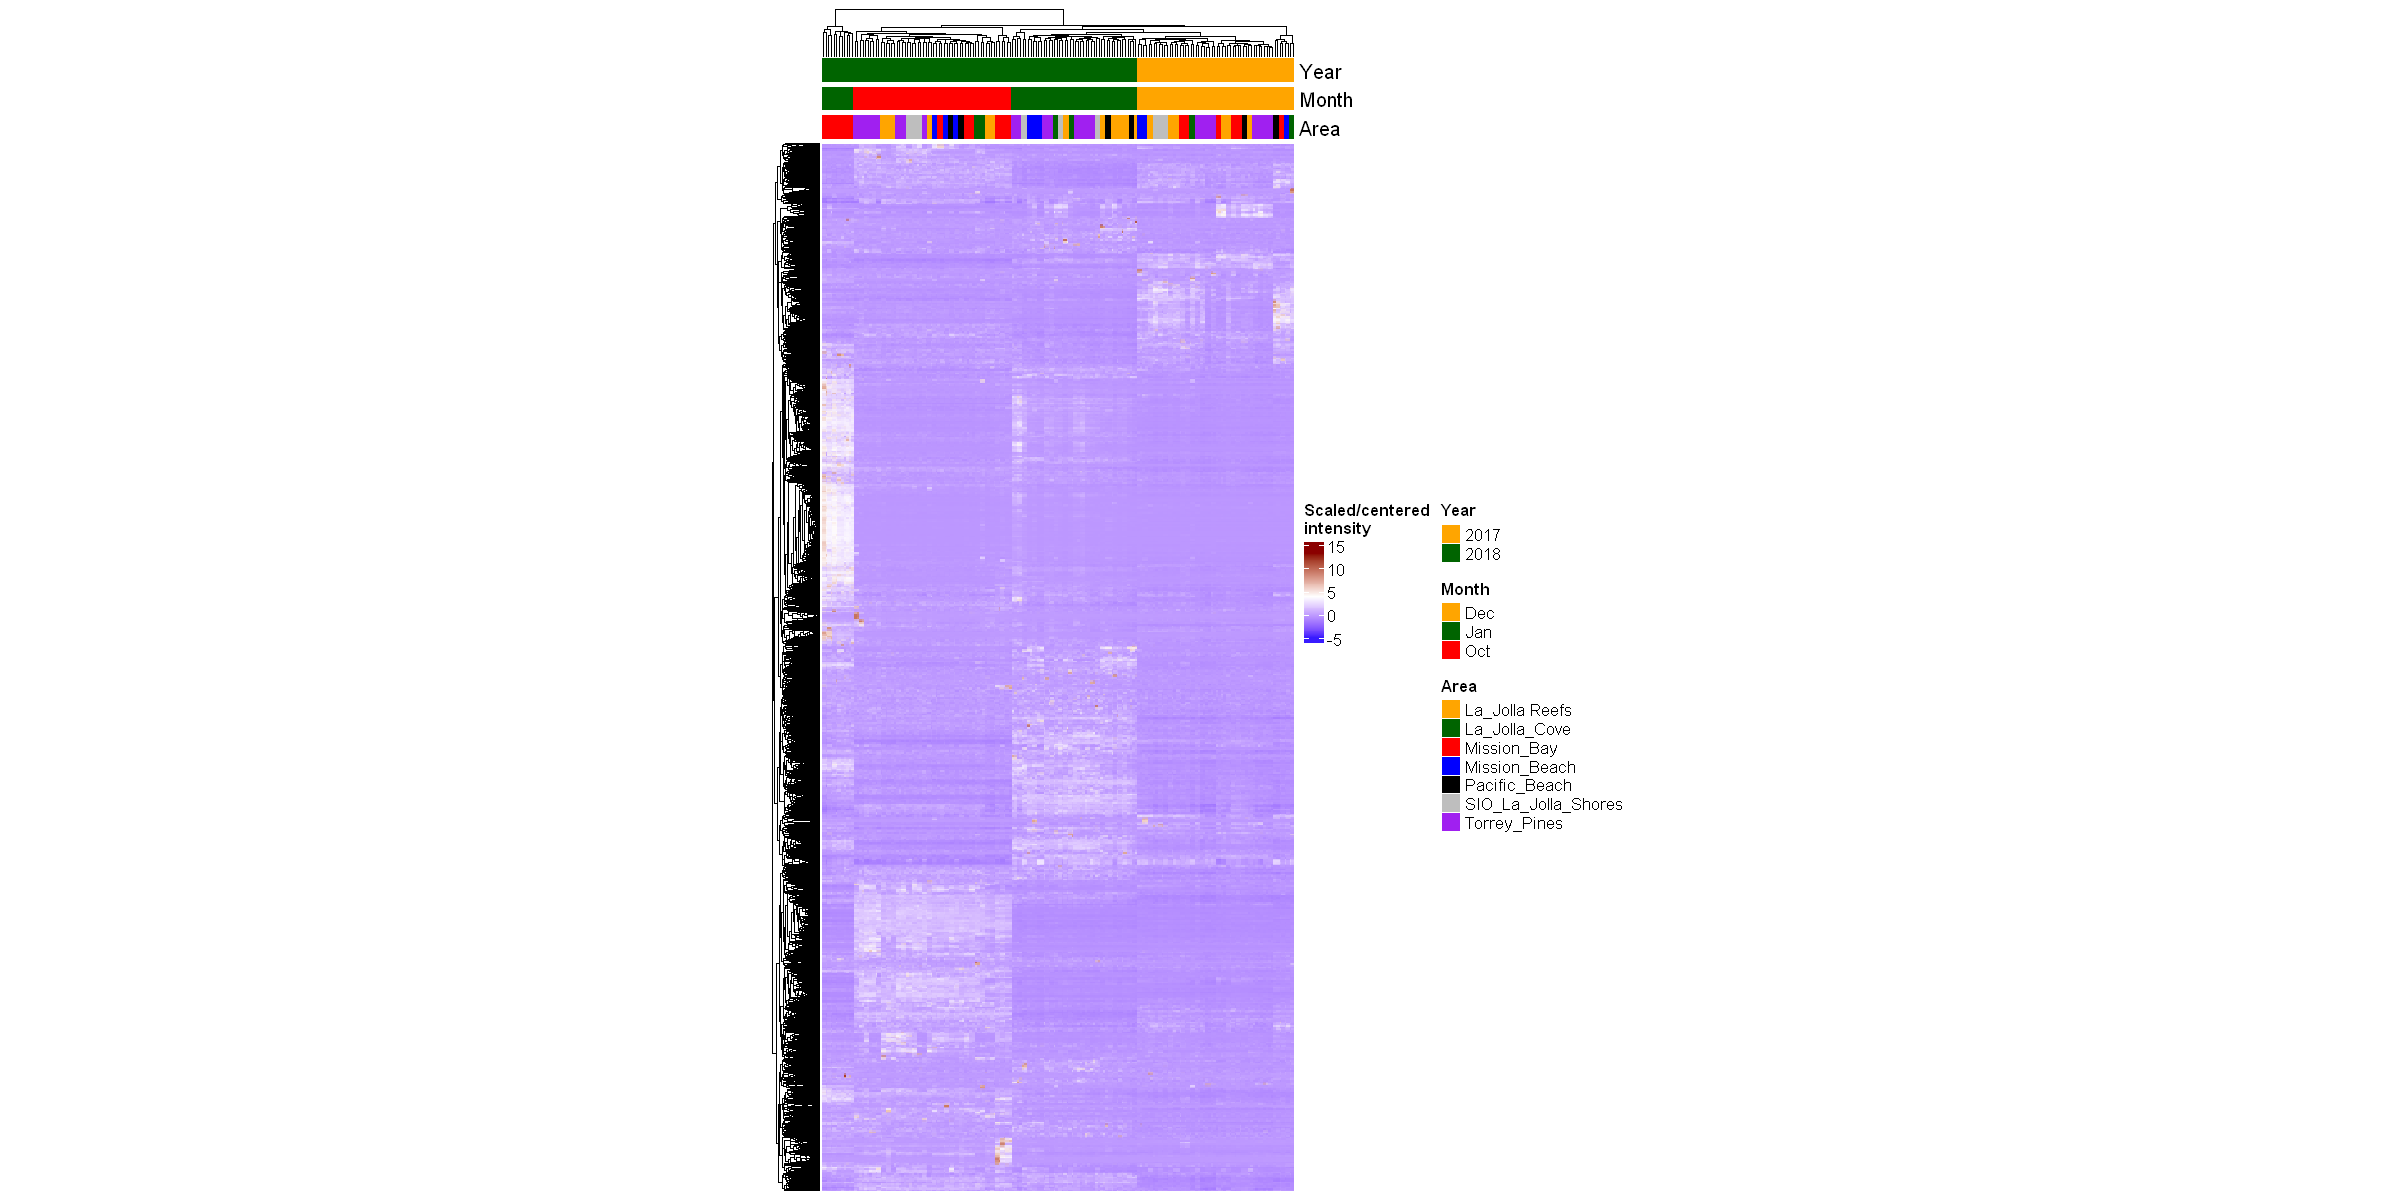

In [393]:
# draw heatmap. It can take some time if your input data is quite large
draw(hmap, heatmap_legend_side="right", annotation_legend_side="right")

As we can see, by using this type of visualization we can clearly observe the similarities between samples and features, in particular we can see again the separation of samples retrieved in 2017 and 2018 and separation based on month. We can also apply a method for dividing the heatmap according to a cluster assignment, similarly to the cutree() step, for generating better visualizations that can help the interpretation of the results.

ComplexHeatmap contains a function to find clusters by using another clustering algorithm called k-means.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.



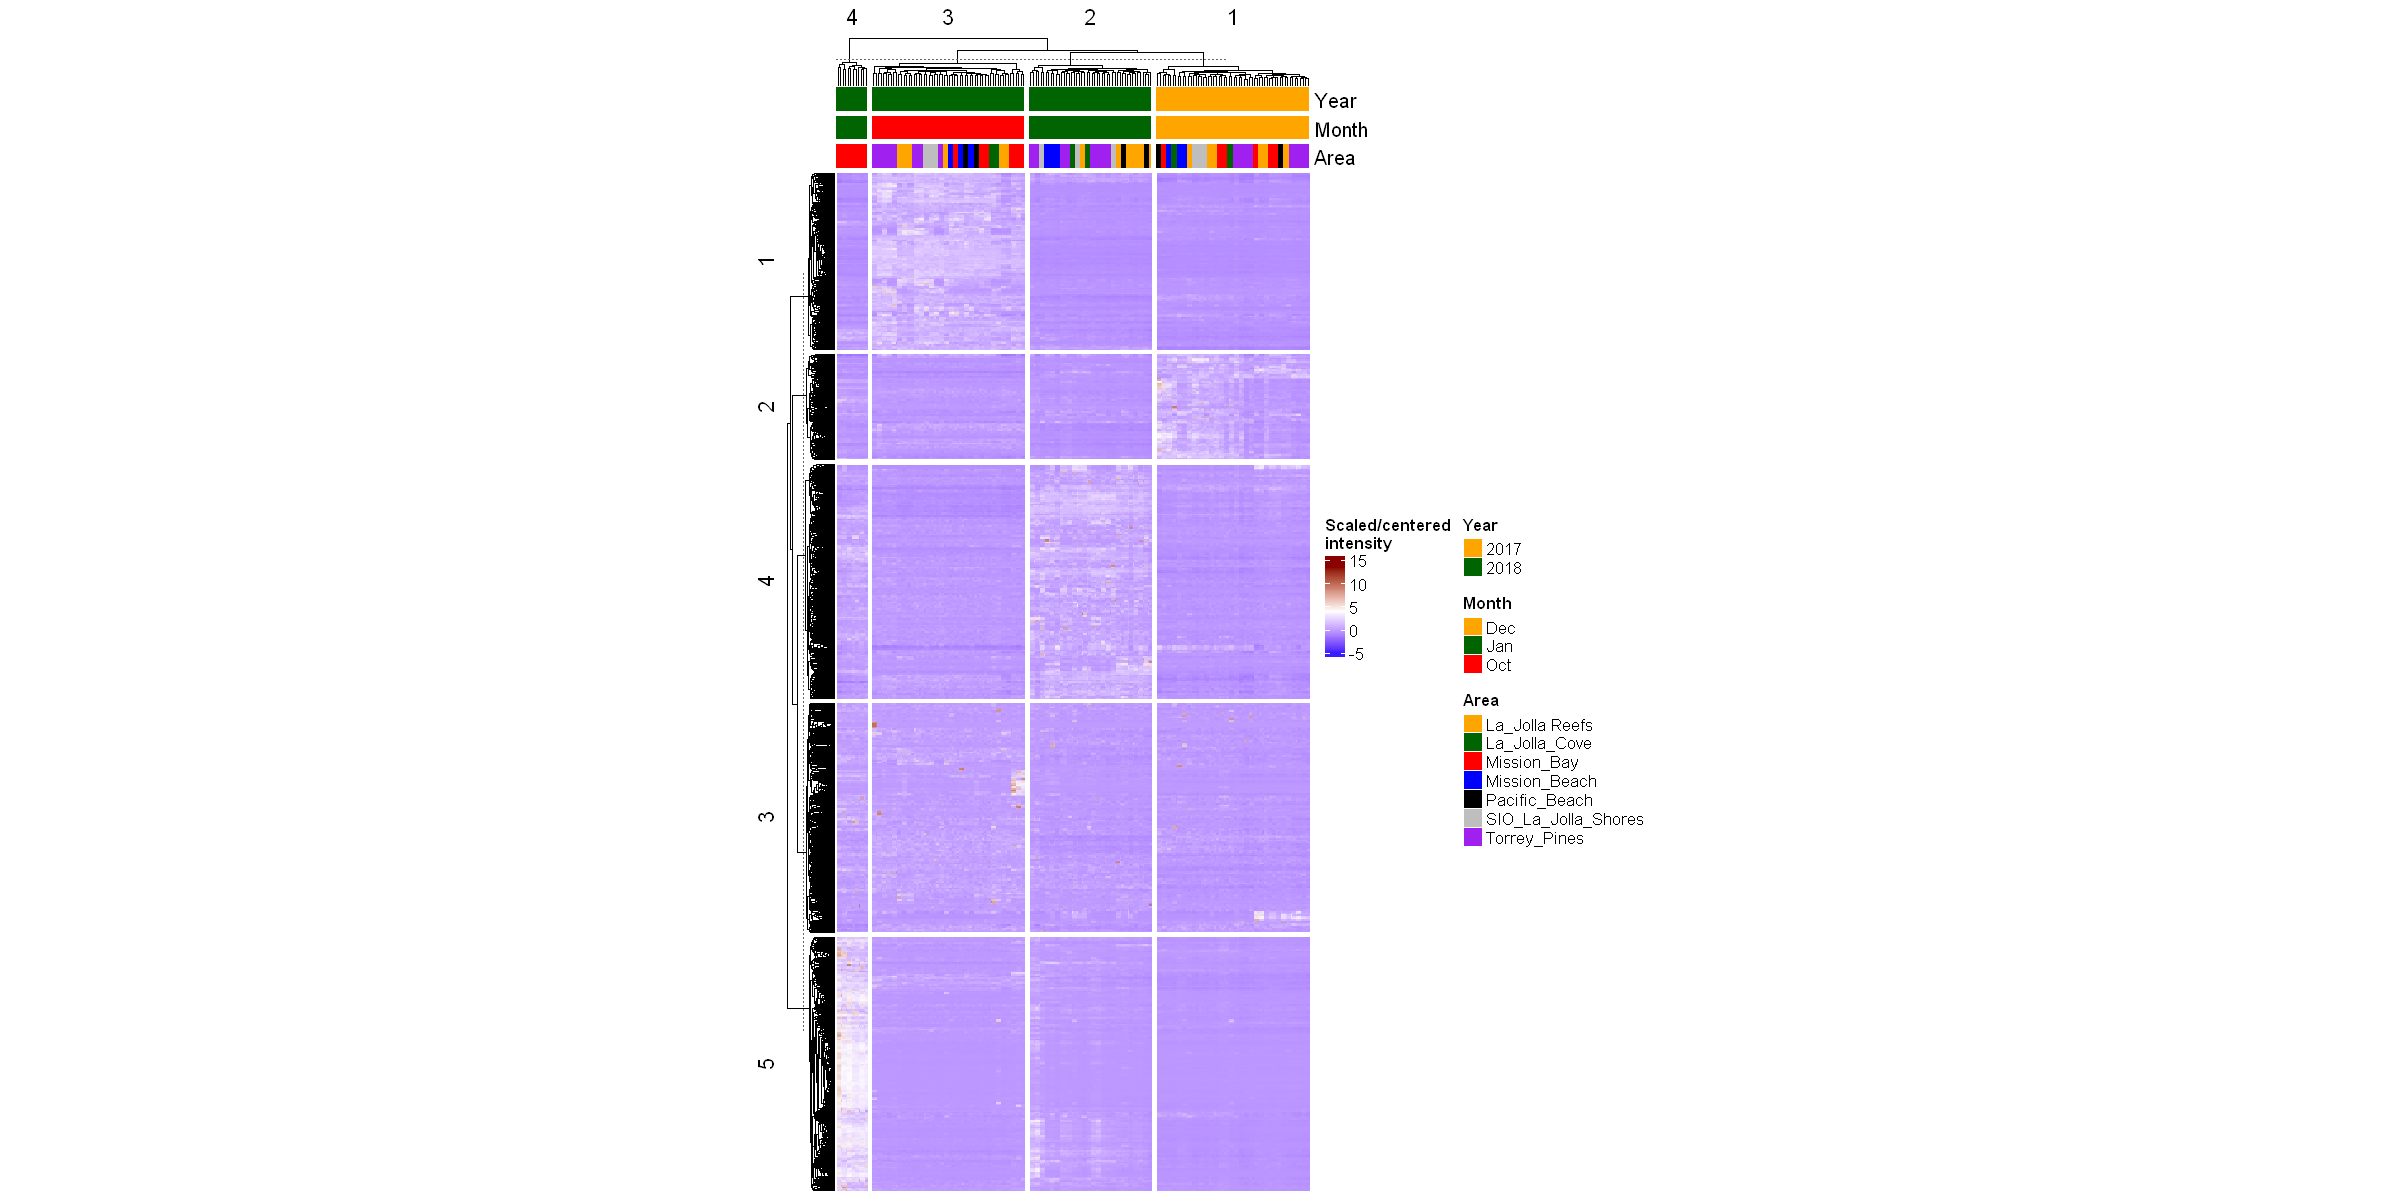

In [394]:
# set the parameters for the type of clustering to perform. You can play with different options
set.seed(1234)
hmap_km <- Heatmap(
  t(Imp_s),
  heatmap_legend_param = list(title = "Scaled/centered\nintensity"), 
  col = c("blue","white","darkred"),
  show_row_names = FALSE,show_column_names = FALSE,
  cluster_rows = TRUE,cluster_columns = TRUE,
  show_row_dend = TRUE,show_column_dend = TRUE,
  row_dend_reorder = TRUE,column_dend_reorder = TRUE,
  clustering_distance_rows = "euclidean",clustering_distance_columns = "euclidean",
  clustering_method_rows = "complete",clustering_method_columns = "complete",
  width = unit(100, "mm"),
  top_annotation = colAnn,
  # Parameters to perform k-means clustering:  
  row_km = 5, row_km_repeats = 100, #row_km indicates the no.of clusters you want in the rows
  column_km = 4, column_km_repeats = 100) #column_km refers to the no.of clusters you want in the columns

# draw heatmap. It can take some time if your input data is quite large
draw(hmap_km, heatmap_legend_side="right", annotation_legend_side="right")

We can see that k-means clustering was able to separate samples retrieved in a particular year and month and highlighted a subgroup (i.e. cluster 4 in the columns) consisting of the area Mission Bay. In the next step, we extract the features belonging to the clusters for future use.

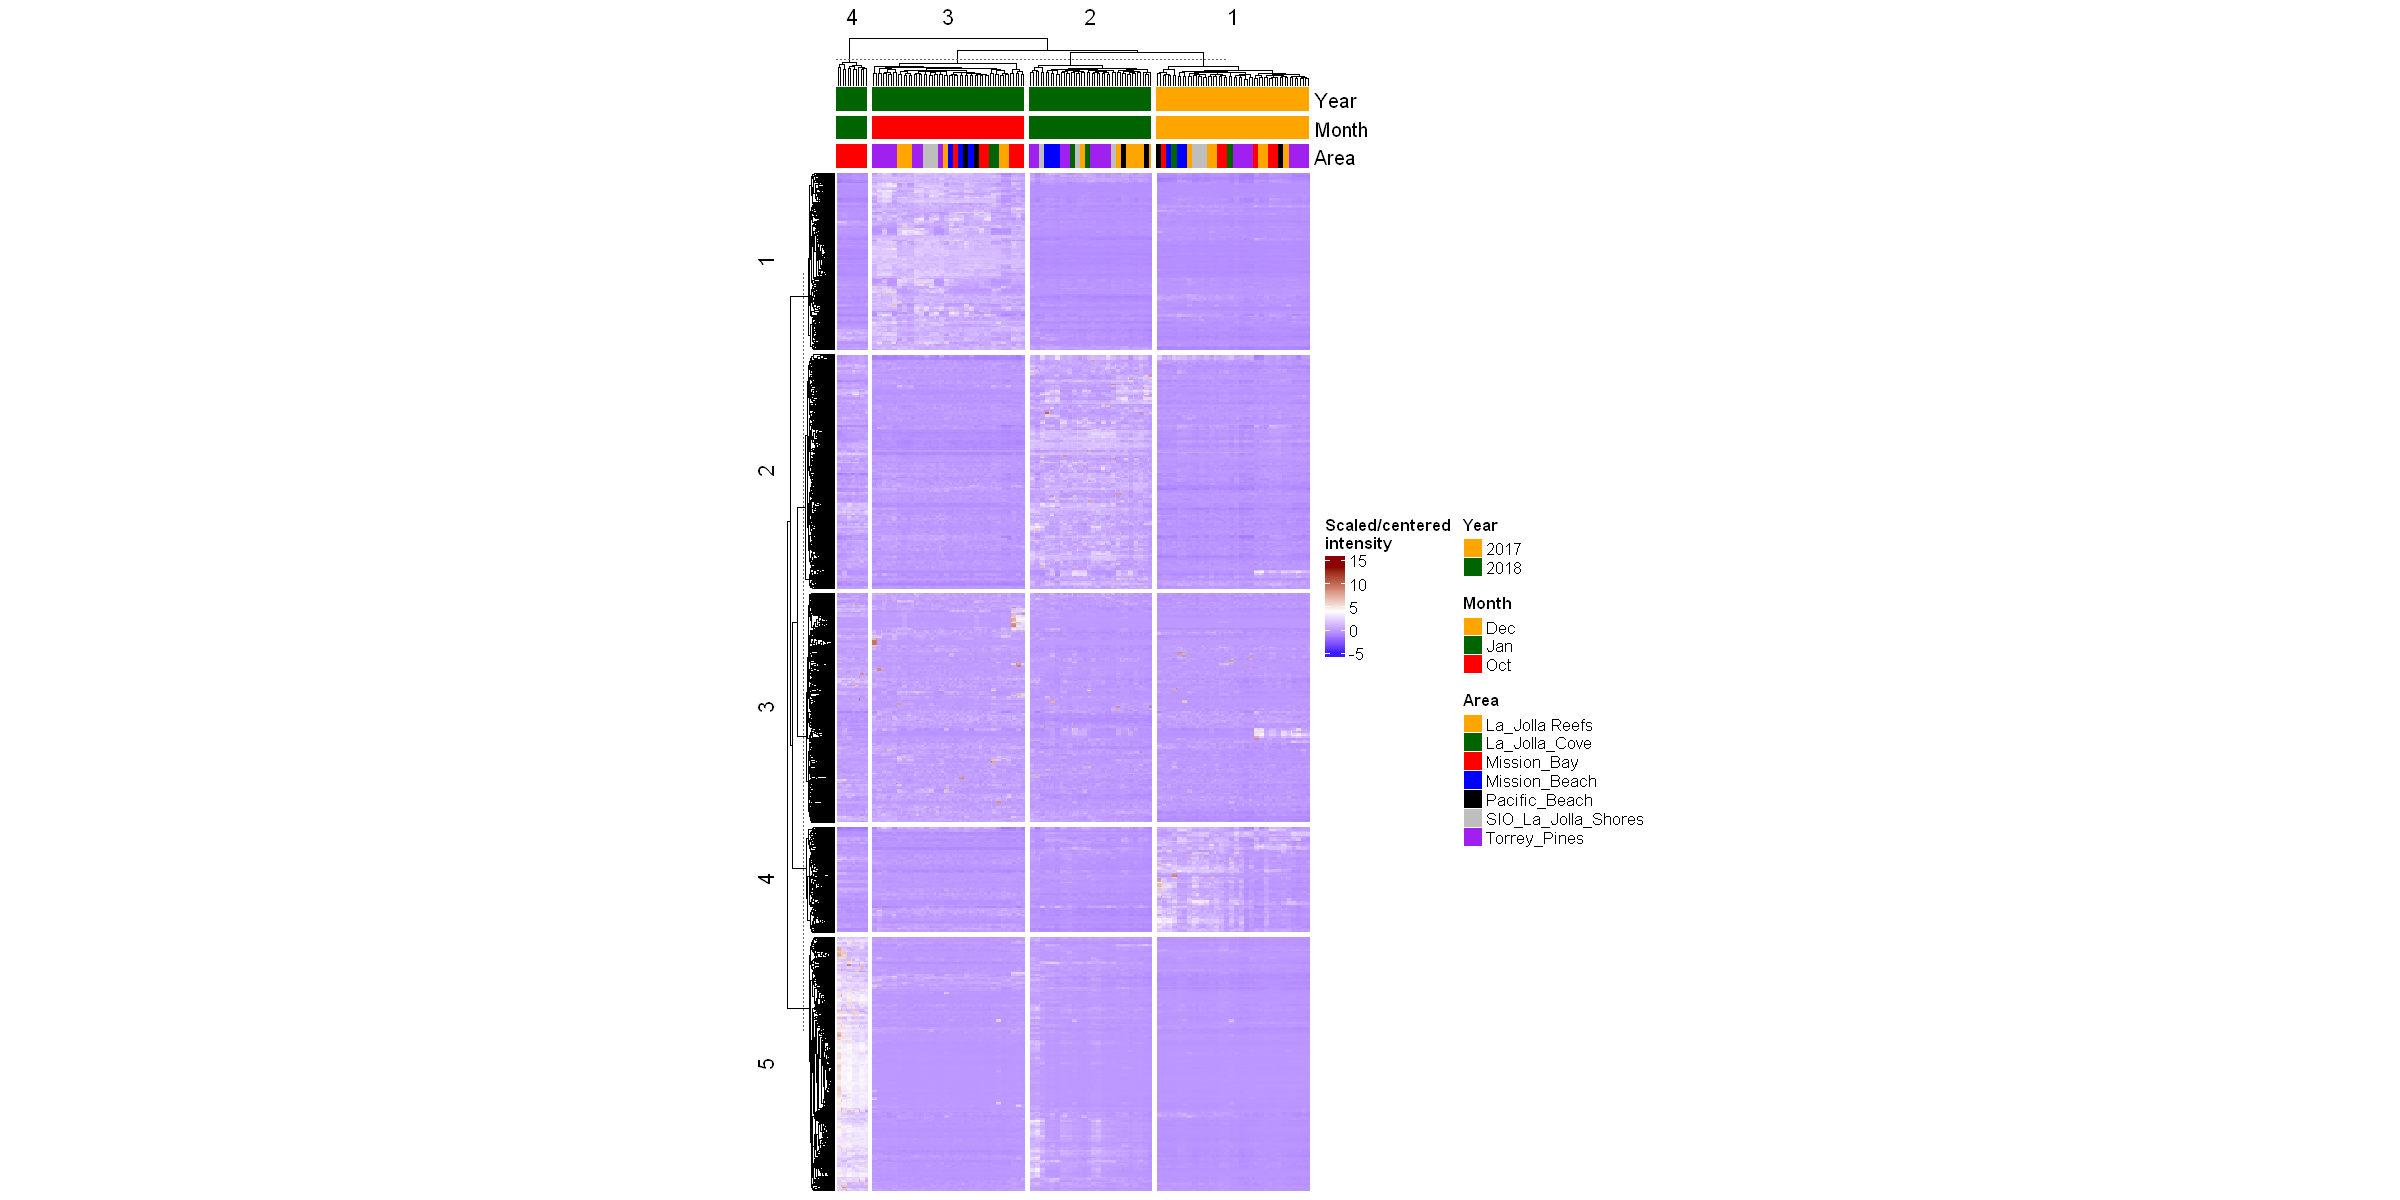

In [395]:
row_order_res <- row_order(draw(hmap_km, heatmap_legend_side="right", annotation_legend_side="right"))  

In [397]:
# check/confirm size of clusters
lapply(row_order_res, length)

$`1`
[1] 1610

$`2`
[1] 2131

$`3`
[1] 2084

$`4`
[1] 958

$`5`
[1] 2309

In [398]:
# loop to extract features for each cluster
out_res <- NULL
for (i in seq_along(row_order_res)){
out_res[[i]] <- cbind(colnames(Imp_s[,row_order_res[[i]]]), paste("cluster", i, sep=""))  
}

out_res <- as.data.frame(do.call(rbind, out_res)) #getting the list elements into a dataframe
colnames(out_res) <- c('feature','cluster')
dim(out_res) # dimension of the object
table(out_res$cluster) # number of features in each cluster
head(out_res)

# save the data frame with cluster information
write.csv(out_res, 'feature_clusters.csv',row.names =F)

[1] 9092    2


cluster1 cluster2 cluster3 cluster4 cluster5 
    1610     2131     2084      958     2309 

,feature,cluster
,<chr>,<chr>
1,X42718_404.279_5.866,cluster1
2,X58369_528.939_7.527,cluster1
3,X58299_526.942_7.512,cluster1
4,X58341_530.936_7.518,cluster1
5,X64278_356.258_8.316,cluster1
6,X70921_518.168_9.302,cluster1


In [ ]:
# save the heatmap in svg format.The plot can be imported & modified  in Illustrator or similar program.
svglite('heatmap.svg', width=10, height=8, bg='white')
draw(hmap_km, heatmap_legend_side="right", annotation_legend_side="right")
dev.off()

# <font color = 'blue'> 6. Supervised learning with XGBoost</font>
<a id="xgboost"></a>
In the next section we are going to use the eXtreme Gradient Boosting (XGBoost) algorithm to predict the rainfall variable, that is a binary class (samples retrieved in January are encoded as 1 while all the other months are encoded as 0).
We are going to use the object 'Data' from the previous Univariate analysis which already contains the imputed and scaled/centered feature table and the metadata.

Useful info:
<a href="https://xgboost.readthedocs.io/en/stable/R-package/xgboostPresentation.html">R package for training an XGBoost model</a>, <a href="https://topepo.github.io/caret/">R package 'Caret' for training different machine learning models</a>

Another aspect to consider is that in case our class of interest is binary and unbalanced, we need to take it into account during training our XGBoost model. We can do that by using the paramter <a href="https://xgboost.readthedocs.io/en/latest/parameter.html">scale_pos_weight</a>, where a typical value to consider is sum(negative instances) / sum(positive instances).

In [406]:
# Distribution of binary class:
table(Data$rainfall)


  0   1 
120  60 

In [407]:
# metadata
head(Data[,1:15])

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,rainfall,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,1,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:36,65
2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,1,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:52,66
3,SD_01-2018_10_a.mzXML,Sample,2,Jan,2018,10,a,10,32.86261,1,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,16/01/2018 16:23,83
4,SD_01-2018_10_b.mzXML,Sample,2,Jan,2018,10,b,10,32.86261,1,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,16/01/2018 16:39,84
5,SD_01-2018_11_a.mzXML,Sample,2,Jan,2018,11,a,11,32.85601,1,-117.2625,SIO_La_Jolla_Shores,La_Jolla_Shores,16/01/2018 16:55,85
6,SD_01-2018_11_b.mzXML,Sample,2,Jan,2018,11,b,11,32.85601,1,-117.2625,SIO_La_Jolla_Shores,La_Jolla_Shores,16/01/2018 17:10,86


In [408]:
# metabolomics data
head(Data[,16:ncol(Data)])

,X10015_282.169_2.763,X10035_325.139_2.817,X10037_216.123_2.847,X10047_338.159_2.845,X10058_280.117_2.961,X10059_414.175_2.851,X10072_305.157_2.851,X10074_283.175_2.851,X10078_300.201_2.851,X10082_309.144_2.886,⋯,X9833_268.175_2.821,X9860_240.144_2.824,X9876_414.139_2.761,X9884_190.05_2.832,X9897_333.144_2.881,X9909_400.16_2.813,X9918_252.123_2.833,X9957_402.139_3.01,X9972_323.123_2.716,X9995_276.159_2.805
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.1304738,-0.2996871,-0.1117275,2.2186171,-1.45214596,-0.17593037,-0.3434611,-0.1778404,-0.1933466,-0.98676658,⋯,0.50953425,0.3411530,-0.9690079,-0.2136334,-1.0317304,-0.3097998,-0.177995,1.1679223,-0.9536029,-0.720846274
2,-1.1265155,-0.6037355,1.9885898,0.2986375,-1.02831734,0.38485813,-0.3749450,-0.1894778,-0.1876122,0.01064504,⋯,0.09238905,0.5326194,1.0516269,-0.3038794,-0.1930184,-0.7478181,1.252001,0.9551530,-0.9361819,-0.008639177
3,-0.6995949,-0.4612301,-0.3618842,1.2580121,0.74726202,-0.05869551,-0.4289946,-0.2615139,-0.2501572,-0.56453788,⋯,-0.24639335,-0.2865859,4.3836879,-0.6676765,-0.4632050,4.5197644,2.438135,-0.7384554,1.9221174,0.486389335
4,-0.2034930,-0.4966067,-0.2732191,1.3559666,-1.39170040,-0.28478919,-0.3536444,-0.2742151,-0.2619255,-0.55716658,⋯,-0.25192058,-0.2285435,0.4843269,-0.5684610,1.5535042,-0.8303057,1.434401,4.0595393,0.6681850,0.985037345
5,-0.7347561,0.6853785,-0.1363040,2.9093771,0.06876711,-1.01309686,-0.3657459,-0.2944197,-0.3309941,-0.53668380,⋯,-0.28563018,-0.2476378,1.5809568,-0.6620708,0.3906509,-0.6962297,2.185162,-0.5521619,0.4461508,1.021271440
6,-0.7096955,-0.6041134,0.2861766,1.1639750,0.64835653,-0.18424409,-0.4531317,-0.3184602,-0.2880191,-0.56447259,⋯,-0.24677023,-0.2403817,0.3811471,-0.6653472,-1.1098859,3.4050080,1.824056,-0.6258216,-0.7639999,-0.815254939


## <font color = 'darkblue'> 6.1 Prepare input data: split train and test sets </font>
<a id="train_test"></a>
We devide the feature table in training and test sets. According to the sample size we can usually make a partition of the data to obtain 80% for the train and 20% for the test. In our case, we have a relative small sample size, therefore we will use 70% of the data for the train and 30% for the test set to have enough samples in each class.

In [409]:
# Set random seed to make results reproducible
set.seed(1234)
trainIndex <- caret::createDataPartition(Data$ATTRIBUTE_Sample_Area, p = 0.7, 
                                  list = FALSE, 
                                  times = 1)

ftTrain <- Data[trainIndex,]
ftTest  <- Data[-trainIndex,]

dim(ftTrain)
dim(ftTest)

[1]  130 9107

[1]   50 9107

In [410]:
table(ftTrain$ATTRIBUTE_Sample_Area) #class distribution for train
table(ftTest$ATTRIBUTE_Sample_Area) #class distribution for test


     La_Jolla Reefs       La_Jolla_Cove         Mission_Bay       Mission_Beach 
                 26                   9                  26                  13 
      Pacific_Beach SIO_La_Jolla_Shores        Torrey_Pines 
                  9                  13                  34 


     La_Jolla Reefs       La_Jolla_Cove         Mission_Bay       Mission_Beach 
                 10                   3                  10                   5 
      Pacific_Beach SIO_La_Jolla_Shores        Torrey_Pines 
                  3                   5                  14 

In [411]:
# prepare input data (feature table and binary class) for XGBoost
train_x <- ftTrain[,16:ncol(ftTrain)] # metabolomics data
train_y <- as.factor(ftTrain$ATTRIBUTE_Sample_Area) # variable of interest
test_x <- ftTest[,16:ncol(ftTest)] # metabolomics data
test_y <- as.factor(ftTest$ATTRIBUTE_Sample_Area) # variable of interest

In [412]:
dim(train_x)
table(train_y)
dim(test_x)
table(test_y)

[1]  130 9092

train_y
     La_Jolla Reefs       La_Jolla_Cove         Mission_Bay       Mission_Beach 
                 26                   9                  26                  13 
      Pacific_Beach SIO_La_Jolla_Shores        Torrey_Pines 
                  9                  13                  34 

[1]   50 9092

test_y
     La_Jolla Reefs       La_Jolla_Cove         Mission_Bay       Mission_Beach 
                 10                   3                  10                   5 
      Pacific_Beach SIO_La_Jolla_Shores        Torrey_Pines 
                  3                   5                  14 

## <font color ="darkblue"> 6.2 XGBoost model with default parameters</font>
<a id="xgboost_def"></a>
First, we perform the analysis without tuning the parameters, by using default/recommended parameters to see how our basic XGBoost model performs.

In [413]:
# scale_pos_weight value to consider in case we have a binary class of interest and it is unbalanced
# scalePosWeight <- sum(train_y==0) / sum(train_y==1)
# scalePosWeight

In [414]:
grid_default <- expand.grid(
  nrounds = 500,
  max_depth = 6,
  eta = 0.3,
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)

train_control <- caret::trainControl(
  method = "none",
  verboseIter = FALSE,
  allowParallel = TRUE
)

set.seed(1234)
xgb_base <- caret::train(
  x = train_x, y = train_y,
  trControl = train_control,
  tuneGrid = grid_default,
  method = "xgbTree",
  verbose = TRUE,
  # scale_pos_weight = scalePosWeight,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [415]:
gc() # free memory
xgb_base

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8463902,452.1,23934840,1278.3,23934840,1278.3
Vcells,108177683,825.4,230485666,1758.5,230485666,1758.5


eXtreme Gradient Boosting 

 130 samples
9092 predictors
   7 classes: 'La_Jolla Reefs', 'La_Jolla_Cove', 'Mission_Bay', 'Mission_Beach', 'Pacific_Beach', 'SIO_La_Jolla_Shores', 'Torrey_Pines' 

No pre-processing
Resampling: None 

We predict on the test set and show the performance using the confusionMatrix function from the caret package. More information about the statistics can be found at https://rdrr.io/cran/caret/man/confusionMatrix.html.

In [416]:
# predict on test data
predicted_base <- predict(xgb_base, test_x)
# performance
confusionMatrix(data = predicted_base, reference = test_y, positive = '1', mode = 'everything')

Confusion Matrix and Statistics

                     Reference
Prediction            La_Jolla Reefs La_Jolla_Cove Mission_Bay Mission_Beach
  La_Jolla Reefs                   8             0           0             0
  La_Jolla_Cove                    0             2           0             0
  Mission_Bay                      0             0          10             1
  Mission_Beach                    0             0           0             4
  Pacific_Beach                    2             0           0             0
  SIO_La_Jolla_Shores              0             1           0             0
  Torrey_Pines                     0             0           0             0
                     Reference
Prediction            Pacific_Beach SIO_La_Jolla_Shores Torrey_Pines
  La_Jolla Reefs                  1                   1            0
  La_Jolla_Cove                   0                   0            0
  Mission_Bay                     1                   0            0
  Mission_Bea

As we can see from the result above, we get an overview of the predictions and performance metrics for each class. Moreover, we get the overall Accuracy (in this case 0.8).

In [417]:
# get the probability matrix;
prediction_probs_base <- predict(xgb_base, test_x, type = "prob")

In [418]:
# probability matrix for each sampling area, that is the probability a sample belongs to a sampling area
head(prediction_probs_base)

,La_Jolla Reefs,La_Jolla_Cove,Mission_Bay,Mission_Beach,Pacific_Beach,SIO_La_Jolla_Shores,Torrey_Pines
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.005248298,0.016946796,0.021387147,0.003624770,0.002733320,0.035340570,0.914719105
2,0.024278818,0.349722177,0.063845120,0.086620703,0.052364636,0.402189225,0.020979339
3,0.858547628,0.007774164,0.010009320,0.011996829,0.026113506,0.077554032,0.008004516
4,0.169616744,0.005782446,0.020781940,0.010862703,0.781848848,0.005518070,0.005589298
5,0.119383901,0.006615007,0.009400726,0.035312124,0.815334857,0.007559339,0.006394048
6,0.004444454,0.020675076,0.019218670,0.007734112,0.003753883,0.019449066,0.924724698


We apply the function multiclass.roc from the pROC package for computing a [multi-class AUC](https://www.rdocumentation.org/packages/pROC/versions/1.18.0/topics/multiclass.roc), which uses an approach proposed by [Hand and Till](https://link.springer.com/article/10.1023/A:1010920819831) for calculating AUC in multi-class. As reported in the pROC package, a multiclass AUC is a mean of several AUCs and cannot be plotted. Only AUCs can be computed for such curves. Confidence intervals, standard deviation, smoothing and comparison tests are not implemented.

In [419]:
ROC_base <- pROC::multiclass.roc(test_y, prediction_probs_base) #ROC
ROC_base$auc # AUC

Multi-class area under the curve: 0.902

From the previous result, we can see that the multi-class AUC is 0.902. This result is quite good but of course we need to be careful with conclusions since our dataset is not very large. <br>
In the following we provide code for improving the performance by tuning important parameters in XGBoost and at the same time to avoid potential overfitting by using cross-validation. There are different ways of tuning parameters. In the following we train different models, optimizing step by step the important parameters in XGBoost.  

## <font color ="darkblue"> 6.3 Tuning parameters in XGBoost</font>
<a id="xgboost_tune"></a>

### 6.3.1 Tuning Number of Iterations and the Learning Rate
A high number of iterations (nrounds) makes the algorithm slower but at the same time we need a good number of iterations for testing several combinations of parameters. The number of folds in the cross-validation can also slow down the computation. Just to show how this works, here we set nrounds=500 and number of folds = 5 but consider increasing these numbers to nrounds=1000 and number of folds = 10.

In [420]:
nrounds <- 500

In [421]:
tune_grid <- expand.grid(
  nrounds = seq(from = 100, to = nrounds, by = 10),
  eta = c(0.025, 0.05, 0.1, 0.3),
  max_depth = seq(from = 2, to = 10, by = 2),
  #max_depth = 6,
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)

In [422]:
tune_control <- caret::trainControl(
  method = "cv", # cross-validation
  number = 5, # number of folds
  repeats = NA,
  verboseIter = FALSE,
  allowParallel = TRUE
)

In [423]:
set.seed(1234)
xgb_tune <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [424]:
gc() #free memory

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8519865,455.1,23934840,1278.3,23934840,1278.3
Vcells,108666392,829.1,230485666,1758.5,230485666,1758.5


### 6.3.2 Tuning Maximum Depth and Minimum Child Weight

In [425]:
tune_grid2 <- expand.grid(
  nrounds = seq(from = 100, to = nrounds, by = 10),
  eta = xgb_tune$bestTune$eta,
  max_depth = ifelse(xgb_tune$bestTune$max_depth == 2, c(xgb_tune$bestTune$max_depth:10),
  xgb_tune$bestTune$max_depth - 1:xgb_tune$bestTune$max_depth + 1),
  #max_depth = seq(from = 2, to = 10, by = 1),
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = c(1, 2, 3),
  subsample = 1
)

In [426]:
set.seed(1234)
xgb_tune2 <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid2,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

### 6.3.3 Tuning Column and Row Sampling

In [427]:
tune_grid3 <- expand.grid(
  nrounds = seq(from = 100, to = nrounds, by = 10),
  eta = xgb_tune$bestTune$eta,
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = 0,
  colsample_bytree = c(0.4, 0.6, 0.8, 1.0),
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = c(0.5, 0.75, 1.0)
)

In [428]:
set.seed(1234)
xgb_tune3 <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid3,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

### 6.3.4 Tuning Gamma

In [429]:
tune_grid4 <- expand.grid(
  nrounds = seq(from = 100, to = nrounds, by = 10),
  eta = xgb_tune$bestTune$eta,
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = c(0, 0.05, 0.1, 0.5, 0.7, 0.9, 1.0),
  colsample_bytree = xgb_tune3$bestTune$colsample_bytree,
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = xgb_tune3$bestTune$subsample
)

In [430]:
set.seed(1234)
xgb_tune4 <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid4,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [431]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8553317,456.8,23934840,1278.3,23934840,1278.3
Vcells,109544120,835.8,230485666,1758.5,230485666,1758.5


### 6.3.5 Reducing the Learning Rate

In [432]:
tune_grid5 <- expand.grid(
  nrounds = seq(from = 100, to = 1000, by = 100),
  eta = c(0.01, 0.015, 0.025, 0.05, 0.1),
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = xgb_tune4$bestTune$gamma,
  colsample_bytree = xgb_tune3$bestTune$colsample_bytree,
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = xgb_tune3$bestTune$subsample
)

In [433]:
set.seed(1234)
xgb_tune5 <- caret::train(
    x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid5,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [434]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8563763,457.4,23934840,1278.3,23934840,1278.3
Vcells,109790762,837.7,230485666,1758.5,230485666,1758.5


### 6.3.6 Fitting the final model using the best parameters from the previous step

In [435]:
final_grid <- expand.grid(
  nrounds = xgb_tune5$bestTune$nrounds,
  eta = xgb_tune5$bestTune$eta,
  max_depth = xgb_tune5$bestTune$max_depth,
  gamma = xgb_tune5$bestTune$gamma,
  colsample_bytree = xgb_tune5$bestTune$colsample_bytree,
  min_child_weight = xgb_tune5$bestTune$min_child_weight,
  subsample = xgb_tune5$bestTune$subsample
)

In [436]:
set.seed(1234)
xgb_model_final <- caret::train(
  x = train_x, y = train_y,
  trControl = train_control,
  tuneGrid = final_grid,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [437]:
predicted_final <- predict(xgb_model_final, test_x) # predict on test data
confusionMatrix(data = predicted_final, reference = test_y) #getting the confusion matrix

Confusion Matrix and Statistics

                     Reference
Prediction            La_Jolla Reefs La_Jolla_Cove Mission_Bay Mission_Beach
  La_Jolla Reefs                  10             1           0             0
  La_Jolla_Cove                    0             2           0             0
  Mission_Bay                      0             0           9             1
  Mission_Beach                    0             0           1             4
  Pacific_Beach                    0             0           0             0
  SIO_La_Jolla_Shores              0             0           0             0
  Torrey_Pines                     0             0           0             0
                     Reference
Prediction            Pacific_Beach SIO_La_Jolla_Shores Torrey_Pines
  La_Jolla Reefs                  2                   0            0
  La_Jolla_Cove                   0                   0            0
  Mission_Bay                     1                   0            0
  Mission_Bea

In [438]:
prediction_probs_tuned <- predict(xgb_model_final, test_x, type = "prob") # get the probability matrix

In [439]:
ROC_tuned <- pROC::multiclass.roc(test_y, prediction_probs_tuned) #ROC
ROC_tuned$auc #AUC

Multi-class area under the curve: 0.9409

In [440]:
gc() # free memory
stopCluster(cl) # stop cluster

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8575009,458.0,23934840,1278.3,23934840,1278.3
Vcells,110028890,839.5,230485666,1758.5,230485666,1758.5


From tuning parameters in 5-fold cross-validation, we obtained an improvement in performance and the final AUC is 0.94 and Accuracy is 0.84. Again, remember that our sample size is not very large and it needs to be considered in any predictive task. The code here is intended to provide you a guide for building an XGBoost model and tuning important parameters but a particular attention is needed when building these models to avoid issues such as overfitting/underfitting and reaching wrong conclusions. 


## <font color ="darkblue"> 6.4 Ranking features by importance </font>
<a id="xgboost_rank"></a>
We can also rank the feature by importance. The top features had a larger impact on determining the prediction of sampling area. Note that the R package caret estimates feature importance from the final model fitted, and not from the cross-validations. This is automatically given to the caret function varImp.

In [441]:
varImp(xgb_model_final, scale = T)

xgbTree variable importance

  only 20 most important variables shown (out of 9092)

                       Overall
X92112_906.258_12.941   100.00
X59188_312.231_7.625     80.42
X91372_906.258_12.697    71.22
X54129_381.808_6.99      65.78
X91133_907.259_12.628    44.40
X53617_424.868_6.93      36.73
X57492_331.081_7.416     33.11
X83607_480.549_10.728    32.57
X86594_755.487_11.127    30.02
X89535_1223.342_12.013   28.85
X54153_379.81_6.988      25.83
X1891_246.097_0.884      23.94
X89388_908.258_12.002    23.21
X82651_261.242_10.62     20.91
X89481_856.607_11.931    20.13
X33400_291.046_4.979     20.08
X91699_932.629_12.77     19.87
X13057_394.185_3.173     19.39
X83280_732.576_10.633    18.90
X78984_219.174_10.107    18.78

We can also plot the top 20 features. Change the 'top' parameter for plotting more features. The feature importance is based on the 'Gain' calculation. For more details https://xgboost.readthedocs.io/en/latest/tutorials/model.html

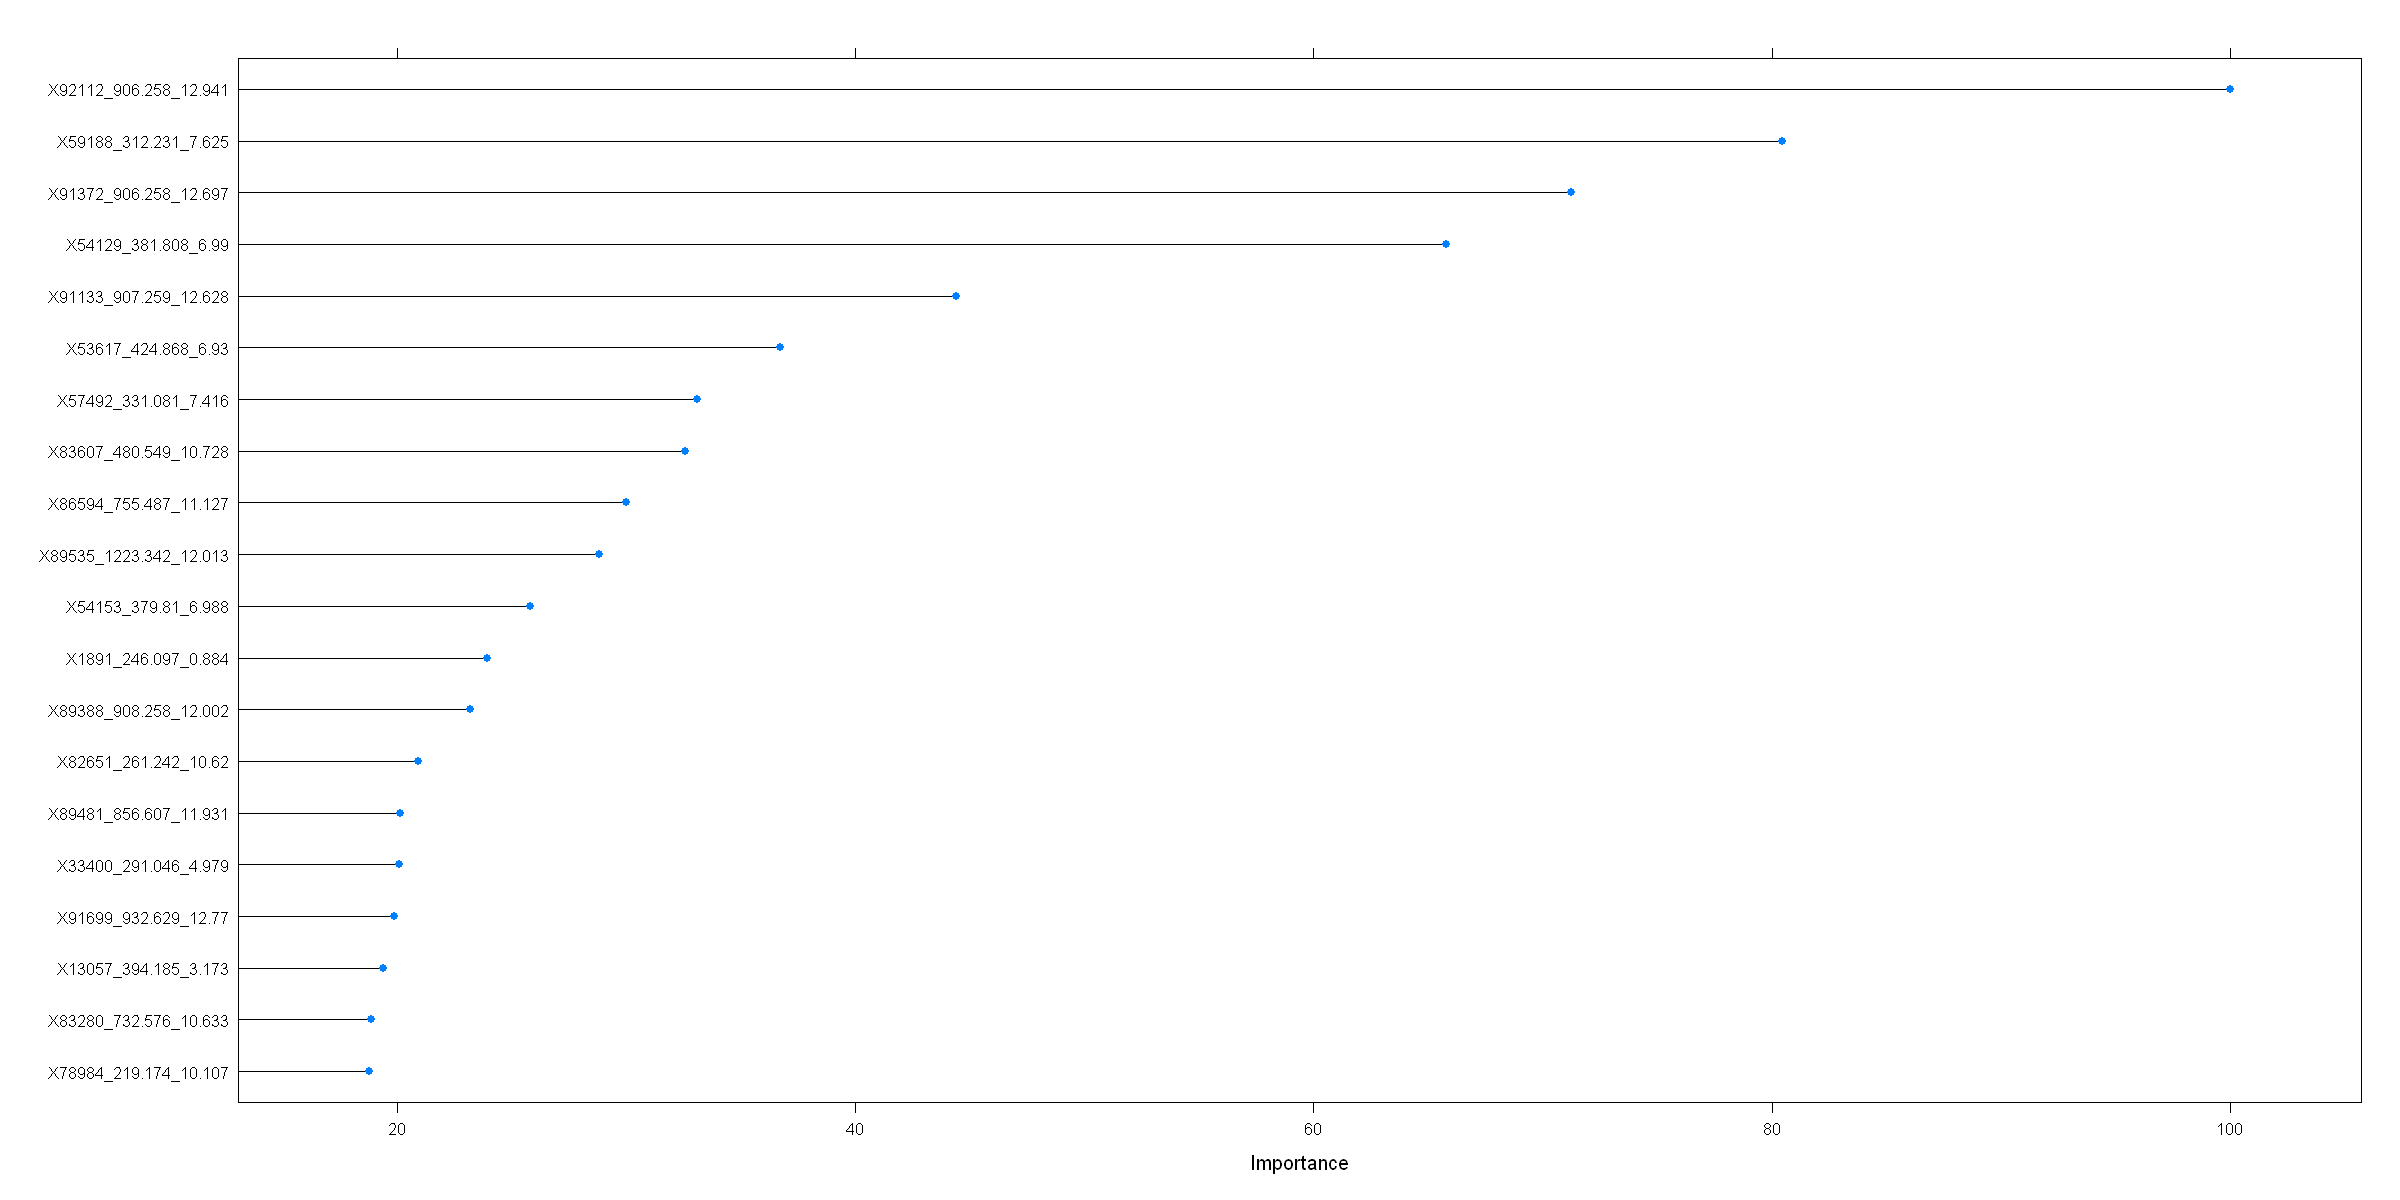

In [445]:
plot(varImp(xgb_model_final, scale = T), top = 20)

# <font color = 'blue'>  7. Conclusion </font>
<a id="outro"></a>

In [446]:
names(as.list(.GlobalEnv)) #We can get a look at the name of all variables stored in the global environment

[1] "prediction_probs_tuned" "op_shapiro"             "xgb_tune"              
  [4] "anova_out"              "cut_res"                "dend_obj"              
  [7] "bm"                     "md_Blank"               "op_KW"                 
 [10] "ann"                    "ft_t"                   "taskID"                
 [13] "n_threads"              "cl"                     "md_Samples"            
 [16] "Imp_s"                  "Samples"                "Imp_t"                 
 [19] "op_wilcox"              "output_lm"              "new_ft"                
 [22] "pcoa_pts"               "rain_out"               "catper"                
 [25] "distm"                  "plot_anova"             "raw_pcoa"              
 [28] "Cutoff"                 "md"                     "start"                 
 [31] "var"                    "col_dend"               "blk_rem"               
 [34] "colours"                "ft_an"                  "ROC_base"              
 [37] "hmap"                   "plot_dunn"              "norm_pqn"              
 [40] "ft_url"                 "Blank"                  "train_control"         
 [43] "tune_control"           "train_x"                "train_y"               
 [46] "ft_merged2"             "xgb_base"               "final_grid"            
 [49] "box_plot"               "FreqTable"              "Data"                  
 [52] "combined_boxplots"      "prediction_probs_base"  "InsideLevels"          
 [55] "test_x"                 "test_y"                 "op_aov_kw"             
 [58] "fm"                     "predicted_base"         "tune_grid2"            
 [61] "sig_4"                  "tune_grid3"             "tukey_out"             
 [64] "tune_grid4"             "tune_grid5"             "ft1"                   
 [67] "trp"                    "ft2"                    "out_res"               
 [70] "ft"                     "xgb_model_final"        "md1"                   
 [73] "md2"                    "ROC_tuned"              "ftTrain"               
 [76] "b1"                     "md_url"                 "nrounds"               
 [79] "an1"                    "an2"                    "norm_TIC"              
 [82] "hmap_km"                "colAnn"                 "tastID"                
 [85] "a"                      "bins"                   "b"                     
 [88] "imp"                    "op_aov"                 "adonres"               
 [91] "op_dunn"                "kruskall_out"           "hclust_res"            
 [94] "i"                      "row_order_res"          "plotPCoA"              
 [97] "lib_list"               "fts_nonimp"             "volcano_rainfall"      
[100] "ran_val"                "lm_lat"                 "scores_gapfilled"      
[103] "ib"                     "Cutoff_LOD"             "raw_fts"               
[106] "xgb_tune2"              "xgb_tune3"              "wilcox_out"            
[109] "predicted_final"        "xgb_tune4"              "xgb_tune5"             
[112] "volcano_lat"            "hmap_km_draw"           "Avg_ft"                
[115] "Directory"              "dunn_out"               "output_tukey"          
[118] "file_names"             "ft_nonimp"              "new_md"                
[121] "grid_default"           "an_url"                 "ftTest"                
[124] "PcoA_points"            "output_rainfall"        "tune_grid"             
[127] "an"                     "ft_nonimp_0"            "batch_df"              
[130] "variance"               "trainIndex"             "ft_merged"             
[133] "PcoA"                   "plot_tukey"

In [447]:
sessionInfo() # to see all the information about the current R session

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22000)

Matrix products: default

locale:
[1] LC_COLLATE=English_United Kingdom.utf8 
[2] LC_CTYPE=English_United Kingdom.utf8   
[3] LC_MONETARY=English_United Kingdom.utf8
[4] LC_NUMERIC=C                           
[5] LC_TIME=English_United Kingdom.utf8    

attached base packages:
[1] parallel  grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] NCmisc_1.2.0          doParallel_1.0.17     iterators_1.0.14     
 [4] foreach_1.5.2         pROC_1.18.0           caret_6.0-93         
 [7] xgboost_1.7.3.1       NbClust_3.0.1         dendextend_1.16.0    
[10] ComplexHeatmap_2.14.0 cowplot_1.1.1         matrixStats_0.63.0   
[13] FSA_0.9.3             ggsci_2.9             factoextra_1.0.7     
[16] svglite_2.1.0         IRdisplay_1.1         vegan_2.6-4          
[19] lattice_0.20-45       permute_0.9-7         g

# <font color = 'blue'> Bibliography </font>
<a id="bib"></a>

- Nygaard V, Rødland EA, Hovig E, Methods that remove batch effects while retaining group differences may lead to exaggerated confidence in downstream analyses, Biostatistics, Volume 17, Issue 1, January 2016, Pages 29–39, https://doi.org/10.1093/biostatistics/kxv027
- Wehrens R, Hageman JA, van Eeuwijk F, Kooke R, Flood PJ,Wijnker E, Keurentjes JJ, Lommen A, van Eekelen HD,Hall RD. 2016. Improved batch correction in untargeted MS‐based metabolomics. Metabolomics 12:88.  doi: 10.1007/s11306-016-1015-8
